In [21]:
import sys
sys.path.insert(1, '/workspace/share')
from inference import Dev_model
import numpy as np
from collections import OrderedDict
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from utils.torch_utils import prune
from models.experimental import attempt_load
from utils.torch_utils import select_device
import torch
import math
import copy
import glob
import os

In [2]:
damage = 'combine_crack'
path = Path('/workspace/share')
img_path = path/'origin_data_coco'/damage/'images'
model_path = '../checkpoints/09_09/combine_crack/combine_crack_2.pt'
#model_path=['prune.pt']

In [4]:
model = Dev_model(model_path,0.3,0.4,damage,1344)

Using CUDA device0 _CudaDeviceProperties(name='RTX A5000', total_memory=24256MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients


In [5]:
data = json.load(open(path/'origin_data_coco'/damage/'annotations'/'test.json'))
print(len(data['images']),len(data['annotations']))

672 1247


OrderedDict([('/workspace/share/origin_data_coco/combine_crack/images/https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7412_front_right_view_p2-24.jpg', OrderedDict([('boxes', [[296, 498, 383, 554]]), ('labels', ['combine_crack']), ('scores', [0.44265949726104736])]))])
[[296, 498, 383, 554]]


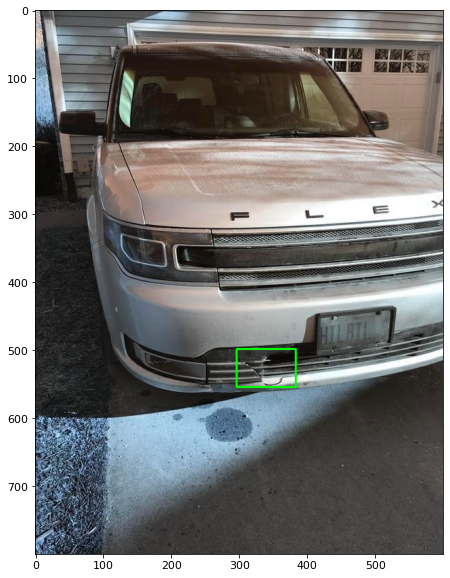

In [6]:
test_i = data['images'][0]
idx = test_i['id']
i_path = img_path/test_i['file_name']
#print(data['images'][14])
out = model.inference(str(i_path))
print(out)
boxes = out[str(i_path)]['boxes']
print(boxes)
i = cv2.imread(str(i_path))
for b in boxes:
    cv2.rectangle(i,(b[0],b[1]),(b[2],b[3]),(0,255,0),2)
plt.figure(figsize=(20,10))
plt.imshow(i)

In [27]:
files = glob.glob('../origin_data_coco/100/*')
output = 'glass_broken'
os.makedirs(output,exist_ok=True)

for idx, file in enumerate(files):
    img = cv2.imread(file)
    out = model.inference(file)
    #print(out)
    #print(file)
    boxes = out['/workspace/share/'+file[3:]]['boxes']
    for b in boxes:
        #print(b)
        cv2.rectangle(img,(b[0],b[1]),(b[2],b[3]),(0,255,0),2)
    cv2.imwrite(output+'/'+str(idx)+'.jpg',img)
    #print(boxes)
    #break

In [7]:
def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels):
    fp = 0
    tp = 0
    #fp_boxes = []
    
    for i in range(len(pred_boxes)):
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        
        if len(ious) == 0:
            return 0,0,0
        
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
        else:
            if ious[idx] > 0 and cal_new_iou_min(img,pred_boxes[i],gt_boxes[idx]) > 0.8 and cal_new_iou_max(img,pred_boxes[i],gt_boxes[idx]) > 0.2:
                tp += 1
                gt_labels[idx] = -1
                #tp_check[i] = 1
            else:
                fp += 1
            #fp += 1
            #fp_boxes.append(pred_boxes[i])

    fn = len(gt_boxes) - tp
    
    return tp,fp,fn

In [9]:
total_tp = 0
total_fn = 0
total_fp = 0

dummy_data = []

for i in tqdm(data['images']):
    i_path = img_path/i['file_name']
    gt_boxes = [a['bbox'] for a in data['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[int(b[0]),int(b[1]),int(b[0])+int(b[2]),int(b[1])+int(b[3])] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    img = cv2.imread(str(i_path))
    #print('debug :',i_path)
    pred = model.inference(str(i_path))
    #print(i_path)
    pred = pred[str(i_path)]
    pred_boxes = pred['boxes']
    pred_labels = [0 for i in pred['labels']]
    
    tp,fp,fn = cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels)
    print(i['file_name'])
    print(tp,fp,fn)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    if fn > 0 :
        dummy_data.append(i['file_name'])
    #break
print(total_tp,total_fp,total_fn)

  0%|                                                                                                                                                 | 1/2252 [00:00<06:15,  6.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459466_04.JPG
1 0 0


  0%|▏                                                                                                                                                | 2/2252 [00:00<15:13,  2.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_47_DSCN0136.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])


  0%|▎                                                                                                                                                | 4/2252 [00:00<08:08,  4.60it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W4235_detail_damage1_8584_medium_B866BE6D-406A-4AE7-9ECA-E2B6E33E9002.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1480_DSCN4801mark+(2).JPG
1 1 0


  0%|▍                                                                                                                                                | 6/2252 [00:01<05:56,  6.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2871_detail_damage1_24797_medium_2019-06-17_17.46.38.jpg
4 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1047_IMG-20180825-WA0035.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  0%|▌                                                                                                                                                | 9/2252 [00:01<04:38,  8.05it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_TD%2014A%20-%20204.98%20-%2027.05.2018_z1001057598950_c7b20679d7a8d2af31a8a1553ce9d6dd.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000402_316008156_DSCN4978.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20131.09%20-%2005.04.2018_14A%20-%20131.09_z950954810081_579a9ea3512e57045819add8cd12f544.jpg
1 0 3


  0%|▋                                                                                                                                               | 11/2252 [00:01<04:19,  8.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_detail_damage1_22975_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5b58609f6b84ee33601478ac63d3862302398e89.jpg
1 0 2


  1%|▊                                                                                                                                               | 13/2252 [00:01<03:54,  9.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_886_IMG_1925.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6259_detail_damage2_15329_medium_BF7760D1-D31F-433F-BC15-B9C3B342B6E4.jpeg
2 0 1


  1%|▉                                                                                                                                               | 15/2252 [00:01<03:49,  9.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_383_P_20151222_125540.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6418_vehicle_additional_docs_15599_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5657_rear_left_view_9635_medium_IMG_20180806_164533401_HDR.jpg
0 1 1


  1%|█                                                                                                                                               | 17/2252 [00:02<03:57,  9.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0f5eb5c9fa6af3f703710275359db0ccb1707fb3.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_vehicle_additional_docs_39152_medium_image.jpg
1 1 4


  1%|█▏                                                                                                                                              | 19/2252 [00:02<03:55,  9.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655102_IMG_0145.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_824_IMG_9827.JPG
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▎                                                                                                                                              | 21/2252 [00:03<09:38,  3.86it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7974.JPG
1 1 1


  1%|█▍                                                                                                                                              | 22/2252 [00:04<11:11,  3.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_57_DSCN7508.JPG
1 0 0


  1%|█▌                                                                                                                                              | 24/2252 [00:04<08:26,  4.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W4237_detail_damage1_8658_medium_15323934206938903065793110052962.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611801307_img1803455.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4378_detail_damage2_19873_medium_image.jpg
1 0 0


  1%|█▊                                                                                                                                              | 28/2252 [00:04<05:30,  6.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_rear_right_view_23029_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_rear_left_view_12853_medium_CD2C9350-C51C-41EC-8F3D-8BBA48777DB1.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_626_IMG_5914.JPG
1 0 0


  1%|█▊                                                                                                                                              | 29/2252 [00:04<05:15,  7.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f7f5e0d9076d40b1193678442037743399be2bc.jpg
1 0 0


  1%|█▉                                                                                                                                              | 30/2252 [00:05<08:22,  4.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1319_DSCN1190.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|██                                                                                                                                              | 32/2252 [00:05<06:23,  5.79it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5173_detail_damage2_20277_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_rear_right_view_18527_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2382_detail_damage2_30103_medium_15688241462082717151488734679487.jpg
1 0 0


  2%|██▎                                                                                                                                             | 36/2252 [00:06<06:02,  6.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1328_DSCN1280.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0086_detail_damage1_p6-56.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_492_IMG_0068.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 1

  2%|██▍                                                                                                                                             | 39/2252 [00:06<07:13,  5.11it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1314_DSCN6996.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6346_front_left_view_21305_medium_4124F91E-86AD-4144-AB9F-EF16A2B1CFD7.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1117_IMG_20180417_141615mark+(2).jpg
1 0 0


  2%|██▌                                                                                                                                             | 40/2252 [00:07<07:34,  4.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_314_100_3885.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8728_detail_damage2_8165_medium_20180607_181741.jpg
1 0 0


  2%|██▋                                                                                                                                             | 43/2252 [00:07<05:45,  6.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W6895_detail_damage2_10272_medium_20180821_131409.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20235.85%2001.08.2018_z1069630440992_761520653e3e752e4c9df64c020e7e27.jpg
2 0 0


  2%|██▉                                                                                                                                             | 45/2252 [00:07<05:00,  7.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3211_vehicle_additional_docs_51003_medium_20200824_164828.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2aa4ec6cc9052b52fe5686f91d969c6572d8f427.jpg
2 0 1


  2%|██▉                                                                                                                                             | 46/2252 [00:07<04:51,  7.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0bf7424b4aa3fb14d84df89944786fd421f9a854.jpg
0 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1250_front_right_view_29610_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|███                                                                                                                                             | 48/2252 [00:07<04:08,  8.87it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X3188_detail_damage1_13540_medium_32AA3F54-33D2-46EA-B451-7D1863B9FD53.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4527_detail_damage1_31299_medium_15709929710662225372803339463414.jpg
2 0 0


  2%|███▏                                                                                                                                            | 50/2252 [00:08<06:48,  5.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_363_DSCN7477.JPG
1 0 0


  2%|███▎                                                                                                                                            | 51/2252 [00:08<06:24,  5.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b87b281f940d3085a7f02a7206cc2c4a0fe3f42.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|███▍                                                                                                                                            | 53/2252 [00:09<05:41,  6.44it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c7284b22af1a86cb26c50927884e4e1938c9a31.jpg
3 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c26e6bfb514f9f688d07191404c9b6800e1b8db.jpg
1 0 0


  2%|███▍                                                                                                                                            | 54/2252 [00:09<05:35,  6.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000739_316795393_CIMG8843.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9175_vehicle_additional_docs_17030_medium_15476687318801174163277986034008.jpg
3 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|███▌                                                                                                                                            | 56/2252 [00:09<04:37,  7.91it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_39_IMG-20170601-WA0020.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1077_IMG-20180831-WA0113.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|███▊                                                                                                                                            | 60/2252 [00:09<03:50,  9.51it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20179.95%20-%2015.07.2018_z1052255415820_73185d4f70e566a16cc6f203a4b31a98.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5204_rear_right_view_14849_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0475_vehicle_additional_docs_17648_medium_20190202_145947.jpg
1 0 0


  3%|███▉                                                                                                                                            | 62/2252 [00:09<03:56,  9.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2307_detail_damage2_13113_medium_469C6EEC-1B86-40D0-83B5-22E6F0357C77.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1189_IMG-20181224-WA0007+mark+(2).jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0888_vehicle_additional_docs_2396

  3%|████                                                                                                                                            | 64/2252 [00:10<04:36,  7.91it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_107_IMG_20170522_150609.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▎                                                                                                                                           | 67/2252 [00:11<06:48,  5.34it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_47_DSCN0139.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20229.47%20-%2001.10.2018_z1131293337397_139e8110ad51a05e40db7bcedd122379.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T5684_front_right_view_4747_medium_IMG_3804.JPG
1 0 0


  3%|████▍                                                                                                                                           | 69/2252 [00:11<05:40,  6.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_18_IMG-20180707-WA0008mark+(3).jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20048.25%20-%2019.11.2018_z1180794423119_58471e891a3d571f0fbe3b216f50e4e4.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▌                                                                                                                                           | 71/2252 [00:11<04:49,  7.53it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W0629_detail_damage1_7032_medium_4C74874D-20A2-4D7C-982A-D3D6BE40E7DB.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T9982_front_right_view_6557_medium_20180620_173933.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C7011_detail_damage2_46013_medium_19CF4794-C613-44A7-8E6B-AC0832D5FAAB.jpeg
0 1 1


  3%|████▊                                                                                                                                           | 75/2252 [00:11<03:59,  9.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20230.88%20-2%20%20-%2006.05.2018_14A%20-%20230.88_z979197477742_ded3c51bc45372337b4788025089d489.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_327_IMG_4746.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.

  3%|████▉                                                                                                                                           | 77/2252 [00:12<03:48,  9.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_874_DSCN4344.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1dd21a845b866fc6689658314475d649c5af77db.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████                                                                                                                                           | 79/2252 [00:12<03:33, 10.18it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_626_IMG_5915.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4536_front_left_view_31571_medium_6FBC62F5-5CAA-49FC-B882-4A1D9D3BBB06.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8136_front_left_view_33173_medium_image.jpg
1 0 1


  4%|█████▏                                                                                                                                          | 81/2252 [00:12<03:24, 10.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_927_IMG_20181112_172138.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C9835_vehicle_additional_docs_48814_medium_image.jpg
1 2 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▍                                                                                                                                          | 85/2252 [00:12<03:19, 10.85it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_902_IMG_4758.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_840_IMG_4816.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9661_detail_damage1_11461_medium_IMG_6357.jpg
1 0 0


  4%|█████▌                                                                                                                                          | 87/2252 [00:12<03:15, 11.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_559_IMG_0984.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9813_front_right_view_17483_medium_KIMG0093.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_265_IMG-20181102-WA0025.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
sh

  4%|█████▊                                                                                                                                          | 90/2252 [00:14<07:21,  4.90it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7962.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_60ead5bacbe4502c670454db1b4f8ea08dc40a60.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▉                                                                                                                                          | 92/2252 [00:14<05:52,  6.12it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B9133_vehicle_additional_docs_37602_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W0592_front_left_view_7844_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|██████                                                                                                                                          | 94/2252 [00:14<05:14,  6.86it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928129.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0228_rear_right_view_40130_medium_E29DA5E1-C171-4113-8C3A-EC9A32922510.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7888.JPG
1 0 0


  4%|██████▏                                                                                                                                         | 96/2252 [00:14<05:24,  6.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_335_100_3583.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9581_detail_damage2_23378_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|██████▎                                                                                                                                        | 100/2252 [00:15<05:52,  6.10it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51149931_249856455916115_2472739360957530112_n.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2827_front_left_view_19091_medium_20190306_180135.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6907_rear_left_view_32526_medium_image.jpg
1 1 0


  5%|██████▍                                                                                                                                        | 102/2252 [00:15<04:55,  7.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_vehicle_additional_docs_25168_medium_image.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_460_IMG_5596.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|██████▋                                                                                                                                        | 105/2252 [00:16<04:18,  8.31it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42063_medium_D6424C55-7D00-4153-8501-065BE24F688A.jpeg
8 0 5
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1145_detail_damage2_p7-64.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_726_IMG_9750.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Si

  5%|██████▊                                                                                                                                        | 107/2252 [00:16<05:26,  6.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1024_100_4589.JPG
2 0 1


  5%|██████▉                                                                                                                                        | 109/2252 [00:16<04:43,  7.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_922_IMG_3884.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C9664_detail_damage1_46557_medium_15974501228315692290476306121777.jpg
1 0 0


  5%|██████▉                                                                                                                                        | 110/2252 [00:17<06:04,  5.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1025_100_4579.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████                                                                                                                                        | 112/2252 [00:17<05:16,  6.77it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_723_IMG_1281.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_246_IMG-20181122-WA0020mark+(2).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▏                                                                                                                                       | 114/2252 [00:17<04:30,  7.90it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6284_rear_right_view_21433_medium_20190416_182358.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4273_front_left_view_14191_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W2888_front_left_view_7693_medium_image.jpg
2 0 1


  5%|███████▎                                                                                                                                       | 116/2252 [00:17<04:02,  8.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6624_front_right_view_32490_medium_CAAB3904-6A78-47B8-A370-7949F611512A.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5a796220d6b4ec5bf18519f7537de8e2c79f0387.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▌                                                                                                                                       | 120/2252 [00:17<03:31, 10.06it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_rear_left_view_32958_medium_image.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_IMG_8161.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_452_IMG_2847.JPG
1 0 0


  5%|███████▋                                                                                                                                       | 122/2252 [00:18<03:48,  9.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20246.28%20-%2029.09.2018_z1130932209414_edf70a225568684117f27183a7aa1efa.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_018f63f9d808b69702e177223e7beada5f6315b9.jpg
1 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|███████▉                                                                                                                                       | 125/2252 [00:19<06:03,  5.86it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7842.JPG
0 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_488_IMG_9125.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W3269_front_left_view_7878_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W7366_det

  6%|████████                                                                                                                                       | 127/2252 [00:19<06:48,  5.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_409_100_3477.JPG
3 0 0


  6%|████████▏                                                                                                                                      | 128/2252 [00:19<06:19,  5.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d87f88a75457fb36c3b7bab242a6c722a65de3f.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_vehicle_additional_docs_27187_medium_IMG_20190724_122720.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▍                                                                                                                                      | 132/2252 [00:20<04:28,  7.90it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A7067_front_left_view_32607_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_vehicle_additional_docs_16453_medium_IMG_20181226_073114.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228820996_413240a9ca0a6e87f809d0239d052a05.jpg
1 0 0


  6%|████████▌                                                                                                                                      | 134/2252 [00:20<04:12,  8.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_538_IMG_5690.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1146_IMG_20180502_145828.jpg
1 1 0


  6%|████████▋                                                                                                                                      | 136/2252 [00:20<03:50,  9.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_front_left_view_p3-32.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_vehicle_additional_docs_p8-72.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▊                                                                                                                                      | 138/2252 [00:20<03:40,  9.58it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TNDS%2029A%20-%20755.15%20-%2014.09.2018_z1113660395094_d0cd82d15daf384349b7b0d241ab2400.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_620_IMG_8905.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5efbfc49b870e26cd8fac99e89ec288b5a67463e.jpg
1 0 0


  6%|████████▉                                                                                                                                      | 140/2252 [00:20<03:36,  9.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2653_front_right_view_20941_medium_1554767049537578387790643377856.jpg
1 0 0


  6%|█████████                                                                                                                                      | 142/2252 [00:21<04:32,  7.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1287_100_3724.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9492_detail_damage1_17324_medium_image.jpg
0 1 1


  6%|█████████▏                                                                                                                                     | 144/2252 [00:21<04:05,  8.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1053_IMG-20180817-WA0011mark+(5).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5629_front_right_view_10069_medium_20180816_092321.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1546_front_right_view

  7%|█████████▍                                                                                                                                     | 148/2252 [00:21<04:38,  7.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_149_DSCN0902.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1596_detail_damage1_24335_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7676_rear_right_view_22082_medium_FFEA0B94-6E46-43B9-A600-EA06F0AE563C.jpeg
1 0 0


  7%|█████████▍                                                                                                                                     | 149/2252 [00:22<04:35,  7.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771053.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_689_IMG_0177.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▋                                                                                                                                     | 153/2252 [00:22<03:42,  9.42it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_49d6d55bd980c6e46326b33103eb7f50.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9639_detail_damage1_11487_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0812_rear_left_view_28971_medium_15669411943552948481448420599914.jpg
1 0 1


  7%|█████████▊                                                                                                                                     | 155/2252 [00:22<03:38,  9.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20174.46%20-%2004.05.2018_14A%20-%20174.46_z979043452954_93c4f7908fd76d8d6c670d93cf8820d8.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5286_vehicle_additional_docs_26128_medium_20190627_220957.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


  7%|█████████▉                                                                                                                                     | 157/2252 [00:22<03:37,  9.62it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c68b6ffc0cb8fa64ba3ce02915f6849ebd901f7.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_detail_damage2_24953_medium_2A5FD6EC-8F98-4B93-B8DC-2FBCCC768299.jpeg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|██████████                                                                                                                                     | 159/2252 [00:23<03:23, 10.29it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B9949_rear_left_view_38252_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4945_vehicle_additional_docs_20153_medium_15535542746525256384188026926207.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6b29e20235c5bc584a7ae6430df15c3530e88f40.jpg
1 0 0


  7%|██████████▎                                                                                                                                    | 163/2252 [00:23<03:12, 10.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5730.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1295_DSCN9090.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6624_rear_left_view_32493_medium_CBFE0C6C-5A92-4E1C-8FC5-0E6EEAAA02BF.jpeg
1 0 1


  7%|██████████▍                                                                                                                                    | 165/2252 [00:23<04:01,  8.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_378_100_2036.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_808_IMG_8516.JPG
1 0 0


  7%|██████████▌                                                                                                                                    | 167/2252 [00:23<04:07,  8.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c71578abe3dc675893acfd2148d653856025d2c.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2098A%20-%20170.45%20-%2024.12.2018_z1212755909449_e4848b3c56beece21aa568b9c3936447.jpg
0 1 1


  8%|██████████▋                                                                                                                                    | 169/2252 [00:24<03:38,  9.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0895_vehicle_additional_docs_38790_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A9304_detail_damage1_33406_medium_20191211_163822.jpg
1 0 0


  8%|██████████▊                                                                                                                                    | 170/2252 [00:24<06:45,  5.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1154_DSCN2419mark+(6).JPG
1 0 0


  8%|██████████▉                                                                                                                                    | 172/2252 [00:24<05:24,  6.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T5087_front_right_view_4474_medium_20180507_154920.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1048_2415_sk20180806_185943.jpg
1 0 0


  8%|██████████▉                                                                                                                                    | 173/2252 [00:24<05:00,  6.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5f97bc790665b8704bce42c1ecc17f6f9665366d.jpg
0 0 2


  8%|███████████                                                                                                                                    | 174/2252 [00:25<06:16,  5.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_398_100_4015.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_front_right_view_32956_medium_A273DD58-5A77-4379-B2C3-46B3F88278B2.jpeg
1 0 0


  8%|███████████▏                                                                                                                                   | 177/2252 [00:25<05:14,  6.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_658_IMG_9167.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6622_detail_damage1_35801_medium_15865434407057544185387349312217.jpg
14 2 6


  8%|███████████▎                                                                                                                                   | 179/2252 [00:25<04:18,  8.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7742_front_left_view_16526_medium_AC521E6B-1DDA-4AF4-A0F5-10414AC1007F.jpeg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1567_vehicle_additional_docs_p9-80.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|███████████▍                                                                                                                                   | 181/2252 [00:26<04:26,  7.78it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_230_IMG-20181005-WA0025MARK+(4).jpg
0 2 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_209_IMG-20180903-WA0018.jpg
0 0 1


  8%|███████████▌                                                                                                                                   | 183/2252 [00:26<03:50,  8.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446690373_95973b4a8b401ab2d3f1529116751902.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_929_DSCN8826.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-

  8%|███████████▊                                                                                                                                   | 187/2252 [00:26<03:14, 10.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4889_detail_damage1_20101_medium_F06960EF-FEBE-45C6-B3CF-6F33AA0B133B.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2688_vehicle_additional_docs_30561_medium_010C2DA0-683D-408D-8437-71B3AC8F4BEE.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4

  8%|████████████                                                                                                                                   | 189/2252 [00:26<03:05, 11.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0736_detail_damage1_p6-56.jpg
1 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_740_IMG_0093.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7014_front_right_view_21620_medium_15556916203034793283189838341057.jpg

  8%|████████████▏                                                                                                                                  | 191/2252 [00:27<03:51,  8.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_426_100_3501.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8953_vehicle_additional_docs_17158_medium_ACB0A451-C46C-440A-A45A-DF3BECD65085.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|████████████▍                                                                                                                                  | 195/2252 [00:27<03:19, 10.32it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W3330_detail_damage2_8042_medium_1FD559D6-686D-46B5-93FE-C56FEED98413.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3244_vehicle_additional_docs_25029_medium_BAECA7A3-B6E8-420E-A627-C28390837246.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_vehicle_additional_docs_16531_medium_0A77DCB6-CB6D-449D-B664-94A85B27C0BA.jpeg
1 0 0


  9%|████████████▌                                                                                                                                  | 197/2252 [00:27<03:18, 10.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_741_IMG_2609.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W6235_rear_right_view_10428_medium_20180823_185452.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|████████████▋                                                                                                                                  | 199/2252 [00:27<03:17, 10.40it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W0907_rear_left_view_7117_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20271.84%20-%2023.07.2018_z1060459751127_99a4ec678fb1953156fd94e5746e7aff.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W6607_detail_damage1_10632_medium_image.jpg
1 0 1


  9%|████████████▊                                                                                                                                  | 201/2252 [00:27<03:13, 10.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9503_rear_right_view_11446_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_58e2b152a1c6847acefc436355b5968e5d92597a.jpg
1 0 0


  9%|████████████▉                                                                                                                                  | 203/2252 [00:28<03:28,  9.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_64c5cd7b37945c5f4bfa06bbb541f0bfca5ed22f.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_375_DSCN6142.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|█████████████                                                                                                                                  | 205/2252 [00:28<05:45,  5.93it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X7599_detail_damage1_16045_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1898_rear_right_view_p4-40.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|█████████████▏                                                                                                                                 | 208/2252 [00:29<06:58,  4.88it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1234_mark+(3).JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_323615170_Predni_blatnik_11.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


  9%|█████████████▎                                                                                                                                 | 210/2252 [00:29<05:37,  6.06it/s]

debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3098_detail_damage1_19605_medium_15525955415658757112640661037863.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_522_IMG_1695.JPG
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4686_rear_left_view_19995_medium_IMG_20190321_181137.jpg
1 0 0


  9%|█████████████▌                                                                                                                                 | 213/2252 [00:30<04:37,  7.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0798_rear_left_view_39057_medium_20200609_084130.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a86adbb5def8822c4567df6eb0262397db8f960.jpg
2 0 0


 10%|█████████████▌                                                                                                                                 | 214/2252 [00:30<04:26,  7.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1282_IMG_20180816_131432.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4793_front_left_view_14445_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|█████████████▊                                                                                                                                 | 218/2252 [00:30<03:43,  9.09it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_756_IMG_7273.JPG
1 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0795_mileage_23862_medium_IMG_20190529_171402.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_11f2269f802b6f89b9c44edadc4b4c0b0d6e9d83.jpg
1 0 0


 10%|█████████████▉                                                                                                                                 | 220/2252 [00:30<03:31,  9.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_963_IMG_0534.JPG
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9904_detail_damage1_17380_medium_20190128_112157.jpg
2 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████                                                                                                                                 | 222/2252 [00:30<03:17, 10.29it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6845_detail_damage2_22842_medium_20190414_113353.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6992_detail_damage1_21613_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2689_rear_left_view_13476_medium_92D0A0DF-C1AB-4088-B7E9-34FE3B256721.jpeg
0 0 1


 10%|██████████████▏                                                                                                                                | 224/2252 [00:31<03:21, 10.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.19+AM+(1).jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8263.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████▍                                                                                                                                | 228/2252 [00:31<03:04, 10.98it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X0589_rear_right_view_11988_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9546_front_left_view_11900_medium_136.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1524_detail_damage1_12783_medium_49760B21-E87C-4B54-9C48-2A0806D07CA4.jpeg
1 0 1


 10%|██████████████▌                                                                                                                                | 230/2252 [00:31<03:13, 10.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1094_IMG-20180918-WA0013.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_197_0083_sk20180912_125441.jpg
2 0 0


 10%|██████████████▋                                                                                                                                | 232/2252 [00:31<03:21, 10.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0068.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_319_DSCN7620mark+(2).JPG
1 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079049.jpg
1 0 0


 10%|██████████████▊                                                                                                                                | 234/2252 [00:32<05:30,  6.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1364_DSCN1036.JPG
1 0 0


 10%|██████████████▉                                                                                                                                | 235/2252 [00:32<05:11,  6.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1066_2887_sk20180820_161406.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_detail_damage2_27971_medium_D8D0E49F-8EB1-4D82-B194-15B58C07504C.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▏                                                                                                                               | 239/2252 [00:32<03:58,  8.43it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6792_rear_left_view_21385_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8412_vehicle_additional_docs_10769_medium_20180904_181720.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0e7a31ff8d78f08e1ebdd50422f300ae3564010e.jpg
1 0 0


 11%|███████████████▏                                                                                                                               | 240/2252 [00:33<03:56,  8.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_56fa84307caab77dddf9ed3e86268d6f593f7852.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_911_IMG_6661.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▎                                                                                                                               | 242/2252 [00:33<03:34,  9.38it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018T9991_detail_damage2_6450_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1362_DSCN1059.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▌                                                                                                                               | 246/2252 [00:34<04:59,  6.70it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1454_rear_right_view_18231_medium_15503320069344775642852742972935.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_84_IMG-20170602-WA0016.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840959994_0a8069b11bcaa11d7e7d8e548b5f5fc6.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22,

 11%|███████████████▋                                                                                                                               | 247/2252 [00:35<11:18,  2.95it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3295.JPG
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▊                                                                                                                               | 250/2252 [00:35<07:35,  4.39it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_820_IMG_8624.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4859_detail_damage2_27026_medium_AA24AE35-1877-4648-A99C-0561CF16601B.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_737_IMG_0460.JPG
0 0 2


 11%|████████████████                                                                                                                               | 252/2252 [00:35<06:10,  5.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HP%2014A%20-%20184.52_z1160311517720_355dfc8c2340ddcdb4280fb279f2ecc8.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_44_IMG-20181228-WA0110+mark+(3).jpg
3 0 0


 11%|████████████████▏                                                                                                                              | 254/2252 [00:36<04:57,  6.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HH%2014C%20-%20104.91%20-%2014.05.2018_14C%20-%20104.91_z988041444066_355efaa90177891f357a1c226c6cc360.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_374_DSCN5900.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-a

 11%|████████████████▎                                                                                                                              | 257/2252 [00:36<05:06,  6.52it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_309_100_4020.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_165_IMG_20181101_120051MARK+(4).jpg
1 0 0


 12%|████████████████▍                                                                                                                              | 259/2252 [00:36<04:18,  7.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W7968_rear_right_view_10774_medium_4101DFC1-699A-4C33-965E-940740E3F7EF.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_744_TimePhoto_20180506_170135.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25842_medium

 12%|████████████████▌                                                                                                                              | 261/2252 [00:37<06:25,  5.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_330_DSCN8976.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T9269_rear_right_view_6136_medium_B25AB1FD-73DE-42E8-AE8E-A81755EB1394.jpeg
1 0 0


 12%|████████████████▋                                                                                                                              | 263/2252 [00:37<05:12,  6.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_739_IMG_5668.JPG
1 0 0


 12%|████████████████▊                                                                                                                              | 265/2252 [00:37<05:47,  5.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_986_mark+(1).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365308554_72c6da66547dffaa0dfe43c369a5e4e0.jpg
0 1 2


 12%|████████████████▉                                                                                                                              | 266/2252 [00:38<06:23,  5.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_310_100_4002.JPG
1 0 0


 12%|████████████████▉                                                                                                                              | 267/2252 [00:38<08:38,  3.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_161_DSCN0530.JPG
1 0 0


 12%|█████████████████                                                                                                                              | 268/2252 [00:39<09:22,  3.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_968_IMG_20190215_153505.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5825_front_right_view_20679_medium_IMG_20190404_162548432_HDR.jpg
2 1 1


 12%|█████████████████▏                                                                                                                             | 271/2252 [00:39<06:06,  5.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04e0e2e7fbe5164e003083e22f2d71814db33a91.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_02c78596dfe858ad65fe663687d628ce0e69abe9.jpg
1 0 2


 12%|█████████████████▎                                                                                                                             | 273/2252 [00:39<04:40,  7.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8954_front_right_view_33393_medium_20191211_150909.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32415_medium_92EC3569-6CFC-4F50-B994-2422D59E5480.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20th

 12%|█████████████████▍                                                                                                                             | 275/2252 [00:39<04:06,  8.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723324118_284c4b6d05051b2754646e1134abeeec.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42183_medium_12E5AE00-1A70-4068-831E-8096B39C87AC.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044

 12%|█████████████████▋                                                                                                                             | 278/2252 [00:40<03:58,  8.29it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HH%2014C%20-%20104.91%20-%2014.05.2018_14C%20-%20104.91_z988041413642_04ca2712a3c187efd7631d2c25bf193f.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096045711668_1b2b0cc86ab8cdd8da4ec14263d98366.jpg
0 0 1


 12%|█████████████████▋                                                                                                                             | 279/2252 [00:40<04:05,  8.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c88e86c3d2f49973e6ab493b26b300b6fb1d40e.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8542_rear_left_view_27988_medium_276F43CF-C185-43EE-8125-7702E103DA16.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|█████████████████▉                                                                                                                             | 282/2252 [00:40<03:32,  9.26it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A0529_vehicle_additional_docs_29154_medium_20190829_194840.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5fd90b9fc02e20cfffa0ed70b09147da46f9d450.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████                                                                                                                             | 284/2252 [00:40<03:24,  9.62it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_540_IMG_9321.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7881_vehicle_additional_docs_27765_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5269_front_left_view_9260_medium_IMG_20180802_093135.jpg
1 0 0


 13%|██████████████████▏                                                                                                                            | 286/2252 [00:40<03:16, 10.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_709_IMG_3740.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W0709_detail_damage2_6879_medium_image.jpg
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▍                                                                                                                            | 290/2252 [00:41<03:04, 10.66it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C7884_vehicle_additional_docs_44536_medium_20200812_070454.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5004_rear_right_view_20284_medium_20190327_162308.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1931_vehicle_additional_docs_12897_medium_20181012_101603_HDR.jpg
1 0 0


 13%|██████████████████▌                                                                                                                            | 292/2252 [00:41<03:08, 10.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316735964_1de06ed9f4a3e3a7400179bb71ae98e1.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20066.66%20-%2006.09.2018_z1106724046954_24540bafac99aab2ae86333a5e3174dd.jpg
0 1 1


 13%|██████████████████▋                                                                                                                            | 294/2252 [00:41<03:14, 10.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_30bc381494c79d4137ee3ac1d69d9941fc135288.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0883_detail_damage1_12175_medium_IMG_20180928_111404978_HDR.jpg
1 1 0


 13%|██████████████████▊                                                                                                                            | 296/2252 [00:41<03:27,  9.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801391_img1785765.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654970_IMG_0171.JPG
0 0 2


 13%|██████████████████▊                                                                                                                            | 297/2252 [00:42<04:20,  7.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_60da5d43e90b204d5ba69f1f0a15353f.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W6449_front_right_view_10233_medium_image.jpg
1 0 0


 13%|███████████████████                                                                                                                            | 300/2252 [00:42<03:57,  8.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1019_detail_damage2_p7-64.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7675_detail_damage2_36691_medium_image.jpg
1 0 0


 13%|███████████████████▏                                                                                                                           | 303/2252 [00:42<03:31,  9.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_254_IMG-20181123-WA0046MARK+(1).jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6388_rear_right_view_32271_medium_20191105_162031.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5594.JPG
1 0 0


 14%|███████████████████▎                                                                                                                           | 305/2252 [00:42<03:29,  9.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T4109_rear_right_view_4842_medium_2EE79DC2-1DBA-4192-A6D6-CD26B7380313.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0020.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▍                                                                                                                           | 307/2252 [00:43<03:10, 10.23it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9414_vehicle_additional_docs_23470_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_36018_medium_F25EAD34-32FF-4659-8065-D7B43BDD9907.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3687_detail_damage1_31414_medium_A2DFD212-BBA4-49BC-8D0D-6748F5781859.jpeg
1 0 0


 14%|███████████████████▌                                                                                                                           | 309/2252 [00:43<02:58, 10.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3450_front_right_view_13910_medium_15411726553766124249426914539538.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107203807_36e8aca7c7f3f378303f55084edb874e.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▉                                                                                                                           | 313/2252 [00:43<02:55, 11.04it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_485_IMG_7792.JPG
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6377_front_right_view_15204_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_694_IMG_3182.JPG
1 0 0


 14%|████████████████████                                                                                                                           | 315/2252 [00:43<02:54, 11.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_848_IMG_0670.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9894_detail_damage2_17375_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_79_IMG-20170916-WA0007.jpg
0 0 1


 14%|████████████████████▎                                                                                                                          | 319/2252 [00:44<02:50, 11.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7879_rear_left_view_27795_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9114_vehicle_additional_docs_29043_medium_20190828_090507.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4080_detail_damage1_31169_medium_image.jpg
1 0 0


 14%|████████████████████▍                                                                                                                          | 321/2252 [00:44<02:46, 11.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a251044d495d367d52537c3b82921d4feac4170.jpg
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_516_IMG_5881.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|████████████████████▌                                                                                                                          | 323/2252 [00:44<02:46, 11.55it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_743_IMG_3674.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_21c028d7280c9c868bd19151ed4cf56f2bf33f35.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4859_detail_damage1_27025_medium_E4A2FD68-986F-455F-B272-E7B9C7ECE29C.jpeg
1 0 0


 14%|████████████████████▋                                                                                                                          | 325/2252 [00:44<02:43, 11.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1466_rear_left_view_12582_medium_IMG_2707_(640x480).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|████████████████████▊                                                                                                                          | 327/2252 [00:44<03:11, 10.03it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1d44c71ba99b7849fac2b8b519069137840ae9fa.jpg
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2284_front_right_view_40032_medium_C7A698DB-9D94-4480-8BA5-CBD2697D9F71.jpeg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8323_detail_damage2_16676_medium_15466398068123599094749943787.jpg
2 0 0


 15%|████████████████████▉                                                                                                                          | 329/2252 [00:45<03:06, 10.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_791_TimePhoto_20180912_131515.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_front_left_view_14814_medium_8E1B3322-A9BD-4C97-8765-FA7D6DD9B99E.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▏                                                                                                                         | 333/2252 [00:45<02:58, 10.76it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20235.85%2001.08.2018_z1069630451273_0dbbcf24aaef19920bb4fa8e85d73c1e.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_804_IMG_0002.JPG
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2225_detail_damage1_18732_medium_image.jpg
1 0 0


 15%|█████████████████████▎                                                                                                                         | 335/2252 [00:45<02:55, 10.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42057_medium_FF3FA165-719F-4DBE-8384-DC62DD4A7961.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3799_front_left_view_14994_medium_9C66063C-8AB1-48E1-98C7-957C651CDF05.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▍                                                                                                                         | 337/2252 [00:45<03:05, 10.33it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7769_detail_damage1_23074_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0e698ac52980e44763f506a4dba649fbf450e873.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5ea5b509359b270bbe201151f6b7926413b0f9ef.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▋                                                                                                                         | 341/2252 [00:46<03:32,  9.00it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3872.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1451_detail_damage2_29751_medium_E12BF5BD-C4FD-425A-ACD5-5BB243F9A617.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7104_front_left_view_27292_medium_20190725_151928.jpg
0 0 1


 15%|█████████████████████▊                                                                                                                         | 343/2252 [00:46<03:38,  8.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295465.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1142_DSCN2481mark+(2).JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▉                                                                                                                         | 345/2252 [00:46<03:20,  9.52it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A4182_detail_damage1_31141_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0092_detail_damage2_11540_medium_20180920_154250.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_889_IMG_3142.JPG
0 0 1


 15%|██████████████████████                                                                                                                         | 347/2252 [00:46<03:20,  9.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3e53bce7921f34a077b54c1a9b004271b48d83fe.jpg
1 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495327225_3a1209e2ac52ea43e85b49b290a6975a.jpg
0 1 1


 16%|██████████████████████▏                                                                                                                        | 350/2252 [00:47<04:04,  7.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_518_IMG_1379.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0061.jpg
3 0 0


 16%|██████████████████████▎                                                                                                                        | 352/2252 [00:47<03:33,  8.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W3617_detail_damage2_8374_medium_15319596472544346293854938235930.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7409_front_right_view_5601_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1165_front_right_view_30848_medium_image.jpg
0 

 16%|██████████████████████▍                                                                                                                        | 354/2252 [00:47<03:15,  9.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3809_vehicle_additional_docs_19639_medium_71348471-A0FE-4941-BC41-2B4616F894CD.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8273_front_left_view_5610_medium_image.jpg
1 0 0


 16%|██████████████████████▌                                                                                                                        | 356/2252 [00:48<03:16,  9.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_049efff73f745df1debc1bf59c533dfe8cd19b4c.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029C%20-%20458.23%20-%2009.09.2018_z1080887060706_f55aa6ce6f8534cfa6da043b9ccd3c6e.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|██████████████████████▊                                                                                                                        | 360/2252 [00:48<02:59, 10.53it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C7811_vehicle_additional_docs_44377_medium_34AEA5F6-B8A8-4756-B297-E41852047D8D.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3959_detail_damage2_25356_medium_15616672210394642050583771986023.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_744_TimePhoto_20180506_170120.jpg
1 1 0


 16%|██████████████████████▉                                                                                                                        | 362/2252 [00:48<03:18,  9.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1487_IMG-20181121-WA0019.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6989_detail_damage1_21734_medium_20190422_160241.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|███████████████████████                                                                                                                        | 364/2252 [00:48<03:05, 10.19it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_633_IMG_3311.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7201_vehicle_additional_docs_21890_medium_20190424_071715.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0047.jpg
2 0 0


 16%|███████████████████████▎                                                                                                                       | 368/2252 [00:49<02:55, 10.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_569_IMG_4187.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_781_IMG_9436.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T3685_rear_left_view_6912_medium_IMG_0756.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.S

 16%|███████████████████████▍                                                                                                                       | 370/2252 [00:49<03:32,  8.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1016_100_4276.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0631.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 17%|███████████████████████▋                                                                                                                       | 374/2252 [00:49<03:03, 10.21it/s]

debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2097_detail_damage1_24425_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_60_IMG_6679.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1417_front_right_view_24343_medium_18BA0D73-974A-4891-8320-9F93EEF77BA1.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: to

 17%|███████████████████████▉                                                                                                                       | 376/2252 [00:50<06:12,  5.04it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_82_DSCN1015.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_6c87fb83cce01612fce226f451a6230d.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5431_front_left_view_20664_medium_20190402_162029.jpg
2 0 0


 17%|████████████████████████                                                                                                                       | 378/2252 [00:50<05:09,  6.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_864_IMG_2417.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3995_detail_damage2_19678_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▏                                                                                                                      | 381/2252 [00:51<04:11,  7.44it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1074_vehicle_additional_docs_p13-112.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1048_2415_sk20180806_183941mark+(5).jpg
1 0 0


 17%|████████████████████████▎                                                                                                                      | 382/2252 [00:51<05:03,  6.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1075_WhatsApp+Image+2018-08-13+at+5.02.15+PM+(4).jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C9038_vehicle_additional_docs_45043_medium_image.jpg
1 0 0


 17%|████████████████████████▍                                                                                                                      | 385/2252 [00:51<04:06,  7.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354852662_3be433c7c47cbab1bc29e7d54e483b95.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24aeeb60d2423c037a55dad6104541efdc881400.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▌                                                                                                                      | 387/2252 [00:51<03:39,  8.50it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_front_left_view_14923_medium_20181122_093032.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5601.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▋                                                                                                                      | 389/2252 [00:52<03:58,  7.82it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1ed28a4d395bfa9f52bc00d967092a6d18f0dad8.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167682_IMG_6355.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▉                                                                                                                      | 392/2252 [00:53<06:41,  4.63it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1320_DSCN3260.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7154_vehicle_additional_docs_21837_medium_26E26D1C-8042-44CD-9160-DCB042C6E262.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C9664_front_left_view_46554_medium_15974500503343940505251453697170.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
d

 18%|█████████████████████████                                                                                                                      | 395/2252 [00:53<05:30,  5.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5182.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874468380_61b2a465c33b1f077b83e5f6f9bd4456.jpg
1 1 0


 18%|█████████████████████████▏                                                                                                                     | 397/2252 [00:53<04:36,  6.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_rear_left_view_13612_medium_E7151945-FF82-4A62-9068-8B130807D3EF.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4bbb903e3f042380d23ad01026e6896ec568b8d5.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▎                                                                                                                     | 399/2252 [00:53<03:53,  7.92it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1247_IMG_4874.JPG
2 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_front_left_view_26764_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▍                                                                                                                     | 400/2252 [00:54<03:50,  8.03it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_256_IMG-20181105-WA0035mark+(2).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▌                                                                                                                     | 403/2252 [00:54<05:01,  6.13it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50304724_2398475696894105_9120975270579273728_n.jpg
1 0 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_905_IMG_4898.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_70_IMG_6298.JPG
0 0 2


 18%|█████████████████████████▋                                                                                                                     | 405/2252 [00:54<04:12,  7.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2470_detail_damage2_p7-64.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_729_IMG-20180829-WA0050.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_702_IMG_4913.JPG
0 1 1
shape :  torch.Size([1, 4, 1

 18%|█████████████████████████▉                                                                                                                     | 409/2252 [00:56<06:12,  4.94it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3290.JPG
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4648_rear_right_view_22136_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_vehicle_additional_docs_29591_medium_20190909_145622.jpg
2 0 0


 18%|██████████████████████████                                                                                                                     | 411/2252 [00:56<05:00,  6.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7309_vehicle_additional_docs_33666_medium_20191114_074029.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5280_detail_damage1_34513_medium_IMG_20200317_094914625.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|██████████████████████████▏                                                                                                                    | 413/2252 [00:56<04:21,  7.02it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_900_IMG-20180926-WA0051.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405748253_1712008cbcdb0a18035c72e9e4f868d9.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_811_IMG_8327.JPG
1 1 0


 19%|██████████████████████████▍                                                                                                                    | 417/2252 [00:56<03:22,  9.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_rear_right_view_26104_medium_15626907827848625187875507870316.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6199_front_right_view_21117_medium_20190411_101508.jpg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5727_front_left_view_20817_medium_

 19%|██████████████████████████▌                                                                                                                    | 419/2252 [00:56<03:08,  9.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3074_rear_right_view_24915_medium_image.jpg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_487_IMG_4375.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1944_detail_damage2_29945_medium_633C0D5A-E813-4A75-A0D8-23CC450AFDAE.jpeg
1 0 0


 19%|██████████████████████████▋                                                                                                                    | 421/2252 [00:57<03:04,  9.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907771_img2955102.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▊                                                                                                                    | 423/2252 [00:57<05:29,  5.56it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_66_DSCN0192.JPG
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2267.JPG
1 0 0


 19%|██████████████████████████▉                                                                                                                    | 424/2252 [00:58<05:57,  5.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_314_100_3884.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7743_detail_damage1_33193_medium_20191119_152312.jpg
1 0 3


 19%|███████████████████████████                                                                                                                    | 426/2252 [00:58<04:46,  6.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1241_vehicle_additional_docs_13136_medium_20181005_154603.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2281.JPG
1 0 0


 19%|███████████████████████████▏                                                                                                                   | 428/2252 [00:58<05:55,  5.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_71_DSCN6073.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3184_rear_right_view_13628_medium_image.jpg
1 0 0


 19%|███████████████████████████▎                                                                                                                   | 430/2252 [00:59<04:50,  6.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0568_detail_damage1_11967_medium_IMG_20180924_064745560.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_47e594e27944f6ff2914ad7aedfb6c494c90ab91.jpg
2 0 1


 19%|███████████████████████████▍                                                                                                                   | 433/2252 [00:59<04:44,  6.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_395_100_5057.JPG
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20117.54%20-%2011.10.2018_z1141226939987_0fab4f56c670adf37ec2a840dacdc3ed.jpg
1 0 0


 19%|███████████████████████████▌                                                                                                                   | 434/2252 [00:59<04:23,  6.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4088_vehicle_additional_docs_31260_medium_IMG_20191012_145853.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4338_front_right_view_p5-48.jpg
0 1 1


 19%|███████████████████████████▋                                                                                                                   | 436/2252 [01:00<06:24,  4.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1112.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|███████████████████████████▉                                                                                                                   | 439/2252 [01:00<04:41,  6.44it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ed051db0e5d23550e8c301d90b37f7a506738d6.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W4279_detail_damage2_8908_medium_4238888D-6C52-4BE1-B976-FC9E72E4821E.jpeg
1 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0418_rear_left_view_38633_medium_20200604_095539.jpg
0 1 2


 20%|████████████████████████████                                                                                                                   | 441/2252 [01:00<04:04,  7.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9201_front_right_view_28485_medium_D72F0FDA-9F46-452F-90C9-ED9CC49224F6.png
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5e01edabc40cdcb05f9050234587820b74f37300.jpg
1 0 0


 20%|████████████████████████████                                                                                                                   | 442/2252 [01:00<03:51,  7.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681836768_fffa1da7c0fa8191aae5253361cc31ef.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2959.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████▎                                                                                                                  | 446/2252 [01:01<03:10,  9.49it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_136_WhatsApp+Image+2018-07-27+at+12.57.27+PM+MARK+(2).jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_664_IMG_0370.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C8376_detail_damage2_44360_medium_DBA7037C-3947-446F-9559-A84F609DCB17.jpeg
1 0 0


 20%|████████████████████████████▍                                                                                                                  | 448/2252 [01:01<02:53, 10.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2192_detail_damage1_p6-56.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9670_front_right_view_p3-32.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_420

 20%|████████████████████████████▌                                                                                                                  | 450/2252 [01:02<05:22,  5.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6197.JPG
0 1 1


 20%|████████████████████████████▋                                                                                                                  | 452/2252 [01:02<04:26,  6.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1931_rear_right_view_12893_medium_20181012_101516.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8767_rear_left_view_22882_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_403_IMG_4547.jpg
1 0 0


 20%|████████████████████████████▊                                                                                                                  | 454/2252 [01:02<03:49,  7.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_75df867cc2e1f98dfb829c7a13bb3935f9a23636.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8359_rear_left_view_37337_medium_15888589182236691752148379972028.jpg
2 0 0


 20%|████████████████████████████▉                                                                                                                  | 456/2252 [01:02<03:42,  8.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(2).jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9184_rear_left_view_37709_medium_E2861298-8C21-4075-B6FA-99473F8BFFA9.jpeg
0 0 2


 20%|█████████████████████████████                                                                                                                  | 458/2252 [01:02<03:27,  8.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20227.41%20-%2006.12.2018_z1200250702729_44c693253d4a9a0dbfbd147290f92e82.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_69a13054e26755e60e451789490d1fde4f1e5d2b.jpg
3 0 3


 20%|█████████████████████████████▏                                                                                                                 | 460/2252 [01:03<05:28,  5.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_105_DSCN1159.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6546_detail_damage1_32347_medium_20191106_092139.jpg
1 0 0


 21%|█████████████████████████████▍                                                                                                                 | 464/2252 [01:03<03:54,  7.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6513_vehicle_additional_docs_35865_medium_D4A9FB4F-4F3B-47A7-BD4C-1B68D3675A26.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3548_detail_damage2_13700_medium_15408450046451508960353.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_vehicle_ad

 21%|█████████████████████████████▌                                                                                                                 | 466/2252 [01:04<03:34,  8.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_302_IMG-20180305-WA0059.jpg
1 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_rear_left_view_32925_medium_931E2332-47B9-4350-A074-803139A15108.jpeg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_305_IMG-20180307-WA0134.jpg
1 0 0


 21%|█████████████████████████████▋                                                                                                                 | 468/2252 [01:04<04:09,  7.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_106_IMG_20170602_165322.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3302_front_right_view_51319_medium_right_front_view.jpg
1 0 0


 21%|█████████████████████████████▊                                                                                                                 | 470/2252 [01:04<03:38,  8.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6008_front_right_view_32103_medium_20191104_144128.jpg
1 0 0


 21%|█████████████████████████████▉                                                                                                                 | 472/2252 [01:04<04:18,  6.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_106_IMG_20170602_165313.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_12cd82a824171ff874ab93ba0c30cc0b2f26e9d0.jpg
1 0 1


 21%|██████████████████████████████                                                                                                                 | 474/2252 [01:05<03:37,  8.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3011_detail_damage1_30496_medium_20190926_181013.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2749_detail_damage1_40194_medium_B19A5E3B-8D8B-420F-953F-3037880A3150.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8801_detail_damage2_37366_medium

 21%|██████████████████████████████▏                                                                                                                | 476/2252 [01:05<03:17,  9.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367025726_39b26f9b0c4d3900f952cc84b929bf62.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9175_detail_damage2_17036_medium_15476689651777572764589794221199.jpg
1 0 1


 21%|██████████████████████████████▎                                                                                                                | 478/2252 [01:05<03:19,  8.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1500_DSCN5023.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(6).jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])


 21%|██████████████████████████████▌                                                                                                                | 481/2252 [01:05<03:17,  8.95it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_779_IMG_2563.JPG
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295454.jpg
1 0 0


 21%|██████████████████████████████▋                                                                                                                | 483/2252 [01:06<02:58,  9.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_452_IMG_2846.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3690_rear_left_view_30927_medium_72086902_701784773674642_4597643073097302016_n.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7031_detail_damage1_5755_medium_image.jpg
1 0 0


 22%|██████████████████████████████▉                                                                                                                | 487/2252 [01:06<02:46, 10.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141735887_a597992533710c2d2a86bdb2646cbf53.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5175_detail_damage2_26170_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_v

 22%|███████████████████████████████                                                                                                                | 489/2252 [01:06<02:40, 11.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1395_front_right_view_39805_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5074_front_right_view_9203_medium_82FF2A8F-4B62-459C-997A-6C068FA7BBFC.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38455_medi

 22%|███████████████████████████████▏                                                                                                               | 491/2252 [01:06<02:42, 10.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149250382_78edb1c2abe4cfdabf6ae1af672cab47.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515669040_29f606a2e27ce23ba019fdd0e3b4429d.jpg
1 0 0


 22%|███████████████████████████████▎                                                                                                               | 493/2252 [01:06<02:52, 10.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_264_DSCN5590mark+(2).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8004_detail_damage2_10683_medium_20180830_120046.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|███████████████████████████████▍                                                                                                               | 495/2252 [01:07<02:46, 10.56it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7836_front_left_view_p3-32.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6925_detail_damage1_p6-56.jpg
0 1 1


 22%|███████████████████████████████▌                                                                                                               | 497/2252 [01:07<03:43,  7.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5136.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|███████████████████████████████▋                                                                                                               | 499/2252 [01:07<03:27,  8.46it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A6860_rear_right_view_32749_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20178.55%20-%2025.09.2018_z1125284718842_36cc4cd30e568be6965735388a9005fe.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7798_detail_damage1_36962_medium_C11DC3EC-18F2-48EA-98E4-42257F3D068D.jpeg
0 0 1


 22%|███████████████████████████████▉                                                                                                               | 503/2252 [01:08<02:58,  9.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634925_049d018f3f2bac7072fcf953481aa881.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1490_IMG-20181129-WA0046.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehic

 22%|████████████████████████████████                                                                                                               | 505/2252 [01:09<06:12,  4.69it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_51_DSCN0641.JPG
1 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████▎                                                                                                              | 508/2252 [01:09<05:31,  5.26it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_16_IMG_20170617_160906.jpg
3 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433395_08.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8299_detail_damage1_16965_medium_0115190755_Burst01.jpg
1 0 0


 23%|████████████████████████████████▍                                                                                                              | 510/2252 [01:09<04:31,  6.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9170_detail_damage1_38207_medium_15906777889392869576681060196461.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3862_front_left_view_51515_medium_3B214E89-3518-43E4-9C2C-637A8D39AFA5.jpeg
0 0 1


 23%|████████████████████████████████▍                                                                                                              | 511/2252 [01:09<04:42,  6.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_199_IMG-20180929-WA0069MARK+(5).jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7015_vehicle_additional_docs_27589_medium_image.jpg
1 0 0


 23%|████████████████████████████████▌                                                                                                              | 513/2252 [01:10<04:06,  7.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818076_img2067889.jpg
1 2 0


 23%|████████████████████████████████▋                                                                                                              | 514/2252 [01:10<06:30,  4.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7795.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1590_vehicle_additional_docs_24532_medium_D5FA9E0C-282D-47CB-BA11-D4B61A6A7DB1.jpeg
3 0 0


 23%|████████████████████████████████▉                                                                                                              | 518/2252 [01:11<04:07,  7.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_432_IMG_0864.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_848_IMG_0668.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9877_front_right_view_28880_medium_image.jpg
0 0 1


 23%|█████████████████████████████████                                                                                                              | 520/2252 [01:11<03:33,  8.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_front_left_view_28792_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9507.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|█████████████████████████████████▏                                                                                                             | 522/2252 [01:11<03:25,  8.43it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907094_img2935399.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6ac801a5abc5f3dde48a3627201ea52f922895c1.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2192_detail_damage2_p7-64.jpg
2 0 1


 23%|█████████████████████████████████▎                                                                                                             | 524/2252 [01:11<03:13,  8.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905974_img2902346.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_675_IMG_4408.JPG
2 0 1


 23%|█████████████████████████████████▍                                                                                                             | 526/2252 [01:11<03:11,  8.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_36f0baf215ee16e85f0bb7cfa006c75ef54a4878.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T4140_detail_damage2_4378_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|█████████████████████████████████▌                                                                                                             | 528/2252 [01:11<02:54,  9.88it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W2210_front_right_view_7698_medium_20180711_071423.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_138_IMG_20171003_150316.jpg
2 0 0


 24%|█████████████████████████████████▋                                                                                                             | 530/2252 [01:12<04:13,  6.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111913334_img3122097.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage2_10911_medium_IMG_20180903_194248.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|█████████████████████████████████▉                                                                                                             | 534/2252 [01:12<03:20,  8.56it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459465_03.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W2212_front_right_view_7310_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_843_IMG_8006.JPG
1 0 0


 24%|██████████████████████████████████                                                                                                             | 536/2252 [01:13<03:05,  9.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_285_DSCN2908mark+(3).JPG
0 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8753_detail_damage1_22697_medium_20190509_075539.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|██████████████████████████████████▏                                                                                                            | 538/2252 [01:13<02:54,  9.80it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_556_IMG_2840.JPG
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_vehicle_additional_docs_14645_medium_CB23B375-B8FD-45EB-84B5-7D9A3B371648.jpeg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2465_detail_damage1_p5-48.jpg
0 1 3


 24%|██████████████████████████████████▎                                                                                                            | 540/2252 [01:13<02:45, 10.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_vehicle_additional_docs_27974_medium_99DDC908-0DA9-4B4D-87D8-EE9563518692.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2f4e9ea536a2cd6babd92179a46bfff4ce1f5cc8.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|██████████████████████████████████▍                                                                                                            | 542/2252 [01:13<02:41, 10.56it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2142.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_14A%20-%20272.77%20-%2023.04.2018_14A%20-%20272.77_z968610824034_c0afac3c6edf13dc949fba6ef525506c.jpg
0 1 2


 24%|██████████████████████████████████▌                                                                                                            | 544/2252 [01:13<03:34,  7.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_915_IMG_20180205_160524.jpg
1 0 2


 24%|██████████████████████████████████▋                                                                                                            | 546/2252 [01:14<03:21,  8.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7402_front_left_view_32870_medium_20191117_124152.jpg
1 2 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1b03e0271e14494dfb0ae854b61eda3eb15f23bf.jpg
1 0 0


 24%|██████████████████████████████████▋                                                                                                            | 547/2252 [01:14<03:29,  8.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_13f3407a9446f004a4e6d983767cda56d3c56fba.jpg
1 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_15db5fca1d62cf1831a6bb4eae6f1cce654eb45b.jpg
1 0 0


 24%|██████████████████████████████████▊                                                                                                            | 549/2252 [01:14<03:07,  9.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_172506.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1282_detail_damage2_29580_medium_E54F1F3B-A2D0-4A14-A7F0-44C64870FD02.jpeg
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████                                                                                                            | 553/2252 [01:14<02:45, 10.25it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_50_DSCN3568mark+(4).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2099C-%20138.14%20-%2018.09.2018_z1119022716080_4285d38b31fae64472c31ac066fc1c2a.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W4718_detail_damage1_9601_medium_20180725_213345.jpg
0 1 1


 25%|███████████████████████████████████▏                                                                                                           | 555/2252 [01:15<02:45, 10.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907055_img2934702.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3472_detail_damage1_19418_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████▎                                                                                                           | 557/2252 [01:15<02:51,  9.87it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24eb347b4b703ba6f3cc21e935fe38413bd3a0b5.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3a18fb2cb40d45590377aa1ebe76ea29dd901520.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%20%2014A%20-%20286.11%20-%2001.07.2018_z1038042301657_c5c9c79dff2560134b1685c462a2fe56.jpg
1 0 0


 25%|███████████████████████████████████▍                                                                                                           | 559/2252 [01:15<02:44, 10.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4877.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2688_vehicle_additional_docs_30553_medium_93063648-8507-470B-BA6B-65F2E6F58956.jpeg
1 0 0


 25%|███████████████████████████████████▌                                                                                                           | 561/2252 [01:15<04:25,  6.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_22_DSCN9294.JPG
0 1 2


 25%|███████████████████████████████████▊                                                                                                           | 563/2252 [01:16<03:47,  7.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7221_detail_damage2_16081_medium_15454269799748468738086558042862.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0798_front_right_view_39051_medium_20200609_080850.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1023_front_right_view_12236_medium_

 25%|███████████████████████████████████▉                                                                                                           | 565/2252 [01:16<03:23,  8.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20258.04%20-%2004.10.2018_z1114892973553_49375c2402a2b3c5c9df1c768dca7c99.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_front_left_view_32996_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|████████████████████████████████████▏                                                                                                          | 569/2252 [01:16<02:50,  9.88it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_detail_damage2_13610_medium_238B313E-CB98-4DBA-BED2-B8F0FF9E3736.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5503_detail_damage1_31758_medium_20191024_154518.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8772_vehicle_additional_docs_28120_medium_ED73FD48-39FB-45AF-A430-2098DF590A90.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.

 25%|████████████████████████████████████▎                                                                                                          | 572/2252 [01:17<05:27,  5.12it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3296.JPG
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3d6caff15066170aa86e98d568289c1fb3c7469d.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|████████████████████████████████████▍                                                                                                          | 574/2252 [01:17<04:28,  6.24it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TD%2014A%20-%20101.90%20-%2016.12.2018_z1203484413253_4368a08869f4cb277a851a98811d594a.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_16_IMG_6199.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5ca4eaff38ec19c09026b4b036df4fddfcf638ab.jpg
0 1 2


 26%|████████████████████████████████████▋                                                                                                          | 577/2252 [01:18<03:36,  7.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20322.01%20-%2028.10.2018_z1159224625073_dc9ed20e9bb718b0c47b2abab76fc057.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2852%29.jpg
1 0 1


 26%|████████████████████████████████████▋                                                                                                          | 578/2252 [01:18<03:31,  7.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0d1be66209120224de66424e21ff9774225656e6.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_vehicle_additional_docs_14927_medium_20181122_093038.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|████████████████████████████████████▉                                                                                                          | 582/2252 [01:18<02:56,  9.48it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1942_detail_damage1_p6-56.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8816_front_right_view_28110_medium_75F20CED-0C10-4A4E-8440-1340CEC6BE32.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4911_detail_damage1_20311_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug

 26%|█████████████████████████████████████▏                                                                                                         | 585/2252 [01:19<04:17,  6.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0096_front_left_view_12281_medium_20180918_074246.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5797_detail_damage1_9617_medium_BDAE945E-A3EB-463A-B74F-B6633BA08BCB.jpeg
1 0 0


 26%|█████████████████████████████████████▎                                                                                                         | 587/2252 [01:19<03:51,  7.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906097_img2905790.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3157.JPG
0 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|█████████████████████████████████████▍                                                                                                         | 589/2252 [01:19<03:14,  8.55it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7905_vehicle_additional_docs_28404_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3990_rear_left_view_20591_medium_20190401_195331.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_811_IMG_8324.JPG
1 0 0


 26%|█████████████████████████████████████▋                                                                                                         | 593/2252 [01:20<02:41, 10.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2728_front_right_view_13376_medium_5DF34E9C-25A9-4FDF-B45A-43A49DAE12B7.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1654_front_right_view_18316_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_909_IMG_6756.JPG
1 0 0


 26%|█████████████████████████████████████▊                                                                                                         | 595/2252 [01:20<02:43, 10.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5048_rear_left_view_32481_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_30f270b74e51aa8bbc7dadf0e346bd5e980a58d4.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|█████████████████████████████████████▉                                                                                                         | 597/2252 [01:20<02:38, 10.41it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1296_DSCN9046.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_206_3798_sk20180905_152844mark+(1).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1148_DSCN2320mark+(4).JPG
0 1 2


 27%|██████████████████████████████████████▏                                                                                                        | 601/2252 [01:20<02:26, 11.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6115_detail_damage1_35405_medium_20200404_190940.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_159_IMG_4933.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_928_IMG_6550.JPG
1 0 0


 27%|██████████████████████████████████████▎                                                                                                        | 603/2252 [01:20<02:24, 11.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4567_detail_damage1_25696_medium_B822B618-EC9F-491E-B6E0-EDD1C206024C.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5545_front_right_view_26347_medium_20190711_132753.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████▍                                                                                                        | 605/2252 [01:21<02:22, 11.53it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019X8121_rear_left_view_16555_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8671_front_left_view_5855_medium_15287279004022141351504.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5599_front_left_view_9529_medium_11797915-CC09-4375-93C8-DBC9CE805059.jpeg
0 1 1


 27%|██████████████████████████████████████▌                                                                                                        | 607/2252 [01:21<02:23, 11.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_794_IMG_4048.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3548_vehicle_additional_docs_13696_medium_15408443300531816407005.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████▊                                                                                                        | 611/2252 [01:21<02:21, 11.57it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_500_IMG_7859.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9458_detail_damage1_p6-56.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038018984736_8145bee9688ef7838342b444fe8788f4.jpg
0 0 1


 27%|██████████████████████████████████████▉                                                                                                        | 613/2252 [01:21<02:19, 11.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4189_rear_right_view_25415_medium_D2652F5C-1673-42F7-9612-D7C072433A8A.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8615_detail_damage2_6188_medium_0B65CC9B-E2B7-4EAF-AE93-ED142EFFBBEF.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_5

 27%|███████████████████████████████████████                                                                                                        | 615/2252 [01:21<02:19, 11.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1350_detail_damage1_39376_medium_20200612_085720.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4754_front_left_view_20062_medium_image.jpg
1 0 0


 27%|███████████████████████████████████████▏                                                                                                       | 617/2252 [01:22<02:42, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b97ce85cf5e897962b7ef06c17ad0135bf385df.jpg
2 0 2


 27%|███████████████████████████████████████▎                                                                                                       | 619/2252 [01:22<03:01,  9.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1485_DSCN5667.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20079.52%20-%2009.09.2018_z1109763168151_dca9feba3923f2418002144b740151a2.jpg
1 0 0


 28%|███████████████████████████████████████▎                                                                                                       | 620/2252 [01:22<04:00,  6.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_423_100_3357.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▌                                                                                                       | 623/2252 [01:23<03:20,  8.12it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C8608_detail_damage1_45257_medium_IMG_3279.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9726_front_left_view_17347_medium_image.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365320541_eb6903b5e433921a95f9cfcffa889f75.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
sha

 28%|███████████████████████████████████████▋                                                                                                       | 625/2252 [01:24<06:50,  3.96it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1162.JPG
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42174_medium_C1C2A93B-C5B1-4EE5-8FA8-07DFF54279EF.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▊                                                                                                       | 627/2252 [01:25<09:00,  3.01it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7824.JPG
2 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5015_detail_damage1_20203_medium_image.jpg
1 1 1


 28%|████████████████████████████████████████                                                                                                       | 630/2252 [01:25<07:00,  3.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_32_IMG_20171007_163523.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1171_IMG-20181228-WA0058+mark+(2).jpg
1 0 0


 28%|████████████████████████████████████████▏                                                                                                      | 632/2252 [01:25<05:24,  4.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901103_img2863253.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1372_DSCN7985.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_668_IMG_9493.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.

 28%|████████████████████████████████████████▍                                                                                                      | 636/2252 [01:26<04:11,  6.43it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1308_20130415_130552.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1763_rear_left_view_13244_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2418_front_right_view_p2-24.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:_

 28%|████████████████████████████████████████▌                                                                                                      | 638/2252 [01:26<04:57,  5.42it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1502_100_4077.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_839_IMG_2001.JPG
1 0 0


 28%|████████████████████████████████████████▋                                                                                                      | 640/2252 [01:27<06:06,  4.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(1).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_675_IMG_4395.JPG
0 1 1


 29%|████████████████████████████████████████▊                                                                                                      | 642/2252 [01:27<06:31,  4.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_36_DSCN9244.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|████████████████████████████████████████▉                                                                                                      | 644/2252 [01:28<05:10,  5.18it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2392_detail_damage2_p5-48.jpg
0 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3032_detail_damage2_50666_medium_6C34919A-2478-4607-98DB-D4D372198339.jpeg
1 0 1


 29%|████████████████████████████████████████▉                                                                                                      | 645/2252 [01:28<06:19,  4.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50857265_243893066486120_6909016419640279040_n.jpg
1 0 0


 29%|█████████████████████████████████████████                                                                                                      | 646/2252 [01:28<05:35,  4.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20231.26%20-%2008.04.2018_14A%20-%20231.26_z953628076612_8548b60c583979c80e03c46a1f56665b.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_441_IMG_9345.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▎                                                                                                     | 650/2252 [01:28<03:35,  7.43it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_110_DSCN0174.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6480_front_right_view_21586_medium_20190418_143702.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7467_detail_damage2_15994_medium_image.jpg
0 0 1


 29%|█████████████████████████████████████████▎                                                                                                     | 651/2252 [01:29<03:31,  7.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1dd8225c98a880643e41b12f316f276ef8b6946d.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_front_right_view_10909_medium_IMG_20180903_194258.jpg
1 0 1


 29%|█████████████████████████████████████████▍                                                                                                     | 653/2252 [01:29<03:09,  8.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860684_2184000502_IMG_5167.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1150_DSCN2767mark+(3).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▌                                                                                                     | 655/2252 [01:29<02:50,  9.35it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X2865_front_right_view_13400_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38452_medium_24D8D5F3-7615-4322-AA93-3D5C43D8D0BE.jpeg
1 1 7
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▋                                                                                                     | 657/2252 [01:29<02:54,  9.14it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_34b3a7a8484b0e2b54b8080e5212f755b61d01ae.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_950_IMG_3899.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▉                                                                                                     | 661/2252 [01:30<02:40,  9.92it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2769592.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4659_detail_damage2_31524_medium_20191017_175611.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6991.JPG
1 1 0


 29%|██████████████████████████████████████████                                                                                                     | 663/2252 [01:30<02:31, 10.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3300_detail_damage1_41487_medium_15948460595701799685713633367760.jpg
0 1 6
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_808_IMG_8508.JPG
1 0 0


 30%|██████████████████████████████████████████▏                                                                                                    | 665/2252 [01:30<02:38, 10.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_971_IMG_20180802_162458.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888252664_d54da949f02c8788ea07603d617a080a.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_

 30%|██████████████████████████████████████████▍                                                                                                    | 668/2252 [01:31<04:11,  6.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9dea6dae513266459494051debf73fa80d3762d6.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771094.jpg
1 0 0


 30%|██████████████████████████████████████████▌                                                                                                    | 670/2252 [01:31<03:30,  7.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27850_medium_20190804_192646.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_front_right_view_p2-24.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████▋                                                                                                    | 673/2252 [01:31<02:58,  8.83it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551062313_e92163d4d9c26f718303c76596e746f9.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9142_rear_left_view_17179_medium_927D9373-0EDA-4FEC-B1A2-65035F78F91F.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2225_detail_damage2_18726_medium_image.jpg
1 0 0


 30%|██████████████████████████████████████████▊                                                                                                    | 675/2252 [01:31<02:46,  9.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3654_detail_damage1_25178_medium_B1703211-6125-4909-A81A-BDFB028BF372.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20238.91%20-%2003.04.2018_14A%20-%20238.91_z949636513155_1f9c46d23b092999415f45b4eed27ff5.jpg
0 1 1


 30%|██████████████████████████████████████████▉                                                                                                    | 677/2252 [01:32<02:40,  9.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1999_front_right_view_12801_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5380_detail_damage2_21769_medium_5D851E6F-CD79-4932-8B6C-E230C00EF445.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|███████████████████████████████████████████                                                                                                    | 679/2252 [01:32<05:02,  5.21it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_354_DSCN7414.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907171_img2937445.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|███████████████████████████████████████████▏                                                                                                   | 681/2252 [01:32<04:10,  6.26it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B6513_vehicle_additional_docs_35857_medium_195EEDEA-B6AD-4AF3-A571-B9BFCC873EAD.jpeg
2 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7290_detail_damage1_27285_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|███████████████████████████████████████████▍                                                                                                   | 684/2252 [01:33<03:26,  7.59it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801490_img1793977.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_721_IMG_9662.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_567_IMG_5311.JPG
2 0 0


 30%|███████████████████████████████████████████▌                                                                                                   | 686/2252 [01:33<03:01,  8.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3889_front_right_view_13973_medium_20181103_191240.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20309.46%20-%2004.11.2018_z1167010125424_d7f15796e365cf670eac488498b3eead.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|███████████████████████████████████████████▋                                                                                                   | 688/2252 [01:33<02:46,  9.37it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B7675_detail_damage1_36690_medium_image.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4614_detail_damage1_31477_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6628_detail_damage1_21346_medium_image.jpg
2 0 1


 31%|███████████████████████████████████████████▊                                                                                                   | 690/2252 [01:33<02:39,  9.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014A%20-%20153.57_1%20%2875%29.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_65d4329d32bf26473bd0411beaf1f3892c3e821d.jpg
1 0 1


 31%|███████████████████████████████████████████▉                                                                                                   | 692/2252 [01:34<02:39,  9.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1050_IMG-20180806-WA0108mark+(3).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_360_DSCN0888.JPG
1 0 1


 31%|████████████████████████████████████████████▏                                                                                                  | 696/2252 [01:34<03:43,  6.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6220_front_right_view_21172_medium_1555026724594720079381.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8833_vehicle_additional_docs_37412_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C7037_vehicle_additional_docs_51366_medium_15AD

 31%|████████████████████████████████████████████▎                                                                                                  | 698/2252 [01:35<03:13,  8.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4390_detail_damage2_p7-64.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2653_front_left_view_20942_medium_15547670678627028832912329031836.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|████████████████████████████████████████████▍                                                                                                  | 700/2252 [01:35<02:56,  8.77it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_791_TimePhoto_20180912_131539.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1969_detail_damage2_p7-64.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1089218980505_1699174f761411b088cd551650e932b5.jpg
0 0 1


 31%|████████████████████████████████████████████▌                                                                                                  | 702/2252 [01:35<02:46,  9.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38450_medium_7474942C-9354-4EA1-AED0-EE4ED16460C0.jpeg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42065_medium_F9FEDAFA-FCD3-474F-A95E-2BDD61D94102.jpeg
8 0 4


 31%|████████████████████████████████████████████▋                                                                                                  | 704/2252 [01:35<02:51,  9.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20312.67%20-%2009.09.2018_z1109701896629_d4e738749c35ffe32675a40308e41429.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4490_detail_damage1_34309_medium_0310201510.jpg
1 0 0


 31%|████████████████████████████████████████████▊                                                                                                  | 706/2252 [01:36<03:56,  6.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1112_DSCN2549MARK+(3).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D2815_detail_damage2_49756_medium_15979374554627044855955565729101.jpg
2 0 0


 31%|█████████████████████████████████████████████                                                                                                  | 709/2252 [01:36<03:22,  7.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42576_medium_E18DC215-5EBB-4AC9-B96B-7403B8489F8E.jpeg
2 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_45c2e46af8aa9308e8b84d55175be1808e984842.jpg
2 0 1


 32%|█████████████████████████████████████████████▏                                                                                                 | 711/2252 [01:36<02:57,  8.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_403_IMG_4548.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20299.46%20-%2020.07.2018_z1057264732927_e12b9bd9084760b0c91034c361f29905.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|█████████████████████████████████████████████▎                                                                                                 | 713/2252 [01:36<02:42,  9.48it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W7909_detail_damage2_10932_medium_20180905_130228.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6153+-+Copy.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1383_detail_damage2_p7-64.jpg
0 0 1


 32%|█████████████████████████████████████████████▍                                                                                                 | 715/2252 [01:36<02:37,  9.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_599_IMG_4634.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3074_vehicle_additional_docs_24920_medium_image.jpg
1 0 0


 32%|█████████████████████████████████████████████▌                                                                                                 | 717/2252 [01:37<02:35,  9.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T5723_front_right_view_8348_medium_15319549909514973875829025353214.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1123_IMG_9591.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|█████████████████████████████████████████████▊                                                                                                 | 721/2252 [01:37<02:28, 10.32it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B8861_vehicle_additional_docs_37380_medium_20200507_172749.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1125_IMG_3268.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_hs%2014A%20-%20230.24%20-%2024.10.2018_z1154399457100_674fce91621e0482aa72ff9295e32022.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
sha

 32%|█████████████████████████████████████████████▉                                                                                                 | 723/2252 [01:38<04:08,  6.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7171_front_right_view_28895_medium_20190825_194934.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_578_IMG_2210.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|██████████████████████████████████████████████                                                                                                 | 726/2252 [01:38<03:31,  7.22it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1121_DSCN2086mark+(2).JPG
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_208_IMG_20180828_102833MARK+(3).jpg
1 0 0


 32%|██████████████████████████████████████████████▏                                                                                                | 727/2252 [01:38<03:34,  7.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20291.40%20-%2022.11.2018_z1184160217818_cef658813d7939332e56bf8dd7d653bd.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_52c258f760cfce7bc6e8ef9ed09401e08f012b4e.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|██████████████████████████████████████████████▍                                                                                                | 731/2252 [01:38<02:45,  9.17it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_942_TimePhoto_20180418_153417.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2758.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D0318_vehicle_additional_docs_48874_medium_79F991DB-716A-45B9-92C2-A7422673AF11.jpeg
1 0 0


 33%|██████████████████████████████████████████████▌                                                                                                | 733/2252 [01:39<02:39,  9.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_574_IMG_9853.JPG
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6944.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131826449_img2295835.jpg
0 0 1


 33%|██████████████████████████████████████████████▋                                                                                                | 735/2252 [01:39<03:37,  6.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_15_IMG_20170728_173646.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████▊                                                                                                | 738/2252 [01:40<04:34,  5.53it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_34_DSCN7759.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20312.67-%20%2008.08.2018_z1077261088928_25b7758de0c14049dc45ae685d5218e6.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9871_vehicle_additional_docs_11498_medium_15372977115877871201129158583213.jpg
0 0 1


 33%|██████████████████████████████████████████████▉                                                                                                | 739/2252 [01:40<04:12,  6.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_vehicle_additional_docs_19796_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1ebc8f1e6cfbb0fcc64abf4dfbf427920b90bb4e.jpg
1 0 0


 33%|███████████████████████████████████████████████                                                                                                | 741/2252 [01:41<05:21,  4.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7429.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_444_DSCN3208.jpg
2 0 1


 33%|███████████████████████████████████████████████▏                                                                                               | 744/2252 [01:41<03:54,  6.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_17e1f27fec5a9e93b92bbdb4da542fccfb5d35d8.jpg
2 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071871536224_5f8f102e2fb9ff1f1ec70a39f820fe7c.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|███████████████████████████████████████████████▎                                                                                               | 746/2252 [01:41<03:17,  7.63it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2143.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_903_IMG_1441.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1763_detail_damage1_13674_medium_15408380551576234991610980666130.jpg
1 0 0


 33%|███████████████████████████████████████████████▍                                                                                               | 748/2252 [01:41<02:54,  8.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C8376_rear_left_view_44356_medium_8BA92182-F66B-4297-A8A5-A33097F97EE5.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_10b4fe26a79445fcb06aa2896f79855ebf3bbc5d.jpg
1 0 0


 33%|███████████████████████████████████████████████▌                                                                                               | 750/2252 [01:41<02:46,  9.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_detail_damage2_21984_medium_20190424_090533.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2535_detail_damage2_24670_medium_0613191818.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|███████████████████████████████████████████████▉                                                                                               | 754/2252 [01:42<02:29, 10.02it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4801.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0568_rear_left_view_11968_medium_IMG_20180924_064809822.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_725_IMG_6482.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████                                                                                               | 756/2252 [01:42<04:27,  5.60it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_218_mark+photos+(7).JPG
2 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2309_rear_right_view_13066_medium_15396368710414228686021497658470.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001527968_255885b8a0298490edd5ea451a988b0a.jpg
0 0 2


 34%|████████████████████████████████████████████████▏                                                                                              | 758/2252 [01:43<04:25,  5.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_420_100_3334.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████▎                                                                                              | 761/2252 [01:43<03:33,  7.00it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_275_DSCN5019.JPG
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5662_front_left_view_26388_medium_8FF6EC52-89FA-4027-8938-D5AC774EB480.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_572_M3.jpg
1 0 1


 34%|████████████████████████████████████████████████▍                                                                                              | 763/2252 [01:43<03:09,  7.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_600_IMG_2536.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(7)MARK.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████▌                                                                                              | 765/2252 [01:44<02:51,  8.68it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_detail_damage1_24650_medium_20190613_155909.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1090195831043_c21a0e9d4001ba1ed418c1bdc741bd7e.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_526_IMG_0698.JPG
1 0 0


 34%|████████████████████████████████████████████████▋                                                                                              | 767/2252 [01:44<02:33,  9.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3842_rear_left_view_14062_medium_61C4B776-7861-429D-BAB1-A5334B0B7623.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6179.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████▉                                                                                              | 771/2252 [01:45<03:42,  6.67it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C2355_detail_damage1_39989_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7229_front_right_view_27277_medium_37CA6A75-DB1F-42CD-AF63-8EBD730824B4.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551073608_dbcc357459330abbeeb954e2f5f2b3a5.jpg
0 1 1


 34%|█████████████████████████████████████████████████                                                                                              | 773/2252 [01:45<03:09,  7.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1677_rear_left_view_39450_medium_20200615_122810.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9726_rear_left_view_17349_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_762_IMG_6686.JPG
3 0 0


 34%|█████████████████████████████████████████████████▎                                                                                             | 776/2252 [01:45<03:21,  7.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835920_img2562811.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_703_IMG_8555.JPG
2 1 0


 35%|█████████████████████████████████████████████████▎                                                                                             | 777/2252 [01:45<03:10,  7.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354864936_c59ed2764dfe33de66ebeb087ced4a52.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8730_detail_damage1_33226_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|█████████████████████████████████████████████████▌                                                                                             | 781/2252 [01:46<02:29,  9.84it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B0880_detail_damage1_34072_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5680_front_left_view_26526_medium_15632053210136056786055188941295.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C8811_detail_damage1_50934_medium_IMG_20200824_151032647_HDR.jpg
1 0 1


 35%|█████████████████████████████████████████████████▋                                                                                             | 783/2252 [01:46<02:21, 10.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_vehicle_additional_docs_24943_medium_20190615_221256(0).jpg
0 2 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0023MARK+(2).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|█████████████████████████████████████████████████▊                                                                                             | 785/2252 [01:46<02:18, 10.61it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X1763_detail_damage2_13241_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_80bd5ba98544641a3d55.jpg
0 0 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20109.44%20%282%29%20-%2023.08.2018_z1092287612925_3eaabf180ffa5e82f84ea30cdb5c5e4d.jpg
0 0 1


 35%|█████████████████████████████████████████████████▉                                                                                             | 787/2252 [01:46<02:16, 10.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0741_detail_damage1_p6-56.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3175.JPG
1 0 0


 35%|██████████████████████████████████████████████████▏                                                                                            | 791/2252 [01:46<02:17, 10.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_e88dfee54389b3da8f9bac79c51135ef.JPG
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0549_detail_damage2_38923_medium_20200605_102205.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_723_IMG_1284.JPG
0 1 1


 35%|██████████████████████████████████████████████████▎                                                                                            | 793/2252 [01:47<02:35,  9.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800157_img1664071.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5706_vehicle_additional_docs_31862_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|██████████████████████████████████████████████████▍                                                                                            | 795/2252 [01:47<02:34,  9.41it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_112_DSCN0795.JPG
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7360.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6795_detail_damage1_35740_medium_AB9463D3-A280-4221-96E3-03A0B3897E9B.jpeg
1 0 0


 35%|██████████████████████████████████████████████████▌                                                                                            | 797/2252 [01:47<02:25,  9.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3522_detail_damage1_31012_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e08b0cffdf8b7ea0fa448a356c31dc4eaf65183.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|██████████████████████████████████████████████████▋                                                                                            | 799/2252 [01:47<02:23, 10.12it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W5995_front_right_view_9807_medium_15338508477885860629919715053035.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484260220_538809f5f58cf12fc41fd1442304cba5.jpg
2 0 0


 36%|██████████████████████████████████████████████████▊                                                                                            | 801/2252 [01:48<03:06,  7.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_308_100_4485.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2430_detail_damage2_p7-64.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


 36%|██████████████████████████████████████████████████▉                                                                                            | 803/2252 [01:48<02:47,  8.68it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1e1f1a6820afa3d14bf07a1b80fe597b23bbf55e.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_631_IMG_9503.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|███████████████████████████████████████████████████▏                                                                                           | 806/2252 [01:48<02:41,  8.93it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_319_DSCN7614.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_954_IMG_0179.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_41bcdaf27d3976daec85b4d41e491b51aa397e16.jpg
1 1 1


 36%|███████████████████████████████████████████████████▎                                                                                           | 809/2252 [01:49<03:04,  7.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_65_IMG_20170522_160833.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107208925_b00bb1ebf9e09cd6f39f7577bfc2822a.jpg
1 1 0


 36%|███████████████████████████████████████████████████▍                                                                                           | 811/2252 [01:49<02:44,  8.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2294_front_right_view_13031_medium_118CA9B1-ECFB-46CC-939C-0044D9DDC786.jpeg
1 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857623876_2bbebb1301726995a298c4ef54c93c8d.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6

 36%|███████████████████████████████████████████████████▌                                                                                           | 813/2252 [01:49<02:30,  9.54it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8268+MARKED+(6).JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1217_rear_left_view_38976_medium_20200609_131451.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|███████████████████████████████████████████████████▊                                                                                           | 815/2252 [01:49<02:31,  9.51it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365292081_4cd4282a73ef3c9a77c6422f269497e3.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TL%2099A%20-%20091.73%20-%2007.07.2018_z1043796792476_0d29fec7c1e65811569b7afe5023e07c.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W0734_detail_damage1_6817_medium_image.jpg
0 0 1


 36%|███████████████████████████████████████████████████▉                                                                                           | 817/2252 [01:49<02:26,  9.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014P%20-%200429%20-%2024.09.2018_z1123031246897_3e2d09e073c904c04b9ec8713289905c.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_481_IMG_7936.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|████████████████████████████████████████████████████                                                                                           | 819/2252 [01:50<04:26,  5.37it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_382_DSCN6126.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_d8bb5f3e9f45704c1b88e515c99212bc.JPG
2 0 2


 36%|████████████████████████████████████████████████████▏                                                                                          | 821/2252 [01:50<04:15,  5.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1302_100_3774.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2112_detail_damage1_13260_medium_15551-Initial-R0043819-2018_10_09_13_52_42.JPG
1 0 0


 37%|████████████████████████████████████████████████████▍                                                                                          | 825/2252 [01:51<03:06,  7.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3456_vehicle_additional_docs_13653_medium_63969DC4-3751-4528-9AF4-60232417E724.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7016_front_left_view_15579_medium_DCE4EB68-B00B-4A7D-BA8F-D98DB283BD11.jpeg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_

 37%|████████████████████████████████████████████████████▌                                                                                          | 827/2252 [01:51<03:01,  7.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42152_medium_3F119E5D-6983-4B8B-B89C-4F317D20D849.jpeg
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1173_DSCN6627.JPG
2 0 0


 37%|████████████████████████████████████████████████████▋                                                                                          | 829/2252 [01:51<02:41,  8.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_detail_damage1_15723_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W1900_detail_damage2_7206_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2405_detail_damage1_p6-56.jpg
1 0 1


 37%|████████████████████████████████████████████████████▊                                                                                          | 831/2252 [01:51<02:27,  9.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2245_vehicle_additional_docs_39964_medium_15929192474685228479561281137944.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7554_rear_right_view_6693_medium_IMG951298.jpg
1 0 0


 37%|████████████████████████████████████████████████████▉                                                                                          | 833/2252 [01:52<03:42,  6.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7438.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8954_vehicle_additional_docs_33398_medium_20191211_150857.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|█████████████████████████████████████████████████████▏                                                                                         | 837/2252 [01:52<02:47,  8.43it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A8441_detail_damage2_33249_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_516_IMG_5879.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1160_detail_damage1_27582_medium_image.jpg
1 0 0


 37%|█████████████████████████████████████████████████████▎                                                                                         | 839/2252 [01:52<02:32,  9.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9114_vehicle_additional_docs_29044_medium_20190828_090520.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2f7aa0c26dd2c8004e0f2d2dee7e039bce119bd0.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1030_DSCN0639.JPG
1 1 0


 37%|█████████████████████████████████████████████████████▍                                                                                         | 841/2252 [01:53<04:19,  5.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000009_315622810_11IMG_3338.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104255.jpg
1 0 0


 37%|█████████████████████████████████████████████████████▌                                                                                         | 843/2252 [01:53<03:39,  6.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_556_IMG_2839.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_detail_damage2_22707_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|█████████████████████████████████████████████████████▋                                                                                         | 845/2252 [01:54<03:10,  7.39it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1727609.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0439_rear_right_view_38405_medium_15911280305626684482974308647150.jpg
1 0 0


 38%|█████████████████████████████████████████████████████▊                                                                                         | 848/2252 [01:54<03:11,  7.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_341_100_3746.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(5).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 38%|█████████████████████████████████████████████████████▉                                                                                         | 850/2252 [01:54<02:45,  8.48it/s]

debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_rear_right_view_22745_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5444_detail_damage1_9330_medium_20180803_114346.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|██████████████████████████████████████████████████████▏                                                                                        | 853/2252 [01:54<02:28,  9.42it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c8d805c75ae5ad9d08fe164fe4d5bc3e07a6aa4.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6992_rear_right_view_21614_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8905_rear_left_view_5970_medium_image.jpg
1 0 0


 38%|██████████████████████████████████████████████████████▎                                                                                        | 855/2252 [01:55<02:22,  9.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6568_vehicle_additional_docs_35645_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_205_IMG-20180926-WA0103MARK+(2).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|██████████████████████████████████████████████████████▍                                                                                        | 857/2252 [01:55<02:16, 10.22it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27857_medium_20190804_182758.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_231_IMG-20181016-WA0045.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|██████████████████████████████████████████████████████▌                                                                                        | 859/2252 [01:55<03:59,  5.82it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_62_DSCN7656.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5175_detail_damage1_26169_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3635_vehicle_additional_docs_p7-64.jpg
1 0 1


 38%|██████████████████████████████████████████████████████▋                                                                                        | 861/2252 [01:56<03:23,  6.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20205.56%20-%2016.06.2018_z1022279749900_3306f1e45800cc5491cc1fee7f26fe23.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9566_vehicle_additional_docs_28766_medium_B13B7ABF-88C7-40A3-B5E0-BBA67CAC960A.jpeg
1 0 0


 38%|██████████████████████████████████████████████████████▊                                                                                        | 863/2252 [01:56<03:51,  6.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_15_IMG_20170728_173720.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9509.JPG
1 0 0


 38%|██████████████████████████████████████████████████████▉                                                                                        | 865/2252 [01:56<03:50,  6.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827120_img2313188.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2443_detail_damage1_40164_medium_image.jpg
1 0 1


 39%|███████████████████████████████████████████████████████                                                                                        | 868/2252 [01:57<03:09,  7.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_108_IMG_6160.JPG
1 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9b849de292a8641186496614dbd4e246d1047109.jpg
1 0 0


 39%|███████████████████████████████████████████████████████▎                                                                                       | 871/2252 [01:57<02:42,  8.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_65c4c1e1292bc37beda3ab2aade67e754472fe45.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1044_rear_right_view_18260_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_vehicle_additional_docs_33652_medium_20191217_122821.jpg


 39%|███████████████████████████████████████████████████████▎                                                                                       | 872/2252 [01:57<02:37,  8.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_468_IMG_2352.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_794_IMG_4040.JPG
1 0 0


 39%|███████████████████████████████████████████████████████▍                                                                                       | 874/2252 [01:57<03:06,  7.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1009_100_3383.JPG
1 0 0


 39%|███████████████████████████████████████████████████████▌                                                                                       | 875/2252 [01:58<05:18,  4.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_382_DSCN6122.JPG
1 0 2


 39%|███████████████████████████████████████████████████████▋                                                                                       | 877/2252 [01:58<04:06,  5.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_585_IMG_0136.JPG
2 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_258_DSCN5209mark+(2).JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████▊                                                                                       | 879/2252 [01:58<03:23,  6.75it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906111_img2906345.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NB%2014A%20-%20096.98%20-%2010.09.2018_z1110497540024_87eb2307fcf69781035f572a75bfb11b.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|████████████████████████████████████████████████████████                                                                                       | 882/2252 [01:59<02:45,  8.28it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a71a20e3b4a822897ca5d6eb10612b888c42fc1.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_876_IMG_5716.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5699_vehicle_additional_docs_20856_medium_IMG_20190403_125537633.jpg
1 1 3


 39%|████████████████████████████████████████████████████████                                                                                       | 883/2252 [01:59<02:39,  8.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20297.61%20-%2026.10.2018_z1156889252501_96dfe0a1c6dd642aff71d5c99ff90327.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1422_rear_left_view_18160_medium_0BC7B671-0985-434E-8ACD-3251D515761A.jpeg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|████████████████████████████████████████████████████████▎                                                                                      | 887/2252 [01:59<02:15, 10.04it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C1053_detail_damage1_39193_medium_4CC7CA34-8A07-4FC1-A34F-A814796F727D.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200.13%20-%2027.11.2018_z1190635727607_82e3fb04d422edfb11cd9e97eab4573a.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9e105989514c5b8de5517dda5d2d701c385b4018.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
sh

 39%|████████████████████████████████████████████████████████▍                                                                                      | 889/2252 [02:00<03:29,  6.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_309_100_4019.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3635_detail_damage2_p5-48.jpg
1 0 1


 40%|████████████████████████████████████████████████████████▌                                                                                      | 891/2252 [02:00<02:58,  7.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R8993_vehicle_additional_docs_p9-80.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0303_rear_left_view_17969_medium_image.jpg
1 0 0


 40%|████████████████████████████████████████████████████████▋                                                                                      | 893/2252 [02:00<02:49,  8.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1771096.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_18d44ed9f1518007d352cb2d0c7e5f152b3960fc.jpg
0 1 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████▊                                                                                      | 895/2252 [02:00<02:31,  8.98it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C0820_vehicle_additional_docs_38700_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803931_img2111133.jpg
1 0 0


 40%|████████████████████████████████████████████████████████▉                                                                                      | 897/2252 [02:00<02:37,  8.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1079130771704_8421260d3420da51ec282d15a22f2756.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4723.JPG
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 901/2252 [02:01<02:15,  9.95it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2061_vehicle_additional_docs_p10-88.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C7811_rear_right_view_44413_medium_6D1D8D9A-7C69-4D47-9FA8-2EF26467DF51.jpeg
0 2 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2633_rear_right_view_13860_medium_20181018_062306.jpg
1 0 2


 40%|█████████████████████████████████████████████████████████▎                                                                                     | 903/2252 [02:01<02:07, 10.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7702_vehicle_additional_docs_16370_medium_194EC2A7-3255-4715-A075-99D851A7C6F1.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W3067_detail_damage2_8089_medium_1531842266734877904233.jpg
2 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|█████████████████████████████████████████████████████████▍                                                                                     | 905/2252 [02:01<02:12, 10.19it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1808694.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_493_IMG_9235.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D2815_detail_damage1_49749_medium_15979374235493861694062257285852.jpg
2 0 1


 40%|█████████████████████████████████████████████████████████▌                                                                                     | 907/2252 [02:01<02:22,  9.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9fce5303d78a2312adf5c013d4ba0968d2ed42dd.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6480_rear_right_view_21587_medium_20190418_143711.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|█████████████████████████████████████████████████████████▊                                                                                     | 911/2252 [02:02<03:10,  7.03it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50889826_683560615374258_4894109366866673664_n.jpg
1 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7460_detail_damage1_27944_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667377687_0d98efe650ea567f80f05a9276f35d53.jpg
1 0 0


 41%|█████████████████████████████████████████████████████████▉                                                                                     | 913/2252 [02:02<02:53,  7.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_501_IMG_5004.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_841_IMG_4828.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 41%|██████████████████████████████████████████████████████████                                                                                     | 915/2252 [02:03<02:34,  8.68it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_541_IMG_4943.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42606_medium_D7927CEA-0439-4723-9551-C176E4726C00.jpeg
0 0 1


 41%|██████████████████████████████████████████████████████████▏                                                                                    | 917/2252 [02:03<03:03,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_410_100_3515.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W0600_rear_right_view_6797_medium_1529884687000155161042694948913.jpg
1 0 0


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 919/2252 [02:03<02:42,  8.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8832_rear_right_view_6103_medium_1528923275528124393067.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0859_front_left_view_p3-32.jpg
1 1 1


 41%|██████████████████████████████████████████████████████████▍                                                                                    | 920/2252 [02:04<04:00,  5.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_57_DSCN7503.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_320_DSCN7679.JPG
1 0 0


 41%|██████████████████████████████████████████████████████████▌                                                                                    | 922/2252 [02:04<03:40,  6.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3fcfaef109c2e3da199c20ef22b027f607a7e235.jpg
2 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7029_front_left_view_21690_medium_5F95C7AF-0EA8-4880-B3AC-E769238722AD.jpeg
1 0 0


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 924/2252 [02:04<03:08,  7.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_757_IMG_6448.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|██████████████████████████████████████████████████████████▋                                                                                    | 925/2252 [02:04<03:21,  6.60it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803679_img2078803.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|██████████████████████████████████████████████████████████▉                                                                                    | 928/2252 [02:05<04:44,  4.66it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_371_DSCN7085.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28628_medium_48777247-D208-4F03-87A1-6EBC3795B30A.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433405_18.JPG
1 0 0


 41%|███████████████████████████████████████████████████████████                                                                                    | 930/2252 [02:05<03:53,  5.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_244_IMG-20181015-WA0061.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_14cd2dd5a4a31cae77ba9abd5b372a55fafb6f7d.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Thaco%2014A%20-%20171.69%

 41%|███████████████████████████████████████████████████████████▏                                                                                   | 932/2252 [02:06<04:30,  4.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_56_DSCN3764MARK+(2).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C8905_rear_right_view_44349_medium_15971801450073360835682526707180.jpg
1 0 0


 42%|███████████████████████████████████████████████████████████▍                                                                                   | 936/2252 [02:06<03:00,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0215_vehicle_additional_docs_23652_medium_15587269980237186939641542698605.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2404_vehicle_additional_docs_p15-128.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_de

 42%|███████████████████████████████████████████████████████████▌                                                                                   | 938/2252 [02:06<02:41,  8.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7646_vehicle_additional_docs_22108_medium_20190427_180359.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_TD%2014A%20-%20204.98%20-%2027.05.2018_z1002059598427_8e27ec0fb0030023cb12f94091f2fbd9.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|███████████████████████████████████████████████████████████▋                                                                                   | 940/2252 [02:07<02:36,  8.39it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(5)MARK.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0f8ec38fc4fbcb4a824d8cfd44c22334e95a8841.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9640_detail_damage1_38015_medium_20200520_175812(0).jpg
0 0 2


 42%|███████████████████████████████████████████████████████████▊                                                                                   | 942/2252 [02:07<02:28,  8.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_893_IMG_5980.JPG
0 2 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7068_vehicle_additional_docs_15878_medium_4CE3D45C-FA61-4CCE-9F1F-F12A15DE7DF5.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 42%|████████████████████████████████████████████████████████████                                                                                   | 946/2252 [02:07<02:09, 10.11it/s]

debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_detail_damage2_32323_medium_E01BF0C9-346A-4E13-9E9B-F32404B53FD4.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3619_vehicle_additional_docs_25123_medium_1C04B713-3156-48F8-92D4-2F0B1A1A9BEB.jpeg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1392_front_right_view_39142_medium_image.jpg
1 0 0


 42%|████████████████████████████████████████████████████████████▏                                                                                  | 948/2252 [02:07<02:05, 10.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6837_detail_damage1_21546_medium_602F525A-231A-4B48-9E84-091FBFC685D2.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654672852_cac3684e3ea5d0efce65a9ddc3e8e5e4.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|████████████████████████████████████████████████████████████▎                                                                                  | 950/2252 [02:08<02:00, 10.78it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7412_rear_right_view_p4-40.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_165_IMG_20181101_120051MARK+(3).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6437_detail_damage2_15633_medium_image.jpg
1 0 0


 42%|████████████████████████████████████████████████████████████▍                                                                                  | 952/2252 [02:08<02:00, 10.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20036.35%20-%2023.10.2018_z1154243560959_5c0c564edca2dcdd6ab630eb0d883359.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5074_front_right_view_9204_medium_A8AB9407-E5D9-4183-8627-81A43D444886.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])

 42%|████████████████████████████████████████████████████████████▋                                                                                  | 956/2252 [02:08<01:54, 11.28it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_483_IMG_8327.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_488_IMG_9138.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1570_front_left_view_13594_medium_FD468B7F-E854-4960-BA8B-FB664EB38E68.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_m

 43%|████████████████████████████████████████████████████████████▊                                                                                  | 958/2252 [02:09<03:06,  6.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0115.JPG
1 0 2


 43%|████████████████████████████████████████████████████████████▉                                                                                  | 959/2252 [02:09<04:42,  4.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1354_DSCN0610.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5630_front_left_view_9648_medium_IMG_8310.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|█████████████████████████████████████████████████████████████                                                                                  | 962/2252 [02:10<04:10,  5.14it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1081_IMG-20180924-WA0033.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531804637_img2100970.jpg
1 0 0


 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 964/2252 [02:10<03:26,  6.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_870_IMG_4676.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4fd19fba968f21938a885f6bce3056f804083858.jpg
0 0 1


 43%|█████████████████████████████████████████████████████████████▎                                                                                 | 966/2252 [02:10<02:55,  7.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TL%2014A%20-%20221.42%20-%2007.10.2018_z1136981774894_eb4d79ffdad171c952bd1d5ee091e684.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_vehicle_additional_docs_13597_medium_1BC8DBB1-E347-4577-AA24-B0CA96067801.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165

 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 968/2252 [02:10<02:33,  8.35it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_vehicle_additional_docs_45740_medium_2B015014-33B2-468E-ABAB-24FE4B37CC4F.jpeg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8248_vehicle_additional_docs_16611_medium_33EBB64E-2F8F-4E16-B49C-F2420ED67CAF.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7029_vehicle_additional_docs_21703_medium_D5E920E7-B0C4-4872-B30E-36E70B9ECCC8.jpeg
1 0 0


 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 970/2252 [02:10<02:19,  9.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1000_IMG_20180807_143630.jpg
1 0 0


 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 972/2252 [02:11<02:38,  8.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_135_IMG_20170421_180700.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129934181787_7c753ca57adacb6e2c22fcc297d59c6f.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 975/2252 [02:11<02:23,  8.90it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C0925_detail_damage1_39012_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433402_15.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1071_IMG_20180825_134513.jpg
1 0 0


 43%|██████████████████████████████████████████████████████████████                                                                                 | 977/2252 [02:11<02:16,  9.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R2480_front_left_view_p1-16.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_14fc2c4111d2a5f9af59f052c2ff8297f86f2142.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|██████████████████████████████████████████████████████████████▏                                                                                | 979/2252 [02:11<02:07, 10.02it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W5074_detail_damage2_9206_medium_65F25871-7880-4333-AB95-B8651199B684.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_520_IMG_3636.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_714_TimePhoto_20180427_153306.jpg
1 1 2


 44%|██████████████████████████████████████████████████████████████▎                                                                                | 981/2252 [02:12<02:05, 10.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3350_vehicle_additional_docs_50917_medium_196C0D48-A450-45A8-B143-D823D6F8E3F6.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5774_detail_damage2_34981_medium_image.jpg
2 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████▌                                                                                | 985/2252 [02:12<01:57, 10.82it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9397_detail_damage1_23184_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TT%2014C%20-%20156.94%20-%2023.09.2018_z1122980048655_36c3d5163368414fb74f7cfa13ec0030.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T6978_detail_damage1_5146_medium_FA978E63-AC12-4609-95F7-5A91BEB6A544.jpeg
1 0 0


 44%|██████████████████████████████████████████████████████████████▋                                                                                | 987/2252 [02:12<02:00, 10.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_741_IMG_2596.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_70e5d118dbce5a56e0843277862e7fad270d02f1.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████▊                                                                                | 989/2252 [02:12<01:56, 10.88it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1339_front_left_view_24252_medium_365CD2FB-351A-43C8-A6AA-5875C9012244.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000342_315472383_5L1_0201_001.jpg
1 0 1


 44%|██████████████████████████████████████████████████████████████▉                                                                                | 991/2252 [02:12<02:05, 10.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_156_IMG-20180904-WA0038.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_mileage_32622_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9492_vehicle_additional_docs_17328_medium_image.jpg
1 0 1


 44%|███████████████████████████████████████████████████████████████                                                                                | 993/2252 [02:13<02:33,  8.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_348_100_3247.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6289_rear_left_view_32215_medium_image.jpg
1 0 0


 44%|███████████████████████████████████████████████████████████████▏                                                                               | 995/2252 [02:13<03:02,  6.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_409_100_3474.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 997/2252 [02:13<02:46,  7.53it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C1138_detail_damage1_39183_medium_15918997701745709253263593288954.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_48fb75aa95413c561a5ce27f3ea6978ebff56b18.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|███████████████████████████████████████████████████████████████▎                                                                               | 998/2252 [02:14<02:39,  7.86it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2841%29.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1259_DSCN8275.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|███████████████████████████████████████████████████████████████▏                                                                              | 1002/2252 [02:14<02:23,  8.70it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_286_IMG-20180507-WA0049mark+(6).jpg
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T3685_rear_right_view_6909_medium_IMG_0754.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_43ec0aadf153887eb5718b51489cf2078bf1d752.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|███████████████████████████████████████████████████████████████▎                                                                              | 1004/2252 [02:15<05:33,  3.74it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1321_DSCN1073.JPG
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_845_IMG_8874.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6086_front_left_view_22059_medium_15563171555153909718001181847430.jpg
0 0 1


 45%|███████████████████████████████████████████████████████████████▌                                                                              | 1008/2252 [02:16<03:16,  6.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634038_1f24c8e21b0388bb05a2495227fab4bc.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5090_detail_damage2_9153_medium_4711251F-B00D-48F1-96B5-17797B71EC14.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:

 45%|███████████████████████████████████████████████████████████████▌                                                                              | 1009/2252 [02:16<04:47,  4.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1324_DSCN1291.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|███████████████████████████████████████████████████████████████▊                                                                              | 1012/2252 [02:16<03:19,  6.21it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175209.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8743_vehicle_additional_docs_10896_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_625_IMG_4345.JPG
0 1 1


 45%|███████████████████████████████████████████████████████████████▉                                                                              | 1014/2252 [02:17<02:46,  7.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_702_IMG_4911.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_521_IMG_1531.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_front_left_view_33655_medium_20191217_131104.jpg
0 1 1


 45%|████████████████████████████████████████████████████████████████                                                                              | 1016/2252 [02:17<02:24,  8.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3819_detail_damage1_25289_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_583_IMG_1665.JPG
1 1 0


 45%|████████████████████████████████████████████████████████████████▏                                                                             | 1018/2252 [02:17<03:27,  5.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_71_DSCN6075.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|████████████████████████████████████████████████████████████████▎                                                                             | 1020/2252 [02:17<02:59,  6.87it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1291_DSCN9077.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_632_TimePhoto_20180307_141615.jpg
3 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|████████████████████████████████████████████████████████████████▍                                                                             | 1022/2252 [02:18<02:59,  6.84it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1478_IMG_20181128_151730.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_251_IMG-20181121-WA0074mark+(1).jpg
1 0 0


 45%|████████████████████████████████████████████████████████████████▌                                                                             | 1023/2252 [02:18<02:46,  7.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20051.83%20-%2025.04.2018_14A%20-%20051.83_z970982527346_f9ccfd2fe284d06d48297a0e885dff3c.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1878_front_left_view_p3-32.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165

 46%|████████████████████████████████████████████████████████████████▋                                                                             | 1026/2252 [02:18<02:25,  8.41it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B7942_vehicle_additional_docs_37476_medium_CE4F3427-4E93-4ADE-AE4C-9DD598BA9C15.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f09154bbc9a01536dc4358cbaa9747fb49d7ab1.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|████████████████████████████████████████████████████████████████▊                                                                             | 1028/2252 [02:18<02:12,  9.24it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4495_detail_damage1_19933_medium_20190320_183336.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564878983_442dbc32555d070b17f77855aeaba60a.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6901_front_right_view_32781_medium_DSCF9932.JPG
1 0 0


 46%|████████████████████████████████████████████████████████████████▉                                                                             | 1030/2252 [02:19<02:04,  9.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20291.62%20-%2006.06.2018_z1012613998070_34485a263c8062fbdeaf6e320d56394c.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6982.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|█████████████████████████████████████████████████████████████████▏                                                                            | 1034/2252 [02:19<01:58, 10.31it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C8811_front_right_view_50929_medium_IMG_20200824_150937686_HDR.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2052_detail_damage2_p7-64.jpg
1 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20298.35%20-%2026.08.2018_z1095154459822_d84a6b6266b9e1d3f3872e360aeed8e0.jpg
1 0 0


 46%|█████████████████████████████████████████████████████████████████▎                                                                            | 1036/2252 [02:19<01:50, 11.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7703_detail_damage2_5277_medium_1BD35F8D-1AD4-4D8E-AF93-B62458B24635.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4837_detail_damage1_p6-56.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6333_front_left_view_15

 46%|█████████████████████████████████████████████████████████████████▍                                                                            | 1038/2252 [02:19<01:46, 11.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4471_front_right_view_p2-24.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474024928_76992a534a7bfd92392905e5d7648480.jpg
0 0 1


 46%|█████████████████████████████████████████████████████████████████▌                                                                            | 1040/2252 [02:20<02:21,  8.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_312_100_3963.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7297_rear_left_view_21875_medium_image.jpg
1 0 0


 46%|█████████████████████████████████████████████████████████████████▋                                                                            | 1042/2252 [02:20<02:08,  9.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017Q8896_front_right_view_p3-32.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_110_DSCN0165.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|█████████████████████████████████████████████████████████████████▉                                                                            | 1046/2252 [02:20<01:57, 10.23it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020D2969_detail_damage2_50415_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C8376_rear_right_view_44354_medium_4A2BEDE3-69E7-4DC2-B87B-BD5A9F9405E3.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7460_front_left_view_27909_medium_84913989-B3EE-4F3C-86A9-8387E2BE1DFE.jpeg
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 1

 47%|██████████████████████████████████████████████████████████████████                                                                            | 1048/2252 [02:21<04:07,  4.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1285_100_3917.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|██████████████████████████████████████████████████████████████████▏                                                                           | 1050/2252 [02:21<03:25,  5.84it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W0734_detail_damage2_6818_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0064.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7363_detail_damage2_36484_medium_20200418_061030.jpg
1 2 0


 47%|██████████████████████████████████████████████████████████████████▎                                                                           | 1052/2252 [02:21<03:01,  6.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_39c50a42ffc15310ff38bf8bdea7a5cd3f5e2c8f.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20084.61%20-%2013.05.2018_14A%20-%20084.61_z985452592415_7a1a4ff1f41121cd774e0a5f1914ebcb.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|██████████████████████████████████████████████████████████████████▌                                                                           | 1055/2252 [02:22<02:32,  7.87it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1307_detail_damage2_p7-64.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%20%2014A%20-%20286.11%20-%2001.07.2018_z1038042316155_997f86a73fae3ab6c386a390b88754b9.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1509_vehicle_additional_docs_18570_medium_Photo_03.jpg
1 0 0


 47%|██████████████████████████████████████████████████████████████████▋                                                                           | 1057/2252 [02:22<02:19,  8.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038019039359_edce1af819f8e8166574b95d9ba69820.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7497_rear_left_view_36637_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|██████████████████████████████████████████████████████████████████▉                                                                           | 1061/2252 [02:22<02:00,  9.92it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C8608_detail_damage1_45322_medium_IMG_3279.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W4737_front_right_view_8878_medium_IMG_4117.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_front_left_view_5410_medium_91088523-0419-4E9B-9FB3-DCC6B209ABBF.jpeg
1 0 1


 47%|███████████████████████████████████████████████████████████████████                                                                           | 1063/2252 [02:23<02:12,  8.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_18fab9ecd02d89f085473fba281222281e5ca22a.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0dccab4b4958868e06298b9020f6d6d1414e5f35.jpg
3 0 1


 47%|███████████████████████████████████████████████████████████████████                                                                           | 1064/2252 [02:23<02:11,  9.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_124_DSCN1758.JPG
2 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C7546_vehicle_additional_docs_46277_medium_20200810_182831.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|███████████████████████████████████████████████████████████████████▏                                                                          | 1066/2252 [02:23<02:00,  9.84it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_325_DSCN2758.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515735915_928d52310d622f617ca6b2f63f566141.jpg
1 0 0


 47%|███████████████████████████████████████████████████████████████████▎                                                                          | 1068/2252 [02:23<02:35,  7.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1297_20130415_124656.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|███████████████████████████████████████████████████████████████████▌                                                                          | 1071/2252 [02:23<02:14,  8.80it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2ddf2dd448030908210e79886ecd1dfdba3b87dd.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_front_left_view_32935_medium_image.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D1353_vehicle_additional_docs_48583_medium_D131BEF8-4128-4889-B75D-0FFAD7E73163.jpeg
1 0 0


 48%|███████████████████████████████████████████████████████████████████▋                                                                          | 1073/2252 [02:24<02:17,  8.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_703_IMG_8552.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_64d3345bc1e69d6e1ce3130ff46265b30d929e59.jpg
1 0 0


 48%|███████████████████████████████████████████████████████████████████▊                                                                          | 1075/2252 [02:24<02:01,  9.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3419_front_right_view_19329_medium_15524091630324315330144762331170.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6440_detail_damage2_15292_medium_IMG_3175.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|███████████████████████████████████████████████████████████████████▉                                                                          | 1077/2252 [02:24<02:03,  9.50it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484256803_1c5cd519e3f82696f6e655a873cc7f4d.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1241_IMG_20180811_141334.jpg
1 1 2


 48%|███████████████████████████████████████████████████████████████████▉                                                                          | 1078/2252 [02:25<03:42,  5.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(4).JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|████████████████████████████████████████████████████████████████████                                                                          | 1079/2252 [02:25<03:32,  5.53it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8661_detail_damage1_28656_medium_DD37560B-E734-48E9-BE08-C15EBD2007AC.jpeg
13 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_front_right_view_14813_medium_FA066677-DE62-42B1-9E5C-9AE4D03F2594.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|████████████████████████████████████████████████████████████████████▎                                                                         | 1083/2252 [02:25<02:28,  7.90it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1091_IMG-20190405-WA0042.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7520_front_right_view_32901_medium_1574117655053735605545.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7362.JPG
1 0 0


 48%|████████████████████████████████████████████████████████████████████▍                                                                         | 1085/2252 [02:25<02:12,  8.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14711_medium_IMG_4284.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8359_detail_damage1_37334_medium_15888588278881257895465200264020.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|████████████████████████████████████████████████████████████████████▌                                                                         | 1088/2252 [02:26<02:10,  8.92it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42070_medium_314BC40A-546A-43BA-9227-9B06F61E2E49.jpeg
11 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354863514_38aafcea6490ad3260207394ed9e3514.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_673_DSCN7089.JPG
1 0 1


 48%|████████████████████████████████████████████████████████████████████▋                                                                         | 1090/2252 [02:26<02:39,  7.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5183.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20287.36%20-%2015.11.2018_z1180966743916_2dc589e7c716a21c348c80ed704781d1.jpg
1 0 1


 48%|████████████████████████████████████████████████████████████████████▊                                                                         | 1092/2252 [02:26<02:14,  8.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5130_vehicle_additional_docs_25993_medium_IMG_20190706_102753236.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_rear_left_view_25148_medium_image.jpg
2 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|████████████████████████████████████████████████████████████████████▉                                                                         | 1094/2252 [02:26<02:02,  9.47it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W2812_detail_damage2_7738_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7775.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_front_left_view_21248_medium_15551073202231916178060891215589.jpg
0 0 2


 49%|█████████████████████████████████████████████████████████████████████                                                                         | 1096/2252 [02:26<01:52, 10.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433406_19.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9e5b190bbc745eebc3fe8325b2726f1dd05772a7.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


 49%|█████████████████████████████████████████████████████████████████████▏                                                                        | 1098/2252 [02:27<01:53, 10.20it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2275_rear_right_view_13170_medium_B02B30A3-C261-4D44-8546-B5BE51C3205B.jpeg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0663_detail_damage1_12133_medium_35EB4153-C704-4884-8BF9-B77B85405F95.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|█████████████████████████████████████████████████████████████████████▎                                                                        | 1100/2252 [02:27<01:50, 10.38it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874593623_8a953d55fa816c4c5acab2ca3bec7eda.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7836.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|█████████████████████████████████████████████████████████████████████▍                                                                        | 1102/2252 [02:28<03:10,  6.03it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_front_left_view_24559_medium_6510F1EC-CC44-48B4-9EF1-4C148008E8A9.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9658_detail_damage1_11589_medium_0920181849b.jpg
1 0 0


 49%|█████████████████████████████████████████████████████████████████████▋                                                                        | 1106/2252 [02:28<02:29,  7.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20247.37%20-%2023.12.2018_z1216088329667_3581e0ac558f150e52348a1d3532bb64.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_630_IMG_4206.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42128_me

 49%|█████████████████████████████████████████████████████████████████████▊                                                                        | 1107/2252 [02:28<03:49,  5.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_73_DSCN1081.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38326_medium_image.jpg
1 0 1


 49%|██████████████████████████████████████████████████████████████████████                                                                        | 1111/2252 [02:29<02:34,  7.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W4473_rear_right_view_8681_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_904_IMG_4671.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7978_detail_damage1_27814_medium_20190805_120523.jpg
1 0 0


 49%|██████████████████████████████████████████████████████████████████████▏                                                                       | 1113/2252 [02:29<02:15,  8.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4945_front_right_view_14719_medium_15426619649891290463449997567010.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_732_IMG_9078.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20172

 50%|██████████████████████████████████████████████████████████████████████▍                                                                       | 1117/2252 [02:29<02:23,  7.89it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_199_IMG-20180929-WA0058.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage1_10892_medium_20180830_074507.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_765e2e6feced8913dbe14a44f21629fd1bf513d4.jpg
1 0 0


 50%|██████████████████████████████████████████████████████████████████████▌                                                                       | 1119/2252 [02:30<02:24,  7.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35d310bbf76aab09c30ea34fa091857ddf20f2e8.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3650_detail_damage1_13997_medium_1541437499446934123511775327672.jpg
1 0 0


 50%|██████████████████████████████████████████████████████████████████████▋                                                                       | 1121/2252 [02:30<02:05,  9.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W3303_detail_damage1_8006_medium_2001_Chevy_Cavalier_1.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0511_front_right_view_17750_medium_15494819653232271568255272744845.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|██████████████████████████████████████████████████████████████████████▊                                                                       | 1124/2252 [02:30<01:57,  9.57it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2f5d4828e655202310afc354b26eeecd67382d0e.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20227.41%20-%2006.12.2018_z1200250695607_9df3f038bd3b9c51335940f2051d86fe.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_562_IMG_6384.JPG
1 0 0


 50%|██████████████████████████████████████████████████████████████████████▉                                                                       | 1125/2252 [02:30<02:00,  9.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27b572eb9f87ff5ca008bb788509a9b873cd1992.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3062_detail_damage1_24821_medium_BF2019C4-AE56-47E0-8142-FCAAA2FB336D.jpeg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 1129/2252 [02:31<01:47, 10.47it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_864_IMG_2386.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014D%20-%20005.74%20-%2025.09.2018_z1125319277100_d4c4b5e778b8a948d9ecb49ba8b7f789.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_816efdd15dcf9c89288cababf8ba4111.JPG
0 0 1


 50%|███████████████████████████████████████████████████████████████████████▎                                                                      | 1131/2252 [02:31<01:44, 10.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8425_detail_damage2_5732_medium_1528391211443524906771.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7951_vehicle_additional_docs_16355_medium_1546026164648973980305.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8200_rear_left_view_22403_medium

 50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 1133/2252 [02:31<01:39, 11.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4910_vehicle_additional_docs_20453_medium_20190329_080123.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0eec2baaddc1d348d2665f642dd38ca4b5433cde.jpg
1 2 4


 50%|███████████████████████████████████████████████████████████████████████▌                                                                      | 1135/2252 [02:31<01:51,  9.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905873_img2899594.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_220_IMG-20181011-WA0031.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


 50%|███████████████████████████████████████████████████████████████████████▋                                                                      | 1137/2252 [02:31<01:54,  9.76it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_40d1c425817e263d2f0423d32443b42dacd34391.jpg
1 1 1


 51%|███████████████████████████████████████████████████████████████████████▊                                                                      | 1138/2252 [02:32<02:47,  6.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3005mark+(4).JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3505_rear_left_view_25328_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████▉                                                                      | 1141/2252 [02:32<02:21,  7.84it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1073846981858_1388e01041438d604a3b6ca35e83550f.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2272.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 51%|████████████████████████████████████████████████████████████████████████                                                                      | 1143/2252 [02:32<02:11,  8.41it/s]

debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_254_WhatsApp+Image+2018-11-23+at+9.40.09+AM.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_DC%2014A%20-%20262.87%20-%2022.07.2018_z1059773482442_4d571e31be12be92fcc19c63922b05d8.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 1145/2252 [02:33<01:59,  9.29it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1078_0083_sk20180912_125525.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0549_detail_damage1_38922_medium_20200605_102102.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27834_medium_20190804_103741.jpg
1 0 0


 51%|████████████████████████████████████████████████████████████████████████▎                                                                     | 1147/2252 [02:33<01:58,  9.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167691_IMG_6369.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8099_rear_left_view_24195_medium_15596899411614111304905819079477.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 1149/2252 [02:33<03:31,  5.21it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1321_DSCN1078.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|████████████████████████████████████████████████████████████████████████▋                                                                     | 1152/2252 [02:34<03:57,  4.63it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3001.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W3911_detail_damage2_9230_medium_Photo_06.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_838_IMG_9557.JPG
1 0 0


 51%|████████████████████████████████████████████████████████████████████████▊                                                                     | 1154/2252 [02:35<03:09,  5.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7557.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W4492_detail_damage1_8781_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 1157/2252 [02:35<02:33,  7.13it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0aa4dfbaf4c3bd69b47300d0b230df753c176f94.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_522_IMG_1706.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1270_IMG_20180813_143016.jpg
1 0 0


 51%|█████████████████████████████████████████████████████████████████████████                                                                     | 1159/2252 [02:35<02:10,  8.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8034_vehicle_additional_docs_27701_medium_3F8BBC09-2695-4698-9EAA-5444A783A0AE.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W2210_detail_damage2_7715_medium_153132425668684532570.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage

 52%|█████████████████████████████████████████████████████████████████████████▏                                                                    | 1161/2252 [02:35<02:05,  8.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2caf3d612e9f450e565c8c3245352b614b207296.jpg
1 0 0


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                    | 1162/2252 [02:36<03:12,  5.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_407_IMG_4759.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000407_315780964_DSCF9300.JPG
0 1 1


 52%|█████████████████████████████████████████████████████████████████████████▍                                                                    | 1164/2252 [02:36<02:38,  6.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1223_IMG20180924_1136151938015400.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40752_medium_86BC676E-2B7C-461B-BE00-E14B80718078.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|█████████████████████████████████████████████████████████████████████████▋                                                                    | 1168/2252 [02:36<02:05,  8.64it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1131_DSCN2150mark+(6).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_44_IMG-20181228-WA0110+mark+(5).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_768_IMG_1329.JPG
2 0 0


 52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 1170/2252 [02:36<02:00,  8.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8374.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5ea001b4ac9e54e19b79bce4487bf72736ca0b68.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


 52%|█████████████████████████████████████████████████████████████████████████▉                                                                    | 1172/2252 [02:37<01:51,  9.65it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_385_DSCN5920.JPG
1 2 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_134_DSCN0202mark+(5).JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1179_IMG-20181217-WA0005.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  tor

 52%|██████████████████████████████████████████████████████████████████████████                                                                    | 1174/2252 [02:37<03:02,  5.90it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51191946_2083221181757624_8713523079101284352_n.jpg
0 3 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(3).JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 52%|██████████████████████████████████████████████████████████████████████████▎                                                                   | 1178/2252 [02:38<02:22,  7.54it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ce8dc4c7b3df1b82883be4a26da9b22c4961914.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_243_DSCN4532mark+(1).JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_detail_damage2_14545_medium_86AB0F65-2577-46DF-BEF3-9A14C241BC7C.jpeg
1 0 0


 52%|██████████████████████████████████████████████████████████████████████████▍                                                                   | 1180/2252 [02:38<02:06,  8.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5861_vehicle_additional_docs_15036_medium_IMG_9341.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D1353_vehicle_additional_docs_48589_medium_5D76C25F-5694-4F50-9E79-752B56C4A918.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|██████████████████████████████████████████████████████████████████████████▌                                                                   | 1182/2252 [02:38<01:56,  9.15it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2762mammmrk+(3).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6295_rear_right_view_35696_medium_IMG_20200409_102617477_HDR.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R5766_detail_damage1_p6-56.jpg
1 0 0


 53%|██████████████████████████████████████████████████████████████████████████▋                                                                   | 1184/2252 [02:38<01:52,  9.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_front_right_view_21987_medium_20190424_090551.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6634_detail_damage1_15667_medium_1544815739761.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|██████████████████████████████████████████████████████████████████████████▉                                                                   | 1188/2252 [02:38<01:42, 10.36it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3196.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4536_rear_left_view_31209_medium_15708279808888926530371259998360.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20257.46%20-%2004.10.2018_z1134489813383_35973546bf7e80ae4845f00438659045.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  to

 53%|███████████████████████████████████████████████████████████████████████████                                                                   | 1190/2252 [02:40<03:56,  4.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1019_DSCN0708.JPG
1 0 0


 53%|███████████████████████████████████████████████████████████████████████████                                                                   | 1191/2252 [02:40<03:33,  4.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_477_IMG_9174.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 1194/2252 [02:40<03:50,  4.58it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7823.JPG
1 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0004.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900682_img2807815.jpg
1 0 0


 53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 1196/2252 [02:41<03:02,  5.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2844_rear_right_view_40282_medium_15936167334806998652456992135174.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_532_IMG_7817.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|███████████████████████████████████████████████████████████████████████████▌                                                                  | 1198/2252 [02:41<02:32,  6.91it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081191598035_8b02c500746c89632f3501e42edbb06c.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0fa12151a69dc875ce19764dbb499e4e666afb1d.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1717_rear_left_view_12921_medium_image.jpg
1 0 0


 53%|███████████████████████████████████████████████████████████████████████████▋                                                                  | 1200/2252 [02:41<02:11,  7.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0916_rear_left_view_12361_medium_15384879425581915939071.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_8f52fe757ffdc9cae614e849a6751dc5c85723be.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                  | 1204/2252 [02:41<01:51,  9.40it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W7650_rear_right_view_10653_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_detail_damage2_38436_medium_4D019E23-59E3-4C17-8AC3-CDD4048EFE12.jpeg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0096_vehicle_additional_docs_12256_medium_20180918_074230.jpg
1 0 0


 54%|████████████████████████████████████████████████████████████████████████████                                                                  | 1206/2252 [02:42<01:50,  9.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9a5f0676da85d20703d87c4163adac2f732f6bb8.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3366_detail_damage2_24975_medium_EC0097EF-6E7E-43B2-8B1D-F1B27C4C34D6.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 1208/2252 [02:42<01:43, 10.06it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_efe17e1c0724df14a793ea5d45b3278f.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W6752_front_left_view_10260_medium_1534867335281846505439126059865.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_413_SAM_1655.JPG
1 0 0


 54%|████████████████████████████████████████████████████████████████████████████▎                                                                 | 1210/2252 [02:42<01:43, 10.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_65f5bb930c3d129f98de1153ca1b95f4748e4fb6.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_894_IMG_5789.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                 | 1214/2252 [02:42<01:36, 10.74it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9677_vehicle_additional_docs_23422_medium_15584486565683343074136704087472.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_front_left_view_p3-32.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_902_IMG_4754.JPG
1 0 0


 54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 1216/2252 [02:42<01:36, 10.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_672_IMG_4848.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_525_IMG_9926.JPG
1 1 2


 54%|████████████████████████████████████████████████████████████████████████████▊                                                                 | 1218/2252 [02:43<01:40, 10.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_203_IMG_20180919_160352.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5699_rear_right_view_20852_medium_IMG_20190405_160056760.jpg
1 0 0


 54%|████████████████████████████████████████████████████████████████████████████▉                                                                 | 1220/2252 [02:43<01:41, 10.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827023_img2310747.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_35827_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_148_DSCN9014.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176,

 54%|█████████████████████████████████████████████████████████████████████████████                                                                 | 1222/2252 [02:44<02:52,  5.96it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167689_IMG_6368.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5113.JPG
1 0 0


 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                | 1224/2252 [02:44<02:31,  6.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_53b3386da939e9f77265ffef211b8a7feae1d31a.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_rear_left_view_22746_medium_image.jpg
1 0 0


 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                | 1226/2252 [02:44<02:47,  6.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51362346_614611105646116_2702554483916800000_n.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8537_vehicle_additional_docs_22628_medium_20190506_172618.jpg
0 0 1


 55%|█████████████████████████████████████████████████████████████████████████████▍                                                                | 1228/2252 [02:44<02:21,  7.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6538_detail_damage1_15344_medium_1206181009a.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4c0e6ee5418811f8bcc2023382e39f18d8efd92f.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                                | 1230/2252 [02:44<02:05,  8.17it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20189.85%20-%2023.07.2018_z1060351867936_cbde18c8e8d9c600a89ed598116b017b.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 1232/2252 [02:45<02:40,  6.34it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1010_100_4195.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_bd4181770b7cc9a8e021322c5ca31a63.JPG
1 0 0


 55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 1234/2252 [02:45<02:13,  7.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0054.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6576_detail_damage2_15418_medium_15443882517174249052467760804283.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|█████████████████████████████████████████████████████████████████████████████▉                                                                | 1236/2252 [02:45<01:58,  8.56it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_525_IMG_9931.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4527_detail_damage2_31300_medium_15709929972267686817054926041218.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T8425_detail_damage1_5731_medium_1528391190600215922634.jpg
1 0 1


 55%|██████████████████████████████████████████████████████████████████████████████▏                                                               | 1240/2252 [02:46<01:44,  9.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951255.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c01dbe20f6b08f40d6b74dc0a2fb888b52de48c.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_663_IMG_9743.JPG
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████████▎                                                               | 1242/2252 [02:46<01:38, 10.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_vehicle_additional_docs_23056_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1232_IMG_20180809_143651.jpg
1 0 0


 55%|██████████████████████████████████████████████████████████████████████████████▍                                                               | 1244/2252 [02:46<01:39, 10.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928128.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9217_detail_damage1_11386_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1a87e25dc92dfef83c44522a51e89e7e0b3c4c44.jpg
1 0 2


 55%|██████████████████████████████████████████████████████████████████████████████▋                                                               | 1248/2252 [02:46<01:30, 11.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6454_front_right_view_21237_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7740_front_left_view_p3-32.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7979_detail_damage1_37011_medium_158802522328382557

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 1250/2252 [02:47<02:25,  6.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1248_DSCN0249.JPG
1 1 0


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                               | 1251/2252 [02:47<02:34,  6.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_81f9ffd09a6d358b11d00ba0e6ce5d80.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2629_vehicle_additional_docs_p9-80.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|███████████████████████████████████████████████████████████████████████████████▏                                                              | 1255/2252 [02:47<01:57,  8.51it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7060_vehicle_additional_docs_27145_medium_20190724_122156.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8744_rear_left_view_10942_medium_20180907_141820.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228824575_e5d4455fb270e92b5e903fc631d872f0.jpg
1 1 0


 56%|███████████████████████████████████████████████████████████████████████████████▏                                                              | 1256/2252 [02:48<02:58,  5.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51325650_779692155721350_1892387415528570880_n.jpg
1 0 0


 56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 1258/2252 [02:48<02:28,  6.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1272_IMG_20180814_125535.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1035_IMG-20180829-WA0034MARK+(5).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|███████████████████████████████████████████████████████████████████████████████▍                                                              | 1260/2252 [02:48<02:08,  7.74it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000085_315365826_IMG_4521.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9757_detail_damage1_p6-56.jpg
1 0 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9061_rear_left_view_28224_medium_20190813_114925.jpg
0 0 1


 56%|███████████████████████████████████████████████████████████████████████████████▋                                                              | 1263/2252 [02:49<01:53,  8.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1372_detail_damage2_18151_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2966_detail_damage2_24811_medium_image.jpg
1 0 0


 56%|███████████████████████████████████████████████████████████████████████████████▊                                                              | 1266/2252 [02:49<01:40,  9.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071871532454_7b29fd99d53efc28289b4cdb7996b38c.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1271_DSCN2269.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018

 56%|███████████████████████████████████████████████████████████████████████████████▉                                                              | 1268/2252 [02:49<01:40,  9.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014245740038_d9e90f7672fc061b9e13687d1064e0a8.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2098A%20-%20170.45%20-%2014.10.2018_z1137061230091_65f0d2738b34d997b06d620743ef0108.jpg
0 1 3


 56%|████████████████████████████████████████████████████████████████████████████████                                                              | 1270/2252 [02:49<01:44,  9.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d22eb8ac529e714e622ae909da8b60fe62dbc05.jpg
1 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6079_rear_left_view_35428_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])


 56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 1272/2252 [02:49<01:36, 10.19it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8208_detail_damage2_10797_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8658_detail_damage2_16984_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_243_DSCN4531.JPG
1 0 0


 57%|████████████████████████████████████████████████████████████████████████████████▎                                                             | 1274/2252 [02:50<01:32, 10.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W0600_rear_right_view_6805_medium_1529885453835452154316626958467.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801490_img1793978.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 1276/2252 [02:50<01:31, 10.61it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_front_left_view_21899_medium_15561281186788567934759337930828.jpg
1 0 0


 57%|████████████████████████████████████████████████████████████████████████████████▌                                                             | 1278/2252 [02:50<02:30,  6.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_354_DSCN7410.JPG
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901068_img2857390.jpg
1 0 0


 57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 1280/2252 [02:51<02:10,  7.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42126_medium_54B57B5F-50D2-41DC-8E92-5BAD7EECB218.jpeg
4 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_949_IMG_1546.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|████████████████████████████████████████████████████████████████████████████████▊                                                             | 1282/2252 [02:51<01:56,  8.31it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7820_rear_left_view_22232_medium_15566564088298063789451948094746.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3666_rear_left_view_51464_medium_15986228046457097825721724837205.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4399_vehicle_additional_docs_p6-56.jpg
1 0 1


 57%|████████████████████████████████████████████████████████████████████████████████▉                                                             | 1284/2252 [02:51<02:42,  5.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_236_WhatsApp+Image+2018-10-24+at+10.07.18+AMmark+(4).JPG
1 0 1


 57%|█████████████████████████████████████████████████████████████████████████████████                                                             | 1286/2252 [02:51<02:18,  6.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0154_vehicle_additional_docs_23571_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1282_vehicle_additional_docs_29585_medium_653A20DD-3C3D-4087-AA7A-5F33AAAFD007.jpeg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                            | 1288/2252 [02:52<02:02,  7.86it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X1241_vehicle_additional_docs_13130_medium_20181005_154610.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7659_rear_right_view_5340_medium_15278694296331090429118.jpg
0 2 1


 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                            | 1290/2252 [02:52<02:20,  6.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_424_100_3404.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_30da5c76c383f8a00da004f354f74e0d22b8b5f5.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 1292/2252 [02:53<04:06,  3.90it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_356_DSCN7444.JPG
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b080379a665b8d4a916fd29378c4c45e79fb7ef.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                            | 1294/2252 [02:53<02:58,  5.37it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7401_detail_damage2_p5-48.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6165_detail_damage2_35331_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6418_front_left_view_15584_medium_image.jpg
1 0 0


 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 1296/2252 [02:53<02:23,  6.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0276_rear_right_view_38343_medium_1591023963742498621236093045888.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_843_IMG_8003.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                            | 1298/2252 [02:53<02:03,  7.75it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129908182905_51aff3f27f0c1004f789f0fae0525b87.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40748_medium_59477801-B3EF-4103-883B-FE8F50B5AA96.jpeg
0 1 1


 58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 1302/2252 [02:54<02:10,  7.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_288_DSCN3029mark+(4).JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_435_DSCN0269.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6263_rear_right_view_15124_medium_9195EB8D-89B8-4AD7-BB04-8BECFB989BA6.jpeg
1 0 0


 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                           | 1304/2252 [02:54<01:55,  8.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817022308_9f3636188d55a52d2aafa500956e34f5.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7149_front_left_view_21744_medium_1555974846208695038055422431777.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                           | 1306/2252 [02:54<01:46,  8.86it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W5334_detail_damage1_9321_medium_1533297918445960249543.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_871_TimePhoto_20180328_155217.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X8061_front_right_view_16619_medium_A5B4ABB9-C2DC-4790-BB36-4EE792C9842D.jpeg
2 1 0


 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                           | 1308/2252 [02:55<01:38,  9.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5327_detail_damage2_34545_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W6686_front_right_view_10217_medium_15347770418551632329324.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                           | 1310/2252 [02:55<01:32, 10.15it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_594_IMG_5746.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521178528_1f414dff0843d425f823b90a033cbf43.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                           | 1312/2252 [02:55<01:33, 10.04it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5207_detail_damage2_26046_medium_20190708_174412.jpg
1 0 0


 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 1314/2252 [02:55<02:05,  7.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50992503_328381984467931_607533500660187136_n.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5048_vehicle_additional_docs_32486_medium_image.jpg
1 0 0


 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                           | 1316/2252 [02:56<02:50,  5.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6177.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ca36b22f53b84f15da4476dd1f7ecd933238027.jpg
2 0 2


 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                          | 1319/2252 [02:56<02:05,  7.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655061_IMG_0174.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_448_IMG_1649.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42139_medium_2458FCE3-3EB5-4AD9-92D4-586A4253AABF.jpeg
1 0

 59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 1321/2252 [02:56<01:48,  8.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27835_medium_20190804_103735.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3057_vehicle_additional_docs_24887_medium_15608928996933234210446902761429.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                          | 1323/2252 [02:57<01:36,  9.61it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_212_DSCN2512.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8864_rear_left_view_22846_medium_6E256EC5-913E-46B8-992F-10D14436F574.jpeg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_aae5b94e5eec2afac6a7aff5fa68fee7.JPG
1 0 1


 59%|███████████████████████████████████████████████████████████████████████████████████▌                                                          | 1325/2252 [02:57<01:38,  9.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907379_img2985750.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6357_vehicle_additional_docs_32095_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 1329/2252 [02:57<01:27, 10.61it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_491_IMG_4505.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T9905_detail_damage2_7726_medium_15313264270081046689519.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_front_right_view_27179_medium_15639986391955269511960514520850.jpg
1 0 0


 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                          | 1331/2252 [02:57<01:28, 10.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089806628_efaff9f608791d34a8e308c4e366841a.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1066_2887_sk20180820_161353.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|████████████████████████████████████████████████████████████████████████████████████                                                          | 1333/2252 [02:58<01:25, 10.78it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_front_left_view_21988_medium_20190424_090543.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_639_IMG_9363.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg
3 0 1


 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1335/2252 [02:58<01:28, 10.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515670384_05219a4aae09e5c0b2d5ca8a6fdac672.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W3330_detail_damage1_8044_medium_D5C1943E-C99F-4E1B-A7BC-B12FCA1339AC.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1337/2252 [02:58<01:25, 10.71it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_878_IMG-20180404-WA0166.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001525950_db5d5e8bc5adfe797f3266624271591f.jpg
1 0 0


 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1339/2252 [02:58<01:44,  8.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_820_IMG_8622.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_736_IMG_8391.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1341/2252 [02:58<01:36,  9.42it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T6558_detail_damage1_4987_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2965_vehicle_additional_docs_p11-96.jpg
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1343/2252 [02:59<01:32,  9.80it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121211.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_rear_right_view_11114_medium_image.jpg
2 0 2


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1345/2252 [02:59<02:05,  7.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_341_100_3744.JPG
2 0 0


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1346/2252 [02:59<02:04,  7.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_324_WhatsApp+Image+2019-03-18+at+11.21.20+AM.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ded8f86c3b51bdc6bc58c17064838af87793eca.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|█████████████████████████████████████████████████████████████████████████████████████                                                         | 1350/2252 [03:00<01:36,  9.35it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_877_IMG_2802.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_698_IMG_0103.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3165_rear_right_view_24929_medium_6BD7F662-7645-46DA-A0B0-89B9DFBCB342.jpeg
1 0 0


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1352/2252 [03:00<01:56,  7.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1298_100_3758.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7599_vehicle_additional_docs_27422_medium_C04F505F-B68A-4C39-A680-1D588E424941.jpeg
1 0 0


 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1354/2252 [03:00<01:42,  8.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3333_front_left_view_19457_medium_20190312_133927.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5e0d515bb5078290a86df185ae6469627153082c.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5615_vehicle_additional_docs_20849_medium_19F550DE-5

 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1356/2252 [03:00<01:33,  9.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage1_44155_medium_15967578627991261982749061500233.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5aa4bf84c9bda00b232ce976ac57bbd4634c72e0.jpg
0 0 1


 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1358/2252 [03:00<01:33,  9.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893652134_55a6088868e4ea35abb4d04fb5141084.jpg
1 0 0


 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1360/2252 [03:01<02:05,  7.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51255429_354374768485858_4778972675324248064_n.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9161_vehicle_additional_docs_11263_medium_CCC33ADA-0954-4B93-86DD-EC4A1A43756C.jpeg
1 0 0


 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1362/2252 [03:01<01:49,  8.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9200_front_left_view_22984_medium_4B9ED793-40B3-407F-87DD-BB3AA372AEF2.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2404_vehicle_additional_docs_p9-80.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|██████████████████████████████████████████████████████████████████████████████████████                                                        | 1364/2252 [03:01<01:40,  8.82it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X2796_vehicle_additional_docs_13900_medium_20181101_165808.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T5477_rear_left_view_4603_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24fec22c9e4dbb457f1853628115bbae90bae506.jpg
1 0 2


 61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1366/2252 [03:01<01:32,  9.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7942_vehicle_additional_docs_37497_medium_EB431A19-57B9-415D-89B9-B5110A73DD37.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_9_IMG_20170420_164304.jpg
2 0 1


 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1370/2252 [03:02<01:47,  8.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3df74d2ab9748f4153ed9c92c5790504f8d72bb7.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9504_rear_right_view_p4-40.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3179_rear_left_view_19219_medium_image.jpg

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1372/2252 [03:02<02:11,  6.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51294651_265380804386909_3523188340360740864_n.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1948_rear_right_view_14697_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1376/2252 [03:03<02:32,  5.76it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_47_DSCN0138.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_rear_left_view_51028_medium_F2D1E97F-D12D-4180-9CAF-94BD3D0D2196.jpeg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1286_detail_damage2_14981_medium_image.jpg
1 0 0


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1378/2252 [03:04<02:14,  6.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3807_detail_damage1_43852_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655096_IMG_0151.JPG
1 0 0


 61%|██████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1379/2252 [03:04<02:14,  6.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1183_IMG_20181227_170831.jpg
2 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████████                                                       | 1380/2252 [03:04<03:22,  4.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_380_DSCN7048.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1382/2252 [03:04<02:36,  5.56it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1073544546624_e9895eaad7476ada0eab7e42191573a9.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_a4bd9bdf075f19b3ae17e25cefdfe3474b832123.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9492_rear_left_view_17323_medium_image.jpg
1 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1384/2252 [03:05<02:07,  6.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W7466_detail_damage1_10669_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_150_IMG-20181228-WA0076+mark+(4).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1388/2252 [03:05<01:38,  8.76it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_661_IMG_4760.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W7363_detail_damage1_10483_medium_IMG_0866.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9555_vehicle_additional_docs_28830_medium_image.jpg
1 0 0


 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1390/2252 [03:05<01:35,  9.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5e2bfb5eb62c452d01e8d62aa98eea60d0deb049.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_118_DSCN0802.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1392/2252 [03:05<01:30,  9.45it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20225.03%20-%2018.08.2018_z1084161154677_e937d842a5e8e2a0f793a27f660177d5.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W2651_front_right_view_7597_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1394/2252 [03:05<01:25, 10.03it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0023.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3011_vehicle_additional_docs_30503_medium_20190926_181009.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+004+(2).jpg
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1398/2252 [03:06<01:17, 11.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_611_IMG_8150.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2629_vehicle_additional_docs_p8-72.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T9274_detail_damage2_6230_medium_20180612_044612.jpg
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1400/2252 [03:06<01:25,  9.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c023e015f5fe39d73bdf8ed5c8831bbd1f5ca9f.jpg
2 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8261_detail_damage1_22456_medium_image.jpg
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1402/2252 [03:06<01:23, 10.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7307_detail_damage1_36216_medium_IMG_20200415_143907.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6860_rear_left_view_32748_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1404/2252 [03:06<01:19, 10.61it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7824_detail_damage1_23394_medium_image.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_493_IMG_9243.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_3e33cae6e9c8e02c119bf28273c5bfa6101108e0.jpg
1 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1406/2252 [03:07<01:20, 10.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908656_img2979946.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_102_DSCN9953mark+(3).JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1410/2252 [03:07<01:17, 10.87it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_626_IMG_5913.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699894778_574d9ac7cf4d7b509c66c5c2842d1754.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7881_front_left_view_27759_medium_image.jpg
1 0 3


 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                     | 1412/2252 [03:07<01:24,  9.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1071_IMG_20180825_134726MARK+(3).jpg
2 2 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6764.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1414/2252 [03:07<01:21, 10.29it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1149_DSCN2402.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_228_IMG-20181023-WA0017.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1416/2252 [03:08<01:28,  9.49it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_265_IMG-20181102-WA0041.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4786.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1418/2252 [03:08<01:21, 10.22it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1211_26+09+18++(24).JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9519_front_left_view_17268_medium_CEF7617B-79CA-4568-86CD-F0F81D4928ED.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_93_DSCN0513.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1421/2252 [03:09<02:08,  6.45it/s]

debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5103_front_left_view_14966_medium_20181124_103727.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_PC%2014C%20-%20097.72%20-%2001.12.2018_z1193816545466_d7dd1aa6a716d4d1f1e3dda4a8a9cb70.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1423/2252 [03:09<01:48,  7.66it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C0120_mileage_39667_medium_20200617_102336.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_detail_damage1_27099_medium_7AD51445-6519-4321-8939-B0F8810640ED.jpeg
1 0 0


 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1424/2252 [03:09<02:18,  5.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_309_100_4018.JPG
2 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1426/2252 [03:09<01:53,  7.31it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3259_detail_damage1_24955_medium_20362.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27ac77645ff8aa2bdd8c3c4c5c63e11bc8e36b63.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2307_vehicle_additional_docs_13022_medium_04590CF1-DA48-4481-AF5A-4A03541A6480.jpeg
1 0 0


 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                    | 1428/2252 [03:09<01:46,  7.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1263_WhatsApp+Image+2019-03-12+at+6.27.33+PM.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5173_detail_damage2_20276_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1432/2252 [03:10<01:33,  8.77it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c1da9f3c6f87c18a88e5341620a2b047264288a.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469661915_6f4a443c41be5a281b6b3d22238c4b95.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121141mark+(1).jpg
1 0 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1434/2252 [03:10<01:28,  9.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5395_vehicle_additional_docs_14803_medium_20181120_121054.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1139_DSCN2067.JPG
2 2 3


 64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1435/2252 [03:10<01:30,  9.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a1c3ff6dc8afdb553673d7cde090132caffbb87.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_detail_damage2_5412_medium_CB0335E5-184D-4CE5-85C7-1C42421DE329.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1437/2252 [03:10<01:21,  9.94it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R5967_detail_damage2_p7-64.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38468_medium_732C4B78-6E95-4222-9A17-AA443BA12510.jpeg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1441/2252 [03:11<02:08,  6.31it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1325_DSCN3210.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_front_left_view_11112_medium_image.jpg
2 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42066_medium_3C2626EA-B425-40EA-ADD7-20D0A9B79A57.jpeg
6 0 0


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1443/2252 [03:11<01:49,  7.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2961_front_left_view_p3-32.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_673_DSCN7087.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 1445/2252 [03:12<01:36,  8.38it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R5884_vehicle_additional_docs_p9-80.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9673_detail_damage1_11438_medium_3CBC97DB-14B3-4E05-A8D2-474D04C69BF9.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1447/2252 [03:12<02:50,  4.73it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_54_DSCN0686.JPG
1 2 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2536_detail_damage2_30157_medium_DA409928-7EEA-41CF-A416-995E4767D7A9.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6466_detail_damage1_15236_medium_9A24158F-2C85-44E4-B08A-88D42A1C3099.jpeg
2 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1450/2252 [03:13<02:08,  6.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0102_front_right_view_11530_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014LD%20-%20001.16%20-%2015.10.2018_z1145266298208_fee67899dbb8de5c4c17ee6f8c2325f1.jpg
1 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1451/2252 [03:13<02:41,  4.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141218.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1454/2252 [03:13<02:00,  6.60it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C0925_front_right_view_39011_medium_image.jpg
4 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_545_IMG_7008.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HLAT%2014A%20268.04%20-%2019.11.2018_z1180850470003_779db5c296ab333d9ce770d207472429.jpg
1 0 1


 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1456/2252 [03:13<01:39,  8.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8661_front_right_view_28661_medium_54A8D00D-6931-4D9A-906A-1FB09C481C7A.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3900_detail_damage1_p4-40.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1458/2252 [03:14<01:36,  8.21it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723350175_1afea51ad0eae9378f392ca7ee0a4e33.jpg
2 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_300_DSCN1541mark+(3).JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_852_IMG_5997.JPG
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1460/2252 [03:14<01:23,  9.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3039_vehicle_additional_docs_30600_medium_20190923_175053.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2098A%20-%20170.45%20-%2014.10.2018_z1137061235403_a96a1aef0f3ea329fe50bc22308a3bbe.jpg
1 0 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1462/2252 [03:14<02:04,  6.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0117.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1465/2252 [03:15<02:43,  4.80it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1354_DSCN0607.JPG
0 2 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228839084_bc426d5d27d788356f016b0fee7f2ade.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1660_front_right_view_18431_medium_IMG_20190219_142656656_HDR.jpg
1 0 1


 65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1467/2252 [03:15<02:08,  6.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5207_detail_damage2_26037_medium_20190708_174412.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7454_rear_left_view_36725_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7645_detail_damage1_36697_medium_image.jpg
1 0 1


 65%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1469/2252 [03:16<01:47,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_front_right_view_18525_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0976_detail_damage2_p7-64.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1471/2252 [03:16<01:35,  8.17it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_848_IMG_0654.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b5d763fac646cd03c24836bf9148cf1f9504956.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1473/2252 [03:16<01:33,  8.37it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20156.76%20-%2026.08.2018_z1095174747133_a50a07d375343c0401a5a375359fdefd.jpg
0 0 1


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1474/2252 [03:17<02:30,  5.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_359_DSCN6501.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1476/2252 [03:17<02:12,  5.86it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9677_front_right_view_23413_medium_15584478585472370324865839777108.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_263_IMG_20181101_120051MARK+(4).jpg
1 0 0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1478/2252 [03:17<01:49,  7.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4793_front_right_view_14430_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1944_detail_damage2_29946_medium_76EEBFDE-0270-4306-9ACC-EF88267B4866.jpeg
1 0 0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1479/2252 [03:17<01:47,  7.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1174_DSCN6462.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457765_IMG_0083.JPG
0 0 2


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1483/2252 [03:17<01:26,  8.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908161_img2966387.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4969_rear_left_view_21283_medium_D0127791-081E-43E1-8E36-DDCEC5393623.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7264_front_right_view_15789_medium_image.jpg


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1485/2252 [03:18<01:19,  9.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1546_vehicle_additional_docs_p8-72.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3333_rear_right_view_19458_medium_20190312_133903.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1487/2252 [03:18<01:23,  9.13it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470305973_3647bb8a3cafa136c6eb9a6d95364df3.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5338.JPG
0 1 1


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1489/2252 [03:18<01:18,  9.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025919824_9f0eca02464d129d64c7ff062e3cd8ea.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1755_rear_left_view_29885_medium_20190914_103441.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|██████████████████████████████████████████████████████████████████████████████████████████████                                                | 1491/2252 [03:18<01:18,  9.69it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1179_IMG-20181217-WA0024+MARK+(6).jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1235_IMG_20180809_154303.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1493/2252 [03:18<01:19,  9.61it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3ba9f726254c169d4b70ad59c10695b9a8e74ba7.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2850_rear_left_view_40216_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_vehicle_additional_docs_27973_medium_B2CDCE75-60B4-4413-BE7F-E342F988E6A8.jpeg
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1495/2252 [03:19<01:13, 10.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5740_rear_left_view_26432_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_rear_right_view_16403_medium_73618C55-DCF7-4F15-A6E1-8681D10A5E24.jpeg
1 0 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1497/2252 [03:19<01:47,  7.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1314_DSCN6995.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_917_IMG_0931.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1499/2252 [03:19<01:38,  7.65it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_252_DSCN4801mark+(1).JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_617_IMG_7087.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1501/2252 [03:20<01:31,  8.17it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9f65bb7d74d08a150cbba6a131f35ed4d1cfa5a0.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_769_IMG_4259.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1505/2252 [03:20<01:17,  9.66it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3829_vehicle_additional_docs_25246_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_510_IMG_2301.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_776_IMG_3493.JPG
1 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                               | 1507/2252 [03:20<01:14, 10.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6609_front_right_view_32357_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42067_medium_8B5ACBD1-AAEE-4BD4-9BBB-1D6F64E69433.jpeg
5 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1509/2252 [03:20<01:10, 10.56it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1078925046547_bd1fe2ddd3de0adba353a7fd971b7c45.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7479_detail_damage1_5284_medium_15434-MMS-1527804197926-attachment1-20180530_162208.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42193_medium_7DC5465F-03E0-41CA-A656-BA4444676D2C.jpeg
0 1 2


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1511/2252 [03:20<01:09, 10.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7768.JPG
3 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1514/2252 [03:21<02:15,  5.46it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1158.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6418_vehicle_additional_docs_15598_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2b028a20dd1d494a3bfd7b374965d944ad235c30.jpg
1 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1516/2252 [03:22<02:05,  5.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_00b650e0a9b8ca4647feb322f35b69b9.JPG
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874537568_6808e81f23542761590b3d51d0ff332d.jpg
1 0 0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1517/2252 [03:22<03:13,  3.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_375_DSCN6138.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1519/2252 [03:22<02:20,  5.22it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_09da0411835f5b68b1ae7b7ee8441013eaaa0b5e.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2960.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0898_front_right_view_24100_medium_15595756603724999407791269910625.jpg
0 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1523/2252 [03:23<01:32,  7.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R8374_front_right_view_p0-8.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2940_rear_left_view_19908_medium_15531229234442066509525.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_896_IMG_3787.JPG
1 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1525/2252 [03:23<01:24,  8.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5944_detail_damage2_9769_medium_920543DA-044C-4572-BBEF-D49E7F9C477D.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840954859_859d79a789dc62dd45768695d4cee45a.jpg
1 0 1


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1527/2252 [03:23<01:26,  8.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20251.42%20-%2022.09.2018_z1122085646511_48e229cbf2d88d70970c86d515dbac13.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_278_IMG-20181210-WA0103.jpg
2 0 0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1529/2252 [03:23<01:21,  8.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7936.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_262_IMG_0229mark+(2).JPG
2 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1531/2252 [03:24<01:13,  9.81it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X2698_vehicle_additional_docs_13356_medium_car_1.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_877a55340b7a427da30dfecf41bc20a6.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_868_IMG_1520.JPG
1 0 0


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1533/2252 [03:24<01:09, 10.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6282_rear_left_view_32165_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b064b96a7a32e12ad436c54a7475735acae9090.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1535/2252 [03:24<01:10, 10.22it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_475_IMG_0719.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_921_IMG_8189.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1539/2252 [03:24<01:07, 10.53it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C5569_detail_damage2_43262_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1807_detail_damage2_18422_medium_AAA72031-3604-4608-9F3F-A1460ACD1C44.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2395_detail_damage1_40015_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 16504

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1541/2252 [03:25<02:19,  5.10it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1236_DSCN4995mark+(5).JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9059_detail_damage1_28241_medium_0C2F4115-F30C-4A8F-9967-64F7BDDF3390.jpeg
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_176_IMG-20170929-WA0031.jpg
1 0 0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1543/2252 [03:25<01:55,  6.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7703_rear_right_view_5274_medium_60992341-3474-4616-A052-91F3001488BA.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1923_detail_damage2_29898_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1547/2252 [03:26<01:27,  8.06it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2029.07.2018_z1062756713118_6cf63bd194f22fbc3286756cded8202f.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3759_vehicle_additional_docs_13958_medium_49D7840E-68D9-4F1E-B748-76A1D1970B2A.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27855_medium_20190804_182813.jpg
0 1 2


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1549/2252 [03:26<01:19,  8.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_111_DSCN1567.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9133_vehicle_additional_docs_37596_medium_image.jpg
0 1 1


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1551/2252 [03:26<01:58,  5.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1354_DSCN0592.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1271_mark+photos+(5).JPG
1 0 0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1553/2252 [03:27<01:40,  6.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20158.60%20-%2009.06.2018_z1015160638918_6fd74bfd8e69b01b8f9e3fde75883ac6.jpg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8753_detail_damage1_22716_medium_20190507_081634.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.co

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1555/2252 [03:27<01:27,  7.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3812_detail_damage2_p7-64.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476463435_12de1bca37ac3abeac19841f38ccfed1.jpg
3 0 0


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1557/2252 [03:27<01:24,  8.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1079130754621_25768bcc2c3f6c439126e4a0270741d5.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20229.47%20-%2001.10.2018_z1131293337639_e8987aa3e1d809ab5528a49bdb805cef.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1561/2252 [03:27<01:10,  9.76it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_529_IMG_5955.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1775_vehicle_additional_docs_p8-72.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8426_vehicle_additional_docs_28211_medium_15657117491661821220857.jpg
0 1 1


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1563/2252 [03:28<01:06, 10.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40234_medium_30538F6C-79B0-4908-8389-550B4CA939FD.jpeg
1 0 6
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4910_detail_damage1_20447_medium_20190329_080104.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1565/2252 [03:28<01:08, 10.05it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657073_2174034871_5.JPG
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_224_DSCN4719mark+(2).JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_vehicle_additional_docs_22668_medium_B5A462A1-12DA-4B6B-8265-CC1AFC0AFC0F.jpeg
0 0 1


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1567/2252 [03:28<01:03, 10.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1500_rear_left_view_12645_medium_20181002_145405.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_29bc53a5a188e961cba72e47339fde4e589b362c.jpg
0 2 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1571/2252 [03:28<01:00, 11.25it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1214_IMG-20181204-WA0034.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+006+(2).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0508_vehicle_additional_docs_18553_medium_IMG_1762.JPG
1 0 0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1573/2252 [03:28<00:58, 11.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W5090_rear_right_view_9158_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_vehicle_additional_docs_25150_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1170_IMG-20181229-WA0026+mark+(2).jpg
0 0 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1575/2252 [03:29<01:28,  7.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_138_IMG_20171003_150327.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_120_DSCN0555.JPG
1 0 2


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1577/2252 [03:29<01:21,  8.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_693_IMG_8163.JPG
2 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1579/2252 [03:29<01:24,  7.92it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3ae199709968690e2a7412b4a7593b47e61ebaed.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_722_IMG_5446.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W6730_detail_damage1_10471_medium_FBF63D41-77AB-4B48-8DD3-83573C1BE654.jpeg
1 2 1


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1583/2252 [03:30<01:07,  9.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C6405_vehicle_additional_docs_43881_medium_D2BE97BE-5853-44FF-BAB9-204A0D0E0099.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_detail_damage2_30830_medium_6E48CE31-633F-48B7-A177-BF743CAB64BD.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_2

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1585/2252 [03:30<01:04, 10.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_320_DSCN7665.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9606_detail_damage1_p6-56.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8115_vehicle_additional_docs_33152_medium_2E033F38-6EF3-4839-BE18-14346

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1587/2252 [03:30<01:02, 10.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664726410_40f149615bf3fed2b7c4e28546a8ea4c.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5360_front_left_view_26183_medium_1562712758490777891819133316694.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1591/2252 [03:30<00:58, 11.33it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9816_detail_damage1_p6-56.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_vehicle_additional_docs_32961_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_870_IMG_4687.JPG
1 0 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1593/2252 [03:31<00:57, 11.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_detail_damage2_27970_medium_9D2F93A4-9EFF-433B-97B5-6A3BAF141FB2.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_580_IMG_8270.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1595/2252 [03:31<00:56, 11.56it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X2355_front_right_view_13209_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_500_IMG_7871.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2583_vehicle_additional_docs_24689_medium_image.jpg
1 0 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1599/2252 [03:31<00:55, 11.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_935_IMG_9510.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5a4a21c20c09d2397272e0522a99e1390c58d296.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_583_IMG_1668.JPG
1 1 0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1601/2252 [03:31<00:54, 11.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7068_vehicle_additional_docs_15876_medium_986EFAD2-C645-4AF3-B8F0-AB3F4E4C1218.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0859_detail_damage1_p6-56.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8828_detail_d

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1603/2252 [03:31<00:55, 11.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0010.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20247.37%2016.08.2018_z1087473174953_4081b8796f746de3891739cdb1c0c6a9.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1605/2252 [03:32<00:57, 11.30it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9411_detail_damage2_28527_medium_image.jpg
2 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1607/2252 [03:32<01:32,  6.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_382_DSCN6136.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1497_IMG_20181029_173609.jpg
1 0 0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1609/2252 [03:32<01:23,  7.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6289_detail_damage1_32210_medium_3D942074-4CF7-44AC-A1A1-1140F2EA1948.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210379098_b59c53ef8780fbfc761d60ad18840704.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1611/2252 [03:32<01:13,  8.67it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018T6558_rear_right_view_4986_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4743_detail_damage1_p6-56.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5727_rear_left_view_20818_medium_20190405_130544.jpg
0 0 1


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1613/2252 [03:33<01:06,  9.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5174_front_right_view_15298_medium_15441104480409175291808631300223.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654967_IMG_0173.JPG
1 0 1


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1615/2252 [03:33<01:06,  9.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27a8b9a93ec8d919d111bfdd5e3797a0d08d0ce1.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1618/2252 [03:34<01:45,  5.99it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_149_DSCN0909.JPG
2 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2455_vehicle_additional_docs_40069_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2016_detail_damage2_29901_medium_image.jpg
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1619/2252 [03:34<01:40,  6.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_12c752cbacd120995b957582ec0746ac7f976cdc.jpg
1 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_220_IMG-20181011-WA0032mark+(2).jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1623/2252 [03:34<01:16,  8.27it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1226_IMG_20190228_095831-1008x756.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1ee25d59537f1ae48b76d8e1bafa56a61ea94f16.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1146_IMG_20180502_145734.jpg
1 0 0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1625/2252 [03:34<01:07,  9.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7943_vehicle_additional_docs_16329_medium_1BFB13FC-3B61-4366-B7F4-407AF31D2677.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6220_vehicle_additional_docs_21182_medium_20190408_182950.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8099_detail_da

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1627/2252 [03:35<01:02, 10.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2382_vehicle_additional_docs_30098_medium_20190918_105450.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1085_IMG-20180922-WA0048MARK+(4).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1631/2252 [03:35<00:57, 10.87it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_737_IMG_0456.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0747_rear_right_view_12450_medium_20180925_182440.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8121_front_left_view_16556_medium_image.jpg
1 0 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1633/2252 [03:35<00:55, 11.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5118.JPG
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5615_detail_damage2_20844_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1635/2252 [03:35<00:56, 10.95it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_36001_medium_13F73166-5F39-4F4F-A2B4-BA6520DF7D5A.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(2).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3158_rear_left_view_28446_medium_1565900461853982081561532807113.jpg
1 0 0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1639/2252 [03:36<00:52, 11.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6440_vehicle_additional_docs_15287_medium_IMG_3175.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9302_detail_damage2_11285_medium_1536862162078217271676.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7942_vehicle_additional_docs_37481_medium_532

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1641/2252 [03:36<00:51, 11.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2865_vehicle_additional_docs_30540_medium_20190927_153616.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4925_front_left_view_14492_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0024.jpg
1 0 0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1643/2252 [03:36<01:33,  6.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_981_DSCN4929.JPG
0 1 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1644/2252 [03:36<01:33,  6.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9c9447f8a24ebd06939f106c85ae2210e301d34f.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5845_rear_right_view_21359_medium_BBCAE0AF-A8BF-4A6C-A59A-94C36E20293E.jpeg
0 0 1


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1646/2252 [03:37<01:20,  7.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f0e0b02f77c4effeb6e7d994776139ceada808c.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7207_detail_damage1_27731_medium_15640957755894076789304165299064.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1650/2252 [03:37<01:04,  9.33it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018T5630_front_right_view_4653_medium_97428BE7-EA08-4458-B61E-1BA12869223D.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C6658_rear_right_view_49224_medium_IMG_20200805_145706714_HDR.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A0772_detail_damage2_29699_medium_15681619467367574856773209030867.jpg
1 0 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1652/2252 [03:37<01:00,  9.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_detail_damage2_26909_medium_IMG_20190719_181559.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_IMG_8165.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e1b1946058911e356c062a9131c8ffe686ba838.jpg
1 0 0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1654/2252 [03:37<00:55, 10.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A0114_vehicle_additional_docs_28920_medium_00B502D7-4823-4C70-8B59-A31C7849263A.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_424_100_3402.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1658/2252 [03:38<01:11,  8.30it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_113ee015cd553b533f36ef62df206db47503ae7d.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9933_front_right_view_23663_medium_20190524_161709.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801391_img1785764.jpg
1 0 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1661/2252 [03:38<01:02,  9.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2362_detail_damage1_30111_medium_403A1491-8993-4664-B3D6-0D638D8C1657.png
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_vehicle_additional_docs_35571_medium_15863022199115796350494348727983.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0704_re

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1663/2252 [03:38<01:00,  9.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_vehicle_additional_docs_37288_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z1204554349977_c323e6238a008c4a99db477d268337ee.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1665/2252 [03:39<01:00,  9.70it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2893.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a6a96556b92c61f55452f2455040f963dd2af1c.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_523_IMG-20180227-WA0062.jpg
0 1 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1667/2252 [03:39<01:01,  9.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4e4b9ab6c6164f866413aea87d8b1647cc8fb1d7.jpg
2 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7863_front_right_view_16227_medium_13F4273E-CCD6-4F72-98E8-1DA96A06EE23.jpeg
2 0 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1669/2252 [03:39<00:58,  9.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6320_detail_damage2_35533_medium_15862192510713613478918740259147.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5247_detail_damage1_34723_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1673/2252 [03:39<00:53, 10.79it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020D3350_detail_damage2_50909_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9c46791dd711aaf567a22065db4e3b48a1bfcb98.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A9468_detail_damage1_33635_medium_D15FF65C-4636-48BF-A1EA-585DD5F13621.jpeg
0 1 1


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1675/2252 [03:40<00:55, 10.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_661_IMG_4756.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2ca12f706a4605736c0251eb2517473f0ef741c8.jpg
2 0 0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1677/2252 [03:40<00:56, 10.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a245ea806521379e6d2e0c5136d271e50669aba.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T6558_detail_damage2_4989_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_737_IMG_0474.JPG
0 1 1


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1680/2252 [03:40<01:00,  9.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_063e47aa76c5ce25635955ed93ef63e51c243902.jpg
2 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974969.jpg
0 0 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1682/2252 [03:40<00:55, 10.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8757_detail_damage1_22739_medium_IMG_20190509_122532589_2.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1942_detail_damage2_p7-64.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4853_detail_damage1_35767_medium_20

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1686/2252 [03:41<00:51, 10.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X0704_vehicle_additional_docs_12083_medium_96318883-631F-4138-9861-753005F7F301.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6355_front_right_view_32434_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_201

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1688/2252 [03:41<01:29,  6.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_381_DSCN7372.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_903_IMG_1445.JPG
0 1 1


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1690/2252 [03:42<01:30,  6.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4232.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2636_detail_damage1_30319_medium_image.jpg
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1692/2252 [03:42<01:19,  7.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20260.33%20-%2029.09.2018_z1130961550022_81527a1d56c56161fef7b797881ad4b7.jpg
1 0 0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1693/2252 [03:42<01:58,  4.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1381_DSCN3713.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1695/2252 [03:43<01:39,  5.58it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_685c11f7e710752eff914ec85ed477ebdf434b66.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655075_IMG_0164.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1697/2252 [03:43<01:21,  6.81it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7029_detail_damage2_21696_medium_AD87148E-E290-49E6-92ED-5D92396F24E2.jpeg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014D%20-%20005.23%20-%2009.04.2018_14D%20-%20005.23_z949516880461_28106278374d6ddab94be7be2c70e7e1.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1698/2252 [03:43<01:18,  7.02it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559851038_fe4cce27032c232d76be243d40067e78.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2902.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1701/2252 [03:43<01:12,  7.59it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9caf5f9eec6a60984c5f620efb6cf5d1b8999351.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906634_img2922090.jpg
1 0 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1702/2252 [03:43<01:08,  7.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0c8ca75ff80b49dd36833297e370840579c9e28f.jpg
1 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9661_vehicle_additional_docs_11469_medium_IMG_6362.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1706/2252 [03:44<01:00,  9.09it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a25e247f1c111a85221be9e3cf1e4fcdc8935b4.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6070_detail_damage1_35187_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_119_DSCN1242.JPG
2 1 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1708/2252 [03:44<00:54, 10.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8619.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6086_detail_damage1_22062_medium_1556317206177389580175837125528.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_detail_damage1_5411_medium_6FB00F4A-1D2A-4E3E-B81E-DDF3

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1710/2252 [03:45<01:30,  5.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1329_DSCN1161.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6019_detail_damage2_p7-64.jpg
1 0 1


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1712/2252 [03:45<01:15,  7.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W2455_detail_damage2_7542_medium_735.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3480_front_right_view_51205_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1716/2252 [03:45<01:02,  8.51it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a43c4af1f2c217b14b510bf862ca39f0b1fb2e0.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_684_IMG_5541.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8816_front_left_view_28111_medium_596DD911-50AF-4ABF-A20D-253D72DF2605.jpeg
6 0 0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1717/2252 [03:45<01:04,  8.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0fc669746bb0277de1cc9e7e7ff97abb0e51f932.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9841_vehicle_additional_docs_p8-72.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1719/2252 [03:45<00:57,  9.31it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X2674_front_left_view_14237_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20021.65%20-%2022.07.2018_z1059793528169_3d236bcb20f19c15b1eb148fe073b536.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1721/2252 [03:46<00:55,  9.50it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1e61586b9076d119821f9378e5ce9051289bd0e5.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9a9610acc1a93ee5a6058528cb9f18843d4271f3.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1725/2252 [03:46<00:54,  9.61it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B4490_detail_damage1_34310_medium_0310201510.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2030E%20-%20415.07%20-%2007.05.2018_z982379208862_48d8ea289dd85a32e3d9d5918cd4b26f.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_7f9572b6772b2fc799f933624dc381c02cb1fcca.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1729/2252 [03:47<01:37,  5.34it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_36_DSCN9249.JPG
1 1 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3f6dc4d9ab944f5b6eb9148dc39af214baabcba3.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_727_DSCN0032.JPG
2 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1730/2252 [03:47<01:33,  5.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_991_IMG_20190305_121809mark+(1).jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1350_rear_right_view_39374_medium_20200612_085511.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1733/2252 [03:48<01:14,  7.01it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A5869_front_right_view_32003_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1479_IMG-20181113-WA0024mark+(4).jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1734/2252 [03:48<01:09,  7.40it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_01d8261f8f3ed7e7c7745b6b2ad315a2ae40a89b.jpg
0 2 1


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1735/2252 [03:48<01:45,  4.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_3_DSCN9178.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1736/2252 [03:49<02:15,  3.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_73_DSCN1080.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6547_detail_damage1_21351_medium_15553590839832304853854759835599.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1739/2252 [03:49<01:27,  5.86it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A1560_front_left_view_29866_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3243_rear_right_view_p2-24.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_488_IMG_9132.JPG
1 0 0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1741/2252 [03:49<01:11,  7.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8854_front_left_view_22795_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1742/2252 [03:50<02:01,  4.19it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_162_IMG_20171010_103154.jpg
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_975_DSCN9791.JPG
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1746/2252 [03:50<01:15,  6.74it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0e3f4f56328b4ddefb084fb9b39a9bd58fb51245.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0736_detail_damage2_p7-64.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0112_rear_right_view_17578_medium_20190201_083433.jpg
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1748/2252 [03:50<01:05,  7.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2629_vehicle_additional_docs_p18-152.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629635744_df775990eb24125b56572380752ed6bc.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1750/2252 [03:50<01:01,  8.18it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3057_vehicle_additional_docs_24885_medium_15608928679602911248347926653393.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1f7e3ac7d2d81ba7a59563f4df5f3ea2a71beb60.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1752/2252 [03:51<00:55,  8.98it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Thaco%2014A%20-%20171.69%20-%2002.11.2018_z1188300713260_255709317d757300ed3c73c31339b1f6.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_401_IMG_4544.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0034mark+(5).jpg
4 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1756/2252 [03:51<00:49, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1219_front_left_view_18056_medium_image.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5508_detail_damage1_34906_medium_20200319_135506.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W7909_front_right_view_10928_medium_20180831_093144.jpg
1 0 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1758/2252 [03:51<00:47, 10.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5706_vehicle_additional_docs_31863_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2002.11.2018_z1164040677223_d97ed0d90a5b6e377a7a2febb2fb398f.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1760/2252 [03:51<00:47, 10.45it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081888685_3980178634eaa5a8fd3b7f8582e2f37c.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_60_IMG_6673.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1150_detail_damage1_39419_medium_20200612_094305.jpg
1 0 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1762/2252 [03:52<00:44, 10.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0958.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14715_medium_IMG_4289.JPG
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1766/2252 [03:52<00:44, 10.95it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A2619_detail_damage1_30437_medium_15694266032855075886123786423533.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_683_IMG_4294.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521173718_c769bdfc6b1b5aad4c441a344cd52787.jpg
1 0 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1768/2252 [03:52<00:44, 10.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ca47b211e47caa6d13b7f0904db150ab01cc5b6.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T5526_detail_damage2_5393_medium_1527973862488492450919.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3548_detail_damage1_13699_medium_15408449816195

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1770/2252 [03:52<00:43, 11.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C7037_rear_left_view_51362_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874414659_c1b8a6885999ccacb8d01475926cab13.jpg
2 1 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1774/2252 [03:53<00:43, 11.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470304906_35b61fb27f4e800e6ce1748a7b20ffa4.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1492_rear_right_view_18289_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-i

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1776/2252 [03:53<01:01,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_24_IMG_20171003_150327.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2049_front_right_view_30134_medium_15688519082438485114357638612200.jpg
0 1 1


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1777/2252 [03:53<00:59,  7.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029C%20-%20458.23%20-%2009.09.2018_z1080887062839_98cf5aaeb0784c0f2ed2dc9c03e4f472.jpg
1 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3534_front_right_view_13829_medium_20181031_083946.jpg
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1779/2252 [03:54<01:19,  5.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_24_IMG_20171003_150316.jpg
2 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1781/2252 [03:54<01:07,  7.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7765.JPG
2 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_detail_damage2_21996_medium_20190424_090509.jpg
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1783/2252 [03:54<01:02,  7.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_19df73bae8968b6dad40e29f85450ea9ee2b645c.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_front_right_view_12850_medium_E6B95E94-1E87-4D3C-BE8F-0DDCE5F32875.jpeg
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1785/2252 [03:54<00:54,  8.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_vehicle_additional_docs_32586_medium_20191024_184754_1_.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C9442_rear_left_view_48270_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1787/2252 [03:54<00:49,  9.35it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_vehicle_additional_docs_29676_medium_A6636552-4E47-44D5-936E-B470E875E167.jpeg
2 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W2437_rear_right_view_8011_medium_IMG_20180716_151709663_HDR.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9090_detail_damage1_11104_medium_image.jpg
1 0 0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1789/2252 [03:55<01:26,  5.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1365_DSCN7522.JPG
1 1 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1791/2252 [03:55<01:11,  6.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1148_DSCN2317.JPG
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0079.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1793/2252 [03:55<01:02,  7.37it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7343_rear_left_view_21991_medium_20190424_090523.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025887624_137aa83900682dc67a935eb1aa257ccd.jpg
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1794/2252 [03:56<01:12,  6.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1023_20130704_133643.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_rear_left_view_33586_medium_B4AD860D-BFFD-462E-A821-D34D89B0494A.jpeg
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1798/2252 [03:56<00:52,  8.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081842021_f4b7b75b7271ab5c77338400a784ab15.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3889_front_left_view_13974_medium_20181103_191307.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaw

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1800/2252 [03:56<00:49,  9.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2029LD%20-%20304.17%20-%2019.07.2018_z1056733379353_a38cb6e3f67edef014302a5365af5a41.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210373526_53d3a687cce0d88e86ead5a8f4a2e0a3.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1802/2252 [03:56<00:49,  9.13it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_174_IMG_6712.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_56b2fe22a4dbf790b4c010a9e7e312a155714280.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1805/2252 [03:57<00:44, 10.15it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_564_IMG_4155.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6886_detail_damage1_21536_medium_90ACA0D7-D2B7-48AA-8412-F5E19D5D5E17.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W2210_detail_damage1_7716_medium_20180711_071423.jpg
1 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1807/2252 [03:57<00:43, 10.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9493_detail_damage2_37818_medium_image.jpg
1 1 5
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_606_IMG_6888.JPG
2 3 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1809/2252 [03:57<00:41, 10.71it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5bc7865cd7166bc98021ebf77154e5030c796b2c.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_844_IMG_6613.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7948.JPG
1 1 0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1811/2252 [03:57<00:39, 11.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_41c35369188d02f7d89c14cc9967fd03943d9a67.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_257_DSCN5598.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1813/2252 [03:57<00:40, 10.80it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_afb22015089ab0205fe191eee7d6b8bb1376cefe.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1050_IMG-20180806-WA0100.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1815/2252 [03:58<00:40, 10.89it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1210_IMG_20180801_135006.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_654_IMG_0393.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1819/2252 [03:58<00:40, 10.79it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1f0ac09c4a4b79c0e25ab12a4993d1d020b6de4f.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0629.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_327_IMG_4751.JPG
2 0 1


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1821/2252 [03:58<00:39, 10.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2145_detail_damage2_30145_medium_20190915_143849.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817017914_18c27800dd3831c928f90ae47feb010d.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1823/2252 [03:58<00:39, 10.74it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_detail_damage1_32938_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1348_IMG_20160524_120506.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6333_vehicle_additional_docs_15202_medium_image.jpg
1 0 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1825/2252 [03:59<00:39, 10.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8770.JPG
0 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1262_vehicle_additional_docs_18043_medium_B63C6AFF-F2EA-4DE0-913B-0A99B8F431DA.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1829/2252 [03:59<00:38, 11.04it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019X9157_front_left_view_17199_medium_20190121_150033.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8248_detail_damage1_16608_medium_D4F1071C-BC32-4473-9975-D7AEF418D0D9.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_418bb9f1f7e9d9c84add81f4ea353143680d5244.jpg
0 1 1


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1831/2252 [03:59<00:40, 10.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4af8245e2305f66e1c64edfae79277cd98c4329e.jpg
3 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_966_IMG_8799.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1833/2252 [04:00<01:08,  6.11it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50858167_811456089194103_4166895618955935744_n.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6919_rear_left_view_27030_medium_A3A4DDC0-108C-473E-BA99-F03F56CC8C59.jpeg
2 1 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_722_IMG_5453.JPG
1 0 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1837/2252 [04:00<00:51,  7.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4763_detail_damage1_p6-56.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149315245_c0dd29e61dfb4744fa0bcfa3920935a3.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1839/2252 [04:00<00:48,  8.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8004_detail_damage1_10682_medium_20180830_120053.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6ab9620861c3d787af3c2aa2d4ff84d29ea5b1d6.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1841/2252 [04:01<00:45,  9.05it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5453_rear_left_view_20536_medium_30842E7C-417B-40A8-9EE3-A51BA8D30AA1.jpeg
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253142954_7407a062ba84f97b3ebb59ca4f20023e.jpg
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1843/2252 [04:01<00:44,  9.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316757718_6a5377eb174d79a84e88279ec33e62da.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_291_WhatsApp+Image+2019-04-03+at+7.11.21+PM.jpeg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1845/2252 [04:01<00:41,  9.83it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_731_IMG_3322.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3159_vehicle_additional_docs_14107_medium_EAB7423D-2128-4318-8FDA-CF171F6BFAD0.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39206_medium_2DC01EDD-1E38-4E3E-A73D-FD8F7D4108AB.jpeg
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1847/2252 [04:01<00:40, 10.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20179.95%20-%2015.07.2018_z1052255418230_1a4d15cb0ab283a1c216d3bc5c6dc3a7.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0322.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1849/2252 [04:01<00:37, 10.62it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9674_rear_right_view_p4-40.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1851/2252 [04:02<01:08,  5.89it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_145_DSCN3736mark+(4).JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W1397_front_right_view_7259_medium_IMG_20180703_100724.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W1741_detail_damage2_7955_medium_92DCFD87-E511-46B3-BC3B-4CC95F9D9684.jpeg
1 0 0


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1855/2252 [04:02<00:49,  8.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W3823_rear_right_view_8468_medium_15320903499253065704219877822550.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7114_vehicle_additional_docs_27183_medium_IMG_20190724_122743.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1857/2252 [04:02<00:46,  8.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_67dc610dbf43ab75243df56d8ab0ae3e37e10a89.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7148_front_left_view_21844_medium_15560495152128968050760286291340.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1859/2252 [04:03<00:42,  9.32it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8904_rear_left_view_28232_medium_A586E391-3128-45FD-AED0-EF4EA16498D4.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8208_detail_damage1_10796_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a7061ea0e9854f57d99b2b634d973c2458df3d0.jpg
1 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1861/2252 [04:03<00:38, 10.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_52a614b08e30fb512e6fab612e0e00f90f3fb10f.jpg
0 2 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_vehicle_additional_docs_23043_medium_IMG_20190512_102826603_HDR.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1865/2252 [04:03<00:36, 10.61it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_215_IMG-20180922-WA0037MARK+(2).jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_535_IMG_7735.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7520_detail_damage1_32906_medium_20191118_170103.jpg
1 0 1


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1867/2252 [04:03<00:37, 10.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1c196e499726d5bec6dea4e12eb150ae267c9da6.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_NA%2014A%20-%20336.87%20-%2024.11.2018_z1191806475370_ef67f0dd99e960ef22f724c783a35911.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazo

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1869/2252 [04:04<00:58,  6.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_59_DSCN8609.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8833_detail_damage2_37409_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1871/2252 [04:04<00:51,  7.41it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1349_IMG-20160531-WA0010.jpg
1 0 0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1872/2252 [04:05<01:17,  4.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1347_DSCN1037.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4864_detail_damage1_34321_medium_IMG_20200311_111646942.jpg
1 0 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1874/2252 [04:05<01:01,  6.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3303_vehicle_additional_docs_14087_medium_image.jpg
1 1 1


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1875/2252 [04:05<01:10,  5.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4235.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1877/2252 [04:05<00:57,  6.50it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2842%29.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PH%2014N%20-%208125%20-%2005.10.2018_z1135163675165_e7a191f6e42321a78980281c50910351.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1879/2252 [04:06<00:51,  7.23it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860644_2184000502_IMG_5146.JPG
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%2014A%20-%20086.15%20-%2005.06.2018_z1011282147325_27e56827ae8e3aacc8818179822df032.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8968_vehicle_additional_docs_11099_medium_014A849C-0EEB-46A7-A42D-3781021F87F6.jpeg
1 0 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1883/2252 [04:06<00:38,  9.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_Originals_z1075735840541_b03c184bf8a8a15ba79f2576507ef119.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2855_rear_left_view_13494_medium_20181024_181227.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1885/2252 [04:06<00:35, 10.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7482_vehicle_additional_docs_32910_medium_20191115_191947.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_732_IMG_9082.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1887/2252 [04:06<00:33, 10.87it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C7653_detail_damage2_44971_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_detail_damage1_26908_medium_IMG_20190722_103152.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_57d4b5a9452c60a634b827516570150dda290aba.jpg
1 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1889/2252 [04:06<00:32, 11.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A9156_detail_damage1_33711_medium_20191220_093641.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_505_IMG_0321.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1893/2252 [04:07<00:32, 10.97it/s]

https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PAGS%2014A%20-%20303.02_z1132561231446_1d56480157b27eb26f5fd0c06e721fb6.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6466_vehicle_additional_docs_15224_medium_B6FFA606-4869-4BAC-9258-59876AA0890D.jpeg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001538675_26302807c8691e7f2df180e5470032af.jpg
1 0 2


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1895/2252 [04:07<00:33, 10.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_535_IMG_7730.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_829_IMG_8572.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1897/2252 [04:07<00:32, 11.05it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C1119_vehicle_additional_docs_38873_medium_DC1F7F79-1D6C-4985-8BA7-60C9681C3938.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6899_rear_right_view_21490_medium_20190417_132536.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0014.jpg
1 0 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1899/2252 [04:07<00:33, 10.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_535_IMG_7728.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3158.JPG
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1903/2252 [04:08<00:32, 10.86it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019X8606_front_left_view_16944_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_869_IMG_4240.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1325_rear_right_view_29688_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_i

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1906/2252 [04:08<00:52,  6.56it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0530.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457815_IMG_0093.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1908/2252 [04:09<00:44,  7.72it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1405_rear_left_view_24310_medium_15599241759791214873595025870151.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X2275_front_right_view_13169_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ede7e4476a5b40790df4848b18c0850c8df87fa.jpg
1 0 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1912/2252 [04:09<00:35,  9.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4936_front_left_view_p3-32.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5226_detail_damage1_36953_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5883_vehicle_additional_docs_28004_medium_BED643DF-B8

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1914/2252 [04:09<00:50,  6.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_42_IMG_20170926_142308.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1916/2252 [04:10<00:42,  7.86it/s]

https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7871_vehicle_additional_docs_p12-104.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1947_rear_right_view_p4-40.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35ca7dbefa81d15df41dd8b8a2cdc1f62c7dd0fb.jpg
0 1 2


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1920/2252 [04:10<00:35,  9.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8838_detail_damage2_33336_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3358_detail_damage2_19373_medium_20190308_171809.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3156_detail_damage1_50841_medium_image.jpg
1 0 1


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1922/2252 [04:10<00:32, 10.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_a999a8f22c1a78e5a97531b00d4948f1.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5176_vehicle_additional_docs_20344_medium_15538024668334874380684272492178.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8721_front_right_view_10914_medium_i

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1926/2252 [04:10<00:29, 11.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0085.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020D3362_front_left_view_51538_medium_IMG_8566.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6339_vehicle_additional_docs_32232_medium_15729928766997476749301908260144.j

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1928/2252 [04:11<00:29, 11.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5680_vehicle_additional_docs_26524_medium_15632052035384224448788244325396.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089816755_9cb3c2c866c11693e6b32faf85f0193f.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1930/2252 [04:11<00:27, 11.54it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X4405_front_left_view_14298_medium_D805ABE0-73C4-4F91-85BB-93398F69DB88.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_153_IMG_3227.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906665_img2922872.jpg
0 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1932/2252 [04:11<00:29, 10.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_291_WhatsApp+Image+2019-04-03+at+7.11.42+PM.jpeg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B3724_detail_damage2_34471_medium_IMG_3814.JPG
1 2 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1934/2252 [04:12<00:49,  6.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1248_DSCN0223.JPG
1 0 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1936/2252 [04:12<00:41,  7.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9877_front_left_view_28881_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9397_vehicle_additional_docs_23188_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1938/2252 [04:12<00:38,  8.22it/s]

https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111913334_img3122098.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564894981_8f6d11e66be8e7788ea058cb09ba67aa.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1662_detail_damage1_12770_medium_image.jpg
2 0 1


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1940/2252 [04:12<00:34,  9.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8248_vehicle_additional_docs_10881_medium_3CF8D816-9679-45FF-8679-4DB5DD86CD5E.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4036_vehicle_additional_docs_42037_medium_D1678AC9-9D8F-405F-AE3F-EA6177B32D6C.jpeg
3 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1944/2252 [04:12<00:30, 10.12it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2438_front_left_view_24534_medium_20190612_090138.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_935_IMG_9508.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9184_detail_damage1_37633_medium_292783C6-67CF-42B3-A625-920B3BB8A88E.jpeg
1 0 2


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1946/2252 [04:13<00:31,  9.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38464_medium_0CFFF1ED-C03D-43FC-A1B6-3E38F5676828.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1186_mark+(5).jpg
1 1 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1948/2252 [04:13<00:29, 10.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8156_detail_damage1_33129_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X8362_rear_right_view_17386_medium_20190103_165645.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C9314_front_right_view_44565_medium_image.jpg
1 0 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1950/2252 [04:13<00:28, 10.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8884_vehicle_additional_docs_23173_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_detail_damage1_29766_medium_85DA10B8-AF2B-4230-B5BB-6867576D8EF5.jpeg
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1952/2252 [04:13<00:33,  8.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_503_IMG-20180331-WA0053.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2b130c6cbf8c3283c283ddc517f086c5880c63cf.jpg
1 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1954/2252 [04:14<00:34,  8.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0cafd244e15b1352b86e8fd9353c45366f5b5cf5.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2546_detail_damage1_24727_medium_20190616_182259.jpg
1 1 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1956/2252 [04:14<00:33,  8.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b136bda1ae5a4c68f8fc082a34da8fa8be9cc81.jpg
2 0 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1957/2252 [04:14<00:55,  5.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6178.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(5).JPG
0 1 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1959/2252 [04:15<00:45,  6.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906338_img2913770.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6022_detail_damage2_29681_medium_AEB9B750-EF98-46C4-BF76-86EF3A947B81.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1963/2252 [04:15<00:34,  8.32it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d817dd2fdab23bf55a88f0d4d26151a7a9dc0ea.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1669_rear_right_view_18372_medium_IMG_20190219_111924531_HDR.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1052_detail_damage2_17980_medium_1549908095168942981427882885141.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1965/2252 [04:15<00:46,  6.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_257_DSCN5617.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1968/2252 [04:16<00:36,  7.69it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1afff064283da3737bd71d2451a96f798bdb89e6.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_738_IMG-20180623-WA0037.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_127_IMG-20180604-WA0107.jpg
0 0 1


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1970/2252 [04:16<00:32,  8.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908614_IMG_20190320_153802.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025890840_68718e4bc9855cf09f716da6abbda2b3.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1972/2252 [04:16<00:30,  9.23it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W8743_detail_damage2_10898_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_547_IMG_2988.JPG
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1974/2252 [04:16<00:31,  8.79it/s]

https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c2ade09ca79f01362908521b40e20e0b38ed80f.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1158903557175_e32e9ee29c7c1783220a347abb00ff37.jpg
1 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1975/2252 [04:16<00:31,  8.81it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_646_IMG_20171026_134146.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018T7867_rear_left_view_5407_medium_808066FD-808D-4E5E-8B10-65744BC606B6.jpeg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1979/2252 [04:17<00:28,  9.68it/s]

https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_286_IMG-20180507-WA0063.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1447_vehicle_additional_docs_18352_medium_AD413878-DB01-47EA-A862-C49D20E277BD.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_detail_damage1_24443_medium_3B0F4C68-8E5D-4AB1-8FB2-2AF92D80EC22.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1981/2252 [04:17<00:34,  7.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1495_IMG-20181115-WA0016.jpg
1 0 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1982/2252 [04:17<00:40,  6.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5135.JPG
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B0712_detail_damage2_34044_medium_15783573487646303371432250327423.jpg
0 0 1


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1984/2252 [04:18<00:34,  7.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20109.44%20%282%29%20-%2023.08.2018_z1092287619629_1f083fb1283f6326f578a1a5f898a97b.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1149_DSCN2399.JPG
1 0 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1988/2252 [04:18<00:31,  8.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_116_IMG_4182.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25847_medium_6CFBBA73-0D33-4CE6-BDC5-F3338D8CAD10.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5453_front_left_view_20534_medium_7F766A82-23EF-4B

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1990/2252 [04:18<00:30,  8.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15717_medium_7B58D249-7E9E-49EE-A86B-227B9BDBCF1B.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1480_DSCN4801mark+(1).JPG
1 0 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1992/2252 [04:18<00:27,  9.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019B0330_vehicle_additional_docs_33836_medium_4C9A2435-62F4-41CF-B0F3-3D0972541FCD.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7240_rear_left_view_22544_medium_15571826617125036116395111560170.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4686_d

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1996/2252 [04:19<00:24, 10.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1085_IMG-20180922-WA0048MARK+(2).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_vehicle_additional_docs_32962_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9184_vehicle_additional_docs_37712_medium_7E6890CE-38DF-4

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1998/2252 [04:19<00:43,  5.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1495_IMG-20181115-WA0017mark+(5).jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_detail_damage1_18529_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2002/2252 [04:20<00:30,  8.10it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X7943_detail_damage1_16366_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3511_detail_damage1_40863_medium_15942512362364092915157215472188.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5680_front_left_view_34958_medium_image.jpg
0 1 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2004/2252 [04:20<00:27,  8.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5255_front_left_view_14893_medium_15428499461631180100158859273819.jpg
2 0 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5145_vin_number_43360_medium_6C0B1E35-1121-4C11-8BBE-33DCF5CCB7E0.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2006/2252 [04:20<00:25,  9.75it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B9389_front_left_view_37731_medium_714BDCCD-DAE9-49FD-85A0-A9202BF46469.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42607_medium_3476BCAE-9FB2-4859-B2FE-7F34D31901CF.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4995_detail_damage2_34330_medium_image.jpg
0 0 11


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2010/2252 [04:20<00:22, 11.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9852_rear_left_view_38070_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6954_front_left_view_15526_medium_IMG_20181212_112958.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1961_front_left_view_24382_medium_image.jpg
1 0 1


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2012/2252 [04:21<00:21, 11.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3566_front_right_view_40847_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1305_rear_left_view_18705_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4675_rear_left_view_14762_medium_666D351A-A5EB-4018-B2A5-66CD050CEE6E.jp

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2016/2252 [04:21<00:19, 11.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0383_vehicle_additional_docs_17602_medium_IMG_20190202_092717762.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2249_front_left_view_28323_medium_46B1781E-BB30-4E12-88D7-B9CD972D9D50.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7471_rear_left_

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2018/2252 [04:21<00:19, 12.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3959_front_right_view_25353_medium_15616670949122420500237159628293.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4885_vehicle_additional_docs_31630_medium_20191013_163813.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_vehicle_additional_do

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2022/2252 [04:21<00:18, 12.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6675_rear_left_view_16649_medium_15466182763691796615598.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3847_rear_left_view_26546_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4075_vehicle_additional_docs_25676_medium_BCDDEFDE-B999-

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2024/2252 [04:22<00:18, 12.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6079_vehicle_additional_docs_35433_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_vehicle_additional_docs_11125_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4084_detail_damage1_35156_medium_image.jpg
0 0 1


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2026/2252 [04:22<00:18, 12.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5925_rear_left_view_15389_medium_image.jpg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0048_rear_left_view_38302_medium_IMG_20200529_105822888_HDR.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2030/2252 [04:22<00:19, 11.23it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C3120_detail_damage1_43033_medium_image.jpg
0 17 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5052_rear_left_view_31801_medium_15721819616584412108996835323709.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40240_medium_373771B5-4907-4238-8C2B-A23224B89C9D.jpeg
1 0 1


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2032/2252 [04:22<00:19, 11.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7744_rear_left_view_33032_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5878_detail_damage1_35229_medium_20200401_084823.jpg
1 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2034/2252 [04:22<00:18, 11.68it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4563_front_right_view_20424_medium_22297509-7EDE-4D80-B4BA-209C659E7A5A.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9485_front_left_view_17561_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6147_front_left_view_35315_medium_image.jpg
1 0 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2038/2252 [04:23<00:18, 11.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1068_vehicle_additional_docs_18102_medium_9D3F2C72-8F17-4018-AED2-F22395FAAC51.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2354_rear_right_view_39876_medium_IMG_20200622_133600586_HDR.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7471_front_

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2040/2252 [04:23<00:17, 11.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30837_medium_3B769257-D307-4D39-967A-5F518509FB1F.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_vehicle_additional_docs_23049_medium_IMG_20190512_102700074_HDR.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C326

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2044/2252 [04:23<00:17, 11.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1238_vehicle_additional_docs_18087_medium_706913EA-63C6-4D8B-A519-8B90C3183407.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7599_front_left_view_16007_medium_MVIMG_20181220_144808.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7542_detail_dama

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2046/2252 [04:23<00:17, 11.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2965_vehicle_additional_docs_30487_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_rear_left_view_23030_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2051_rear_left_view_39816_medium_15925825251461261340434134696797

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2050/2252 [04:24<00:16, 12.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3732_rear_right_view_30937_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4995_detail_damage1_34329_medium_image.jpg
0 0 5
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4776_front_right_view_31707_medium_image.jpg
1 0 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2052/2252 [04:24<00:16, 12.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5577_vehicle_additional_docs_35070_medium_20200326_131717.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_front_right_view_14653_medium_6EFC2B2D-2E70-44C9-AA61-52CA6989D64F.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2054/2252 [04:24<00:16, 11.97it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5069_front_left_view_26992_medium_20190722_175022.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1365_rear_left_view_24187_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5851_detail_damage2_43614_medium_image.jpg
2 0 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2058/2252 [04:24<00:16, 12.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5876_detail_damage1_43706_medium_20200729_162729_HDR.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9066_front_left_view_15834_medium_7961FF77-47FB-4D1B-A7E4-A0DC7B6B64F0.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4675_front_right_view_14758

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2060/2252 [04:25<00:15, 12.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1961_front_left_view_24381_medium_image.jpg
1 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0760_rear_left_view_39093_medium_20200609_095533.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2062/2252 [04:25<00:15, 11.97it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C4484_detail_damage1_41299_medium_15947389414981646840965605212761.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7523_front_left_view_27562_medium_20190730_175807.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0383_front_right_view_17596_medium_IMG_20190203_165146094.jpg
1 0 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2066/2252 [04:25<00:15, 12.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7702_front_right_view_16352_medium_4C51BA2E-B7BC-4B3A-ADF9-2068356CC299.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_vehicle_additional_docs_14550_medium_8DDB25BD-96BF-4092-B21A-D6811775B3AF.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2068/2252 [04:25<00:14, 12.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9519_vehicle_additional_docs_17275_medium_0B1A3223-AAA0-4EBC-A174-6AFC79231B9F.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9658_front_right_view_11582_medium_0915181724a_Burst01.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_front_right_

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2072/2252 [04:26<00:14, 12.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A8441_rear_right_view_33246_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6712_rear_right_view_15550_medium_image.jpg
0 0 4
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35090_medium_image.jpg
1 0 1


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2074/2252 [04:26<00:14, 12.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4924_rear_right_view_25927_medium_15623361529373846192138198675870.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_rear_left_view_26907_medium_IMG_20190722_103128.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A0388_front_left_view_30161_mediu

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2078/2252 [04:26<00:14, 12.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3664_vehicle_additional_docs_41290_medium_IMG_20200618_142529845.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9953_rear_right_view_28931_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5618_detail_damage1_43645_medium_image.jpg
2 0 

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2080/2252 [04:26<00:14, 12.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8464_rear_left_view_28051_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9572_front_right_view_37822_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_front_left_view_30827_medium_451436B9-6EDB-42DD-9403-A47DCF3C38D2.j

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2084/2252 [04:27<00:13, 12.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8859_rear_left_view_37384_medium_image.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6560_front_right_view_36497_medium_KIMG0208.JPG
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4047_detail_damage1_41670_medium_8DFAA8EA-7962-40BD-B584-94EE7827082E

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2086/2252 [04:27<00:13, 11.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5382_detail_damage2_43243_medium_image.jpg
1 2 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3477_front_left_view_26284_medium_EF17D1E8-55D3-4A99-BA2E-F7AEA586822A.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2088/2252 [04:27<00:13, 12.00it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C3164_detail_damage2_40431_medium_FB53D7D2-C381-4062-A6C6-5DFE45BA2698.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1560_rear_right_view_29864_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7702_rear_right_view_16398_medium_119942D9-02E6-4FDA-8236-68BD848B3146.jpeg
0 1 3


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2090/2252 [04:27<00:13, 12.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_vehicle_additional_docs_32648_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9894_rear_left_view_23784_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2092/2252 [04:27<00:13, 11.92it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7881_front_right_view_27758_medium_image.jpg
2 0 5
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B3024_rear_right_view_34772_medium_1584633072667-1550234328.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2096/2252 [04:28<00:14, 11.12it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C4555_detail_damage1_43098_medium_49A11A67-4F9D-4292-87E5-15032B96CE10.jpeg
5 0 12
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X3881_front_left_view_13986_medium_3628998B-6CB9-4D60-9E75-2936A075A5D7.jpeg
0 2 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5433_detail_damage2_43217_medium_20200721_093802.jpg
1 0 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2098/2252 [04:28<00:13, 11.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7453_rear_right_view_15969_medium_20181220_082752.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3566_detail_damage1_40851_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2100/2252 [04:28<00:13, 11.29it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39234_medium_21FEA465-8DB6-4A94-82D5-CBE4BBC56BBD.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6575_detail_damage1_35590_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4274_rear_left_view_14235_medium_image.jpg
0 0 2


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2102/2252 [04:28<00:12, 11.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8747_detail_damage1_37353_medium_image.jpg
0 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_rear_left_view_14903_medium_IMG_20181122_154539.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2106/2252 [04:29<00:12, 11.44it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B9435_front_right_view_37926_medium_IMG_20200520_200340066_HDR.jpg
2 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1651_vehicle_additional_docs_39625_medium_4672E396-3E7F-49D3-8C3C-4F04B7EEC022.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1356_rear_left_view_18137_medium_FBF4CF4D-797E-411D-A632-06A7B5AA0FB0.jpeg
0 0 1


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2108/2252 [04:29<00:12, 11.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8254_rear_right_view_22446_medium_15569000399798868570931550364436.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6115_detail_damage2_35418_medium_20200404_190926.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2108_rear_left_view_23577_medium_155

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2112/2252 [04:29<00:11, 11.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30834_medium_7FEF0A7C-0375-41DA-967B-8FE3E0EE00BB.jpeg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6881_front_left_view_15912_medium_20181218_115005_001.jpg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2733_mileage_30355

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2114/2252 [04:29<00:11, 12.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0807_rear_left_view_17808_medium_FD332008-648A-4AB8-B80D-B9672107B683.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5628_detail_damage2_35018_medium_15851537130124778939234392934257.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5357_vehicle_ad

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2116/2252 [04:29<00:11, 11.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8499_front_left_view_38242_medium_image.jpg
3 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7942_vehicle_additional_docs_37483_medium_EC415F0A-8B64-44D9-9F70-772F92EE9198.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2120/2252 [04:30<00:11, 11.41it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X7068_front_right_view_16089_medium_274AEF91-BBB9-4833-89C3-04BCFF2FE4B8.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_rear_left_view_29593_medium_20190909_145745.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2578_rear_right_view_30562_medium_15696180232202522936726697583792.jpg
0 0 1


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2122/2252 [04:30<00:11, 11.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3735_rear_right_view_42320_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8964_front_right_view_22821_medium_36F10059-3198-4ABD-8DAD-87121ECCEEF4.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6070_front_right_view_35183_medium_imag

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2126/2252 [04:30<00:10, 11.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0909_rear_right_view_39528_medium_15923401344427753873561239130183.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_vehicle_additional_docs_27856_medium_20190804_182804.jpg
1 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1585_detail_damage1_39473_m

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2128/2252 [04:30<00:10, 11.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9771_front_right_view_23399_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_rear_right_view_16274_medium_IMG_20181227_175318.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9170_vehicle_additional_docs_38215_medium_159067792986130

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2130/2252 [04:31<00:10, 11.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7430_front_left_view_36489_medium_image.jpg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9435_vehicle_additional_docs_37934_medium_IMG_20200520_200436040.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2134/2252 [04:31<00:10, 11.73it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018X6438_front_right_view_15429_medium_15444572595134969893381602777733.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6263_vehicle_additional_docs_15132_medium_36F6F637-FAD9-4AB8-B136-1F112BFD7FC6.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3847_vehicle_additional_docs_26552_medium_image.jpg
3 0 1


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2136/2252 [04:31<00:09, 11.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8716_front_left_view_23145_medium_image.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W8208_rear_right_view_10794_medium_image.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4776_vehicle_additional_docs_31709_medium_image.jpg
0 1 2


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2138/2252 [04:31<00:09, 11.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7813_front_right_view_16905_medium_4F8C6284-4B95-469E-BBC0-E33AC4765575.jpeg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_vehicle_additional_docs_28094_medium_4494CE1B-A705-44A1-AD7A-9C6176F744A7.jpeg
0 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2142/2252 [04:32<00:09, 11.88it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C1096_front_right_view_38980_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A0294_front_right_view_29114_medium_15671160718531079628645.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9718_detail_damage2_37964_medium_15901014755764557415494345496381.jpg
0 0 1


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2144/2252 [04:32<00:09, 11.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4280_vehicle_additional_docs_14132_medium_12F6D080-9C0A-4031-B2CC-D8F230075922.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6330_front_right_view_36585_medium_20200420_105152.jpg
2 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2146/2252 [04:32<00:09, 11.71it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B9389_vehicle_additional_docs_37738_medium_53F9A8A9-F327-4D82-AFE6-986CCE4F1F77.jpeg
2 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6954_rear_left_view_15528_medium_IMG_20181212_113020.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6161_front_right_view_15082_medium_image.jpg
1 0 1


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2150/2252 [04:32<00:08, 11.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_front_right_view_14913_medium_IMG_20181122_154218.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_front_right_view_16270_medium_IMG_20181227_175302.jpg
0 1 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9397_front_left_view_23181_medium_image.jp

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2152/2252 [04:32<00:08, 12.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3062_front_left_view_24818_medium_02A95D07-F510-4B8B-9532-6F310F4163E2.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42631_medium_460AB761-C82B-4C92-984B-C424F1254269.jpeg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2156/2252 [04:33<00:07, 12.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9290_front_right_view_38276_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18806_medium_20190228_143938.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2299_rear_left_view_30384_medium_image.jpg
0 0 1


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2158/2252 [04:33<00:07, 12.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_front_right_view_37984_medium_15901639893673945844184085621281.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A5314_rear_right_view_31728_medium_81C88A86-430D-40A7-A423-6451D84498FD.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4503_front_r

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2162/2252 [04:33<00:07, 12.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6357_rear_right_view_32089_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35089_medium_image.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4998_rear_left_view_14520_medium_20181115_121326.jpg
0 0 1


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2164/2252 [04:33<00:07, 12.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3522_vehicle_additional_docs_31017_medium_5A151EF7-5194-4E92-9CF2-BBF942FA2DEA.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1165_vehicle_additional_docs_30610_medium_4E666EB2-BF9D-4274-962C-408335217887.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2166/2252 [04:34<00:07, 12.04it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B6795_detail_damage2_35741_medium_C75B8B75-2D72-4362-B3CA-63B471EA930B.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X5051_vehicle_additional_docs_14838_medium_AFC2A97B-1A3B-41E5-9E68-6FE69AF2D65F.jpeg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1250_front_right_view_29617_medium_image.jpg
0 0 1


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2170/2252 [04:34<00:06, 12.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1417_rear_left_view_24342_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X1675_vehicle_additional_docs_13882_medium_IMG_1740.JPG
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6870_vehicle_additional_docs_15683_medium_image.jpg
0 0 1


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2172/2252 [04:34<00:06, 12.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7630_front_right_view_16057_medium_15454133330033291497079719047935.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5848_vehicle_additional_docs_43720_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6059_front_right_view_32147_medium_i

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2176/2252 [04:34<00:06, 12.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2260_front_left_view_24592_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3266_detail_damage2_40472_medium_E1C58C0F-DF78-4C5B-B64D-BF2B65AF08F0.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1446_front_right_view_29907_medium_image.

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2178/2252 [04:35<00:06, 12.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18794_medium_15513865104596154077099651644305.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3404_front_right_view_40612_medium_15940732295526223254063348600816.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6695_rear

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2182/2252 [04:35<00:05, 12.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A2965_rear_left_view_30483_medium_image.jpg
0 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42602_medium_6271926C-91B1-4235-A624-FD32700E33BB.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6791_front_right_view_36617_mediu

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2184/2252 [04:35<00:05, 12.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40751_medium_85C16434-3E44-4A38-8A3D-BDA27B79BC49.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5548_front_left_view_26397_medium_20190702_104740.jpg
1 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4928_rear_left_view_34

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2188/2252 [04:35<00:05, 12.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3674_rear_left_view_30847_medium_E83EAE5B-B986-4A3A-95BE-92A766AE4DB1.jpeg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7587_detail_damage1_36718_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5167_vehicle_additional_docs_20407_medium_

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2190/2252 [04:36<00:05, 12.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4984_vehicle_additional_docs_31551_medium_CDE8B655-B3D2-4C71-BF0E-E4C8EFC43C28.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9852_front_right_view_38067_medium_image.jpg
0 0 3
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6165_rear_right_view_35327_medi

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2194/2252 [04:36<00:04, 12.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3035_rear_left_view_30933_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6005_detail_damage1_35165_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A1560_rear_left_view_29865_medium_image.jpg
0 2 1


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2196/2252 [04:36<00:04, 12.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6438_rear_right_view_15431_medium_15444573375575848915693780372140.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9290_detail_damage2_38281_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0795_vehicle_additional_docs_23860_medium_IMG_

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2200/2252 [04:36<00:04, 12.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_vehicle_additional_docs_31242_medium_A894673E-9CA1-491C-A79C-FC10166147A4.jpeg
2 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6291_front_left_view_32312_medium_IMG_20191106_120527702_HDR.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_front_

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2202/2252 [04:37<00:04, 12.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3697_vehicle_additional_docs_19886_medium_15530298770392117702331169568542.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X7654_vehicle_additional_docs_16287_medium_IMG952018122795181517031.jpg
1 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5069_vehic

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2206/2252 [04:37<00:03, 12.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1356_rear_right_view_18136_medium_758570AB-D954-4932-A3B4-143EAED2504B.jpeg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_front_right_view_14914_medium_IMG_20181122_154218.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018X6410_front_right_view_152

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2208/2252 [04:37<00:03, 12.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7813_front_right_view_33059_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5241_front_right_view_34505_medium_15844563442715092628724801174158.jpg
2 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C1094_rear_right_view_38891_medium_20200608_

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2210/2252 [04:37<00:03, 12.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A4169_vehicle_additional_docs_31034_medium_6570C00D-3A09-4D59-AA75-69051BCD943C.jpeg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7307_front_right_view_36212_medium_IMG_20200415_144002.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2214/2252 [04:38<00:03, 11.83it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42590_medium_12443C22-1AAF-4AF1-9953-4C65EDC445D0.jpeg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2422_detail_damage2_39935_medium_1592864619507928737157793211319.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1162_front_right_view_24319_medium_15599425807297434932694819221661.jpg
1 0 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2216/2252 [04:38<00:03, 11.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B4864_detail_damage2_34322_medium_IMG_20200311_111651830.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1160_vehicle_additional_docs_27586_medium_image.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2218/2252 [04:38<00:02, 11.81it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020C2994_detail_damage2_40550_medium_B4BCC486-C35C-4ED7-A644-EC4266AE7F87.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7344_detail_damage2_36398_medium_A2F68BF4-0B8B-48C5-A943-9250F546C139.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8766_detail_damage2_37726_medium_26FA496C-77D5-4498-A245-E1E04D5EC59D.jpeg
0 0 1


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2222/2252 [04:38<00:02, 11.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2097_front_left_view_24416_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7150_rear_right_view_27302_medium_1DB8BE10-0FAC-4363-BA2E-8CCD67E6970A.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6575_rear_right_view_35588_medium_image.

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2224/2252 [04:38<00:02, 11.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B3724_vehicle_additional_docs_34469_medium_IMG_3756.JPG
1 2 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A7846_front_right_view_33086_medium_image.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2226/2252 [04:39<00:02, 11.68it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2020B7366_rear_left_view_36433_medium_1587148523276450790789650050766.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_rear_left_view_26105_medium_15626908014115545348920518255905.jpg
0 1 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B7645_front_right_view_36693_medium_image.jpg
0 0 1


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2230/2252 [04:39<00:01, 11.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4087_front_right_view_37686_medium_10EBBB69-F4D6-4F9A-AF5B-81A8B017FBD1.jpeg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5403_rear_left_view_35099_medium_IMG_20200321_150320350.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5186_rear_left_view_263

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2232/2252 [04:39<00:01, 11.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C2809_vehicle_additional_docs_40191_medium_15932095139475285393507045030542.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9640_detail_damage2_38025_medium_20200520_175824.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3724_front_right_view_25313_

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2236/2252 [04:39<00:01, 11.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C5876_detail_damage2_43704_medium_20200729_162709.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_vehicle_additional_docs_23036_medium_image.jpg
1 1 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019A6282_vin_number_32166_medium_image.jpg
0 1 2


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2238/2252 [04:40<00:01, 12.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4924_rear_left_view_25926_medium_15623361118292255698257512470769.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0336_rear_right_view_17684_medium_1E9C9B80-EB9F-4110-92A4-151D9B2D7312.jpeg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C3518_detail_da

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2242/2252 [04:40<00:00, 12.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2018W9239_vehicle_additional_docs_11382_medium_DA6D2A3C-7842-4612-910D-CA0DA296A5E7.jpeg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B3195_rear_right_view_34481_medium_15842940003396118636546619045794.jpg
0 1 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2244/2252 [04:40<00:00, 12.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_detail_damage1_35139_medium_image.jpg
0 0 6
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9444_rear_right_view_23224_medium_image.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38476_medium_1EDF3EBA-527E-44D6-8507-670C585

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2248/2252 [04:40<00:00, 12.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9911_rear_right_view_p4-40.jpg
0 0 2
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_vehicle_additional_docs_37876_medium_20200520_221352.jpg
0 0 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_front_left_view_23028_medium_

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2250/2252 [04:41<00:00, 12.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3697_vehicle_additional_docs_19881_medium_15530295675453873199724342475191.jpg
0 3 1
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0260_front_left_view_17552_medium_image.jpg
1 0 0
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2020B8499_rear_left_view_38244_medium_imag

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2252/2252 [04:41<00:00,  8.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
https:__s3.amazonaws.com_mc-imt_vehicle_2019X9217_front_right_view_17473_medium_20190129_110940.jpg
0 0 1
2131 491 1370


In [ ]:
#combine_missing
5205 1889 10161

#scratch end2end
15435 10267 19019
#scratch 15 7
22941 6633 11513


#scratch 15 / 7
9993 3025 9460

#scratch deploy
9800 2771 9653

In [11]:
def f1(tp,fp,fn):
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2*p*r/(p+r)
    
    print('presicion : ',p)
    print('recall : ',r)
    print('f1 score : ',f1)

In [16]:
f1(7807, 1539 ,11646)

presicion :  0.8353306227263
recall :  0.40132627358248085
f1 score :  0.5421716031806659


In [14]:
f1(629,89,618)

presicion :  0.8760445682451253
recall :  0.504410585404972
f1 score :  0.640203562340967


In [12]:
f1(851,109,396)

presicion :  0.8864583333333333
recall :  0.6824378508420208
f1 score :  0.7711826008155868


In [24]:
f1(9993,3025,9460)

presicion :  0.7676294361653095
recall :  0.5136996864236879
f1 score :  0.6155030642727356


In [25]:
f1(9800,2771,9653)

presicion :  0.7795720308646885
recall :  0.5037783375314862
f1 score :  0.6120409692730453


In [27]:
f1(7895 ,1644 ,11558)

presicion :  0.8276548904497327
recall :  0.40584999742970235
f1 score :  0.5446330022075055


In [18]:
#dent
# dent_merimen  2024 585 1477
# dent_merimen15_6 2080 561 1421
# dent_merimen 26_8 2083 555 1418
#mean ensemble      2014 450 
#nms ensemble       2192 633 1309

In [ ]:
#dent
#1890 456 1611
#2031 505 1470

#scratch 
#8565 2478 10880
#8399 2386 11046

In [26]:
print(len(dummy_data))
with open('dummy_data.json', 'w', encoding='utf-8') as f:
    json.dump({'names':dummy_data}, f, ensure_ascii=False, indent=4)


7014


In [29]:
with open('dummy_data_merimen.txt','r') as f:
    for line in f :
        print(line)
        #break

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855502_E419DB84-FAC1-70E6-C2E93B56EAE88317.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841372_1D2C942C-B538-06C1-0A64C977B0D01F8B.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9762669_7F51BEB9-FCF6-32EC-B520871F90CE9890.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9676832_0C7DD352-E12B-F4FB-9BA9DD11B5DBDB37.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9262103_90A9D79C-B560-9716-F6EB2E9B14EAE07A.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9833066_B9F6ACE1-E52B-F349-023CC02AFACB5571.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9849921_0BD62423-9567-EAB4-F87908CB83864B57.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9578569_94FC0661-C3BA-A320-4F46AE88971C9A07.JPG



https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9851953_60D1CA44-ED85-0302-A86BCA6772127948.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9860859_EC0BDBE8-9ED9-2774-BA93D84A9EDF3FBB.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9764353_83A01483-ECE9-FC20-CFEC6B8911266E51.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855262_57D19573-B84A-71BB-05B222B50D69A79E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9813984_2D4C77DE-DC47-D417-A30B65511F4A1E4E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9717255_491F2D8A-E567-4719-B8B291EFDFA4915D.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9499304_6DF0A781-EB39-114F-95F4FD079C29DD2E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867281_1F8491FB-E549-7AE4-C697A78CB712BF4A.JPG



https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9590683_9A7433DB-FC66-65EA-7AE367A680C9A0DF.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9824949_54CD8E51-A0E3-6EDD-191E39733C45AD62.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867379_4F778E60-D50C-0756-69F98F8018B1F604.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9713573_E469B392-A8F8-5B67-0B7BD582D28AE829.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9843297_54FCD139-A5FB-689E-F1804B91A4A45B0F.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9784193_93351C1A-E9C9-998A-91B718C6B49E7014.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9594516_A9A82DF2-E3E1-F59D-85CBECA2C465A81A.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9867657_BB22C8BB-E213-2119-650284C6293614F9.JPG



https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9835670_C346D957-FDC8-5A9D-F322B2F821D4F50C.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9869161_04CC0140-B13E-0714-B7CD4334A6740C87.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9844829_BEDE6A20-AC9B-D868-C8629F4EDA211A79.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9701684_72D0A0D6-E056-A241-CA9CB023A023F6F2.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9863547_B5A9455B-C8FD-9503-28AE34BF76B08931.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9742232_CAF1CCE0-ED71-E778-8E16B81F943D717F.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9855246_BC52DC28-9E11-5EB8-FD83FC8FC8F0AF0E.JPG

https:__mc-vip.s3-ap-southeast-1.amazonaws.com_antn_mrm_batch_02_Vendor_Ext_9841103_816F14F3-F1F8-4F11-C5BB83196573843D.JPG



In [ ]:
i_path = img_path/data['images'][14]['file_name']
out = model.inference(str(i_path))
print(out)
boxes = out[str(i_path)]['boxes']
print(boxes)
i = cv2.imread(str(i_path))
for b in boxes:
    cv2.rectangle(i,(b[0],b[1]),(b[2],b[3]),(0,255,0),2)
plt.imshow(i)

In [ ]:
######   TP    FP    FN    AP    AR
#crack   747   441   1573  0.64  0.32
#dent    3804  1391  4654  0.72  0.45
#scratch 4105  2965  6553  0.58  0.39


In [6]:
output = OrderedDict()
for i in tqdm(data['images']):
    img = cv2.imread(str(img_path/i['file_name']))
    i_path = img_path/i['file_name']
    h = i['height']
    w = i['width']
    
    pred = model.inference(str(i_path))
    pred = pred[str(i_path)]
    
    #print(pred)
    boxes = pred['boxes']
    
    for j in range(len(boxes)):
        boxes[j][0] = boxes[j][0]/w
        boxes[j][1] = boxes[j][1]/h
        boxes[j][2] = boxes[j][2]/w
        boxes[j][3] = boxes[j][3]/h
    #print(boxes)
    i_data = OrderedDict()
    i_data['name'] = i['file_name']
    i_data['boxes'] = boxes
    i_data['scores'] = pred['scores']
    i_data['labels'] = pred['labels']
    
    output[str(i['id'])] = i_data
    #plt.imshow(img)
    #print(output)
    #break
with open('yolo_'+damage+'_1408_thres_025.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

  0%|                                                                                                                                             | 1/2252 [00:01<1:12:09,  1.92s/it]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  0%|▏                                                                                                                                              | 3/2252 [00:02<23:24,  1.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  0%|▎                                                                                                                                              | 5/2252 [00:02<11:54,  3.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  0%|▍                                                                                                                                              | 7/2252 [00:03<08:08,  4.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  0%|▌                                                                                                                                              | 9/2252 [00:03<06:06,  6.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  0%|▋                                                                                                                                             | 11/2252 [00:03<05:31,  6.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|▊                                                                                                                                             | 13/2252 [00:03<04:52,  7.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|▉                                                                                                                                             | 14/2252 [00:03<04:43,  7.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


  1%|█                                                                                                                                             | 17/2252 [00:04<04:30,  8.27it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▏                                                                                                                                            | 19/2252 [00:04<04:44,  7.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▎                                                                                                                                            | 20/2252 [00:04<04:36,  8.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▎                                                                                                                                            | 21/2252 [00:05<08:47,  4.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▍                                                                                                                                            | 22/2252 [00:05<10:50,  3.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▌                                                                                                                                            | 25/2252 [00:05<06:48,  5.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▋                                                                                                                                            | 26/2252 [00:05<06:07,  6.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▊                                                                                                                                            | 29/2252 [00:06<05:05,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  1%|█▉                                                                                                                                            | 30/2252 [00:06<08:34,  4.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


  1%|██                                                                                                                                            | 32/2252 [00:06<06:31,  5.66it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|██▏                                                                                                                                           | 35/2252 [00:07<07:08,  5.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|██▍                                                                                                                                           | 38/2252 [00:08<07:39,  4.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|██▍                                                                                                                                           | 39/2252 [00:08<07:05,  5.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|██▌                                                                                                                                           | 41/2252 [00:08<06:37,  5.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|██▋                                                                                                                                           | 43/2252 [00:09<05:32,  6.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|██▊                                                                                                                                           | 45/2252 [00:09<04:58,  7.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|██▉                                                                                                                                           | 47/2252 [00:09<04:30,  8.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


  2%|███                                                                                                                                           | 49/2252 [00:09<04:13,  8.69it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|███▏                                                                                                                                          | 51/2252 [00:10<06:42,  5.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|███▎                                                                                                                                          | 53/2252 [00:10<05:26,  6.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  2%|███▍                                                                                                                                          | 54/2252 [00:10<05:13,  7.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|███▌                                                                                                                                          | 57/2252 [00:11<04:33,  8.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|███▋                                                                                                                                          | 58/2252 [00:11<04:33,  8.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


  3%|███▊                                                                                                                                          | 61/2252 [00:11<04:08,  8.82it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|███▉                                                                                                                                          | 63/2252 [00:11<04:29,  8.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████                                                                                                                                          | 64/2252 [00:12<05:36,  6.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▏                                                                                                                                         | 66/2252 [00:12<07:05,  5.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▎                                                                                                                                         | 68/2252 [00:12<05:38,  6.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▍                                                                                                                                         | 70/2252 [00:12<04:52,  7.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▌                                                                                                                                         | 73/2252 [00:13<04:25,  8.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▋                                                                                                                                         | 75/2252 [00:13<04:12,  8.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  3%|████▊                                                                                                                                         | 77/2252 [00:13<04:12,  8.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|████▉                                                                                                                                         | 79/2252 [00:13<04:00,  9.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▏                                                                                                                                        | 82/2252 [00:14<03:53,  9.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▎                                                                                                                                        | 84/2252 [00:14<03:51,  9.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▍                                                                                                                                        | 87/2252 [00:14<03:51,  9.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▌                                                                                                                                        | 88/2252 [00:14<04:17,  8.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▋                                                                                                                                        | 90/2252 [00:15<06:37,  5.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▊                                                                                                                                        | 92/2252 [00:15<05:12,  6.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|█████▉                                                                                                                                        | 94/2252 [00:15<04:47,  7.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|██████                                                                                                                                        | 96/2252 [00:16<05:39,  6.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  4%|██████▏                                                                                                                                       | 98/2252 [00:16<06:28,  5.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|██████▍                                                                                                                                      | 102/2252 [00:17<04:36,  7.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


  5%|██████▌                                                                                                                                      | 104/2252 [00:17<04:17,  8.34it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|██████▌                                                                                                                                      | 105/2252 [00:17<04:19,  8.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|██████▋                                                                                                                                      | 107/2252 [00:17<05:09,  6.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|██████▊                                                                                                                                      | 109/2252 [00:17<04:35,  7.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|██████▉                                                                                                                                      | 111/2252 [00:18<05:33,  6.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████                                                                                                                                      | 112/2252 [00:18<05:27,  6.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▏                                                                                                                                     | 114/2252 [00:18<04:44,  7.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▎                                                                                                                                     | 117/2252 [00:19<04:14,  8.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▍                                                                                                                                     | 119/2252 [00:19<04:12,  8.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▌                                                                                                                                     | 121/2252 [00:19<04:12,  8.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▋                                                                                                                                     | 122/2252 [00:19<04:19,  8.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  5%|███████▋                                                                                                                                     | 123/2252 [00:20<08:15,  4.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|███████▊                                                                                                                                     | 125/2252 [00:20<05:57,  5.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████                                                                                                                                     | 128/2252 [00:20<05:39,  6.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▏                                                                                                                                    | 130/2252 [00:21<04:49,  7.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▎                                                                                                                                    | 133/2252 [00:21<04:11,  8.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▍                                                                                                                                    | 135/2252 [00:21<04:05,  8.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▋                                                                                                                                    | 138/2252 [00:21<03:47,  9.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▊                                                                                                                                    | 140/2252 [00:22<04:10,  8.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|████████▉                                                                                                                                    | 142/2252 [00:22<04:51,  7.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  6%|█████████                                                                                                                                    | 144/2252 [00:22<04:14,  8.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▏                                                                                                                                   | 147/2252 [00:23<05:41,  6.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▎                                                                                                                                   | 149/2252 [00:23<05:06,  6.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▍                                                                                                                                   | 151/2252 [00:23<04:38,  7.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▌                                                                                                                                   | 153/2252 [00:23<04:13,  8.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▋                                                                                                                                   | 154/2252 [00:24<04:05,  8.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▊                                                                                                                                   | 157/2252 [00:24<03:51,  9.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|█████████▉                                                                                                                                   | 159/2252 [00:24<03:52,  9.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|██████████                                                                                                                                   | 161/2252 [00:24<03:57,  8.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|██████████▏                                                                                                                                  | 163/2252 [00:25<03:39,  9.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|██████████▎                                                                                                                                  | 164/2252 [00:25<04:57,  7.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  7%|██████████▍                                                                                                                                  | 167/2252 [00:25<04:19,  8.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|██████████▌                                                                                                                                  | 169/2252 [00:25<03:58,  8.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|██████████▋                                                                                                                                  | 170/2252 [00:26<06:18,  5.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|██████████▊                                                                                                                                  | 173/2252 [00:26<05:09,  6.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|██████████▉                                                                                                                                  | 174/2252 [00:26<05:59,  5.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|███████████▏                                                                                                                                 | 178/2252 [00:27<04:28,  7.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|███████████▎                                                                                                                                 | 180/2252 [00:27<04:06,  8.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|███████████▍                                                                                                                                 | 182/2252 [00:27<04:09,  8.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


  8%|███████████▌                                                                                                                                 | 184/2252 [00:27<03:42,  9.31it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|███████████▋                                                                                                                                 | 187/2252 [00:28<03:33,  9.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|███████████▊                                                                                                                                 | 189/2252 [00:28<03:42,  9.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  8%|███████████▉                                                                                                                                 | 191/2252 [00:28<04:31,  7.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|████████████▏                                                                                                                                | 195/2252 [00:29<03:45,  9.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|████████████▍                                                                                                                                | 198/2252 [00:29<03:35,  9.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|████████████▍                                                                                                                                | 199/2252 [00:29<03:47,  9.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|████████████▋                                                                                                                                | 203/2252 [00:30<03:58,  8.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|████████████▊                                                                                                                                | 205/2252 [00:30<06:06,  5.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|█████████████                                                                                                                                | 208/2252 [00:31<06:41,  5.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|█████████████▏                                                                                                                               | 210/2252 [00:31<05:19,  6.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|█████████████▎                                                                                                                               | 212/2252 [00:31<04:37,  7.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


  9%|█████████████▎                                                                                                                               | 213/2252 [00:31<04:35,  7.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|█████████████▌                                                                                                                               | 217/2252 [00:32<03:55,  8.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|█████████████▋                                                                                                                               | 219/2252 [00:32<04:01,  8.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|█████████████▊                                                                                                                               | 220/2252 [00:32<04:01,  8.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████                                                                                                                               | 224/2252 [00:32<03:45,  9.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████▏                                                                                                                              | 226/2252 [00:33<03:44,  9.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████▎                                                                                                                              | 229/2252 [00:33<03:32,  9.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████▍                                                                                                                              | 230/2252 [00:33<03:48,  8.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████▌                                                                                                                              | 233/2252 [00:33<03:42,  9.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████▋                                                                                                                              | 235/2252 [00:34<05:49,  5.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 10%|██████████████▊                                                                                                                              | 236/2252 [00:34<05:15,  6.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████                                                                                                                              | 240/2252 [00:35<04:22,  7.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▏                                                                                                                             | 242/2252 [00:35<03:43,  8.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▏                                                                                                                             | 243/2252 [00:35<06:26,  5.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▍                                                                                                                             | 246/2252 [00:35<04:50,  6.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▍                                                                                                                             | 247/2252 [00:36<07:49,  4.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▌                                                                                                                             | 249/2252 [00:36<06:37,  5.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 11%|███████████████▋                                                                                                                             | 251/2252 [00:37<05:12,  6.40it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▊                                                                                                                             | 253/2252 [00:37<04:34,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|███████████████▉                                                                                                                             | 255/2252 [00:37<04:00,  8.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 11%|████████████████                                                                                                                             | 256/2252 [00:37<04:59,  6.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▎                                                                                                                            | 260/2252 [00:38<04:07,  8.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▍                                                                                                                            | 262/2252 [00:38<06:09,  5.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▍                                                                                                                            | 263/2252 [00:38<05:26,  6.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▌                                                                                                                            | 265/2252 [00:39<06:03,  5.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▋                                                                                                                            | 266/2252 [00:39<06:46,  4.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▋                                                                                                                            | 267/2252 [00:40<08:53,  3.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▊                                                                                                                            | 269/2252 [00:40<07:37,  4.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|████████████████▉                                                                                                                            | 271/2252 [00:40<05:56,  5.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|█████████████████                                                                                                                            | 273/2252 [00:40<04:43,  6.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|█████████████████▏                                                                                                                           | 275/2252 [00:41<04:17,  7.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|█████████████████▎                                                                                                                           | 277/2252 [00:41<03:47,  8.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|█████████████████▍                                                                                                                           | 279/2252 [00:41<04:20,  7.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 12%|█████████████████▌                                                                                                                           | 281/2252 [00:41<03:56,  8.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|█████████████████▋                                                                                                                           | 283/2252 [00:42<03:57,  8.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|█████████████████▊                                                                                                                           | 285/2252 [00:42<03:52,  8.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|█████████████████▉                                                                                                                           | 286/2252 [00:42<03:51,  8.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▏                                                                                                                          | 290/2252 [00:42<03:25,  9.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▎                                                                                                                          | 292/2252 [00:43<03:51,  8.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▎                                                                                                                          | 293/2252 [00:43<04:06,  7.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▌                                                                                                                          | 296/2252 [00:43<04:03,  8.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▌                                                                                                                          | 297/2252 [00:43<04:49,  6.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▊                                                                                                                          | 300/2252 [00:44<04:09,  7.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|██████████████████▉                                                                                                                          | 302/2252 [00:44<04:02,  8.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 13%|███████████████████                                                                                                                          | 304/2252 [00:44<03:44,  8.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▏                                                                                                                         | 306/2252 [00:44<03:39,  8.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▏                                                                                                                         | 307/2252 [00:44<03:32,  9.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▍                                                                                                                         | 311/2252 [00:45<03:19,  9.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▌                                                                                                                         | 313/2252 [00:45<03:21,  9.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▋                                                                                                                         | 315/2252 [00:45<03:07, 10.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|███████████████████▊                                                                                                                         | 317/2252 [00:45<03:06, 10.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|████████████████████                                                                                                                         | 321/2252 [00:46<03:05, 10.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|████████████████████▏                                                                                                                        | 323/2252 [00:46<03:12, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 14%|████████████████████▎                                                                                                                        | 325/2252 [00:46<03:17,  9.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|████████████████████▍                                                                                                                        | 327/2252 [00:46<03:28,  9.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|████████████████████▌                                                                                                                        | 329/2252 [00:47<03:26,  9.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|████████████████████▋                                                                                                                        | 331/2252 [00:47<03:20,  9.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|████████████████████▉                                                                                                                        | 334/2252 [00:47<03:19,  9.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████                                                                                                                        | 336/2252 [00:47<03:07, 10.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▏                                                                                                                       | 338/2252 [00:48<03:26,  9.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▏                                                                                                                       | 339/2252 [00:48<04:13,  7.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▍                                                                                                                       | 342/2252 [00:48<03:50,  8.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▌                                                                                                                       | 344/2252 [00:48<03:40,  8.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▋                                                                                                                       | 346/2252 [00:49<03:33,  8.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 15%|█████████████████████▊                                                                                                                       | 348/2252 [00:49<03:45,  8.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|█████████████████████▉                                                                                                                       | 350/2252 [00:49<04:30,  7.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 16%|██████████████████████                                                                                                                       | 352/2252 [00:49<03:55,  8.07it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|██████████████████████▏                                                                                                                      | 354/2252 [00:50<03:41,  8.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|██████████████████████▎                                                                                                                      | 357/2252 [00:50<03:39,  8.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|██████████████████████▍                                                                                                                      | 358/2252 [00:50<03:39,  8.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|██████████████████████▋                                                                                                                      | 362/2252 [00:51<03:41,  8.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|██████████████████████▊                                                                                                                      | 364/2252 [00:51<03:28,  9.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|██████████████████████▉                                                                                                                      | 367/2252 [00:51<03:25,  9.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|███████████████████████                                                                                                                      | 369/2252 [00:51<03:25,  9.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 16%|███████████████████████▏                                                                                                                     | 371/2252 [00:52<04:29,  6.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|███████████████████████▎                                                                                                                     | 373/2252 [00:52<03:39,  8.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|███████████████████████▍                                                                                                                     | 375/2252 [00:52<05:40,  5.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|███████████████████████▋                                                                                                                     | 378/2252 [00:53<04:24,  7.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|███████████████████████▊                                                                                                                     | 381/2252 [00:53<04:00,  7.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|███████████████████████▉                                                                                                                     | 382/2252 [00:53<05:06,  6.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████                                                                                                                     | 385/2252 [00:54<04:28,  6.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▏                                                                                                                    | 386/2252 [00:54<04:08,  7.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▎                                                                                                                    | 389/2252 [00:54<03:47,  8.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▍                                                                                                                    | 390/2252 [00:55<06:24,  4.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 17%|████████████████████████▌                                                                                                                    | 392/2252 [00:55<04:54,  6.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|████████████████████████▋                                                                                                                    | 395/2252 [00:55<04:48,  6.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|████████████████████████▊                                                                                                                    | 397/2252 [00:55<04:10,  7.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|████████████████████████▉                                                                                                                    | 398/2252 [00:56<04:05,  7.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████                                                                                                                    | 400/2252 [00:56<03:51,  8.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████                                                                                                                    | 401/2252 [00:56<05:12,  5.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 18%|█████████████████████████▏                                                                                                                   | 403/2252 [00:56<04:20,  7.10it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▎                                                                                                                   | 405/2252 [00:57<03:51,  7.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▌                                                                                                                   | 408/2252 [00:57<05:06,  6.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▋                                                                                                                   | 410/2252 [00:57<04:22,  7.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▋                                                                                                                   | 411/2252 [00:58<04:13,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 18%|█████████████████████████▊                                                                                                                   | 413/2252 [00:58<03:52,  7.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████                                                                                                                   | 417/2252 [00:58<03:17,  9.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▏                                                                                                                  | 419/2252 [00:58<03:06,  9.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▎                                                                                                                  | 421/2252 [00:59<03:09,  9.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▍                                                                                                                  | 422/2252 [00:59<04:51,  6.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▌                                                                                                                  | 425/2252 [00:59<04:38,  6.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▋                                                                                                                  | 427/2252 [01:00<03:58,  7.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▊                                                                                                                  | 429/2252 [01:00<04:59,  6.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|██████████████████████████▉                                                                                                                  | 431/2252 [01:00<04:10,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|███████████████████████████                                                                                                                  | 433/2252 [01:01<04:36,  6.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|███████████████████████████▏                                                                                                                 | 435/2252 [01:01<04:12,  7.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 19%|███████████████████████████▍                                                                                                                 | 438/2252 [01:02<05:00,  6.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|███████████████████████████▌                                                                                                                 | 440/2252 [01:02<04:17,  7.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|███████████████████████████▋                                                                                                                 | 442/2252 [01:02<03:59,  7.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 20%|███████████████████████████▊                                                                                                                 | 444/2252 [01:02<03:44,  8.05it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|███████████████████████████▉                                                                                                                 | 446/2252 [01:02<03:15,  9.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████                                                                                                                 | 448/2252 [01:03<03:04,  9.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████▏                                                                                                                | 450/2252 [01:03<04:56,  6.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████▍                                                                                                                | 454/2252 [01:03<03:47,  7.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████▌                                                                                                                | 456/2252 [01:04<03:40,  8.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████▋                                                                                                                | 458/2252 [01:04<03:25,  8.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████▋                                                                                                                | 459/2252 [01:04<03:33,  8.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 20%|████████████████████████████▊                                                                                                                | 460/2252 [01:05<05:43,  5.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|████████████████████████████▉                                                                                                                | 462/2252 [01:05<04:42,  6.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|█████████████████████████████▏                                                                                                               | 467/2252 [01:05<03:21,  8.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|█████████████████████████████▎                                                                                                               | 469/2252 [01:06<03:50,  7.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|█████████████████████████████▌                                                                                                               | 472/2252 [01:06<04:04,  7.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|█████████████████████████████▋                                                                                                               | 474/2252 [01:06<03:49,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|█████████████████████████████▊                                                                                                               | 476/2252 [01:06<03:35,  8.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|█████████████████████████████▉                                                                                                               | 479/2252 [01:07<03:33,  8.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 21%|██████████████████████████████                                                                                                               | 481/2252 [01:07<03:25,  8.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 21%|██████████████████████████████▏                                                                                                              | 483/2252 [01:07<03:14,  9.09it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|██████████████████████████████▍                                                                                                              | 487/2252 [01:08<03:03,  9.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|██████████████████████████████▌                                                                                                              | 489/2252 [01:08<02:59,  9.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|██████████████████████████████▋                                                                                                              | 491/2252 [01:08<02:58,  9.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|██████████████████████████████▉                                                                                                              | 494/2252 [01:08<03:05,  9.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|███████████████████████████████                                                                                                              | 496/2252 [01:09<02:58,  9.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|███████████████████████████████▏                                                                                                             | 498/2252 [01:09<03:37,  8.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|███████████████████████████████▎                                                                                                             | 500/2252 [01:09<03:22,  8.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|███████████████████████████████▍                                                                                                             | 502/2252 [01:09<03:04,  9.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 22%|███████████████████████████████▌                                                                                                             | 505/2252 [01:10<04:56,  5.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|███████████████████████████████▋                                                                                                             | 507/2252 [01:10<04:48,  6.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|███████████████████████████████▉                                                                                                             | 510/2252 [01:11<03:44,  7.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|███████████████████████████████▉                                                                                                             | 511/2252 [01:11<04:08,  7.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████                                                                                                             | 513/2252 [01:11<03:38,  7.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████▏                                                                                                            | 514/2252 [01:11<06:02,  4.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████▍                                                                                                            | 518/2252 [01:12<03:59,  7.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████▌                                                                                                            | 520/2252 [01:12<03:37,  7.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████▋                                                                                                            | 522/2252 [01:12<03:39,  7.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████▊                                                                                                            | 525/2252 [01:13<03:16,  8.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 23%|████████████████████████████████▉                                                                                                            | 526/2252 [01:13<03:16,  8.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 23%|█████████████████████████████████                                                                                                            | 528/2252 [01:13<03:05,  9.32it/s]

debug: torch.Size([1, 165044, 6])


 24%|█████████████████████████████████▏                                                                                                           | 530/2252 [01:13<04:06,  6.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 24%|█████████████████████████████████▎                                                                                                           | 532/2252 [01:13<03:33,  8.06it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|█████████████████████████████████▍                                                                                                           | 535/2252 [01:14<03:14,  8.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|█████████████████████████████████▌                                                                                                           | 537/2252 [01:14<03:06,  9.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|█████████████████████████████████▉                                                                                                           | 542/2252 [01:14<02:45, 10.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 

 24%|██████████████████████████████████▏                                                                                                          | 546/2252 [01:15<03:15,  8.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|██████████████████████████████████▏                                                                                                          | 547/2252 [01:15<03:16,  8.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 24%|██████████████████████████████████▍                                                                                                          | 551/2252 [01:15<02:57,  9.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|██████████████████████████████████▌                                                                                                          | 552/2252 [01:16<03:05,  9.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|██████████████████████████████████▊                                                                                                          | 556/2252 [01:16<03:08,  8.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|██████████████████████████████████▉                                                                                                          | 558/2252 [01:16<03:23,  8.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████                                                                                                          | 560/2252 [01:16<02:58,  9.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████▏                                                                                                         | 562/2252 [01:17<04:24,  6.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████▍                                                                                                         | 565/2252 [01:17<03:33,  7.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████▌                                                                                                         | 568/2252 [01:18<03:06,  9.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████▋                                                                                                         | 570/2252 [01:18<03:06,  9.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████▊                                                                                                         | 572/2252 [01:18<05:01,  5.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 25%|███████████████████████████████████▉                                                                                                         | 573/2252 [01:19<04:38,  6.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|████████████████████████████████████                                                                                                         | 576/2252 [01:19<03:41,  7.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|████████████████████████████████████▎                                                                                                        | 580/2252 [01:19<03:02,  9.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|████████████████████████████████████▍                                                                                                        | 581/2252 [01:19<03:00,  9.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|████████████████████████████████████▌                                                                                                        | 583/2252 [01:20<04:29,  6.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|████████████████████████████████████▊                                                                                                        | 587/2252 [01:20<03:36,  7.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|████████████████████████████████████▉                                                                                                        | 590/2252 [01:21<03:09,  8.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|█████████████████████████████████████                                                                                                        | 592/2252 [01:21<02:54,  9.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 26%|█████████████████████████████████████▎                                                                                                       | 595/2252 [01:21<03:01,  9.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|█████████████████████████████████████▍                                                                                                       | 597/2252 [01:21<02:55,  9.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|█████████████████████████████████████▌                                                                                                       | 599/2252 [01:21<02:44, 10.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|█████████████████████████████████████▊                                                                                                       | 603/2252 [01:22<02:50,  9.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|█████████████████████████████████████▉                                                                                                       | 605/2252 [01:22<02:45,  9.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████                                                                                                       | 607/2252 [01:22<02:56,  9.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████▏                                                                                                      | 610/2252 [01:23<02:56,  9.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████▎                                                                                                      | 612/2252 [01:23<03:03,  8.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████▍                                                                                                      | 614/2252 [01:23<02:53,  9.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████▋                                                                                                      | 617/2252 [01:23<02:49,  9.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 27%|██████████████████████████████████████▊                                                                                                      | 619/2252 [01:24<03:07,  8.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|██████████████████████████████████████▊                                                                                                      | 620/2252 [01:24<04:11,  6.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████                                                                                                      | 624/2252 [01:24<03:14,  8.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▏                                                                                                     | 625/2252 [01:25<05:58,  4.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▎                                                                                                     | 627/2252 [01:25<06:40,  4.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▍                                                                                                     | 630/2252 [01:26<05:53,  4.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▌                                                                                                     | 631/2252 [01:26<05:14,  5.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▋                                                                                                     | 633/2252 [01:26<04:17,  6.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▊                                                                                                     | 635/2252 [01:27<04:20,  6.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▊                                                                                                     | 636/2252 [01:27<03:59,  6.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|███████████████████████████████████████▉                                                                                                     | 638/2252 [01:27<04:09,  6.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 28%|████████████████████████████████████████                                                                                                     | 640/2252 [01:28<05:08,  5.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|████████████████████████████████████████▎                                                                                                    | 643/2252 [01:28<05:03,  5.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|████████████████████████████████████████▎                                                                                                    | 644/2252 [01:28<04:39,  5.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|████████████████████████████████████████▍                                                                                                    | 646/2252 [01:29<04:49,  5.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|████████████████████████████████████████▋                                                                                                    | 649/2252 [01:29<03:25,  7.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|████████████████████████████████████████▊                                                                                                    | 651/2252 [01:29<03:09,  8.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|████████████████████████████████████████▉                                                                                                    | 653/2252 [01:29<03:13,  8.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████                                                                                                    | 655/2252 [01:30<02:51,  9.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▏                                                                                                   | 657/2252 [01:30<02:49,  9.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▎                                                                                                   | 660/2252 [01:30<02:52,  9.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▍                                                                                                   | 662/2252 [01:30<02:46,  9.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 29%|█████████████████████████████████████████▌                                                                                                   | 664/2252 [01:31<02:50,  9.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|█████████████████████████████████████████▋                                                                                                   | 665/2252 [01:31<02:49,  9.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|█████████████████████████████████████████▊                                                                                                   | 667/2252 [01:31<04:35,  5.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|█████████████████████████████████████████▊                                                                                                   | 668/2252 [01:31<04:15,  6.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████                                                                                                   | 671/2252 [01:32<03:15,  8.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████▎                                                                                                  | 675/2252 [01:32<02:47,  9.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████▍                                                                                                  | 677/2252 [01:32<02:37,  9.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████▌                                                                                                  | 679/2252 [01:33<04:12,  6.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████▋                                                                                                  | 681/2252 [01:33<03:38,  7.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████▊                                                                                                  | 684/2252 [01:33<03:06,  8.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 30%|██████████████████████████████████████████▉                                                                                                  | 686/2252 [01:33<03:06,  8.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|███████████████████████████████████████████                                                                                                  | 688/2252 [01:34<02:55,  8.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 31%|███████████████████████████████████████████▏                                                                                                 | 690/2252 [01:34<02:50,  9.14it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|███████████████████████████████████████████▎                                                                                                 | 692/2252 [01:34<02:52,  9.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|███████████████████████████████████████████▍                                                                                                 | 693/2252 [01:35<05:05,  5.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|███████████████████████████████████████████▋                                                                                                 | 697/2252 [01:35<03:20,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|███████████████████████████████████████████▋                                                                                                 | 698/2252 [01:35<03:13,  8.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|███████████████████████████████████████████▉                                                                                                 | 702/2252 [01:36<03:05,  8.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|████████████████████████████████████████████                                                                                                 | 704/2252 [01:36<02:55,  8.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|████████████████████████████████████████████▏                                                                                                | 706/2252 [01:36<04:10,  6.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 31%|████████████████████████████████████████████▍                                                                                                | 709/2252 [01:37<03:32,  7.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|████████████████████████████████████████████▌                                                                                                | 711/2252 [01:37<03:12,  8.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|████████████████████████████████████████████▋                                                                                                | 713/2252 [01:37<03:03,  8.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  

 32%|████████████████████████████████████████████▊                                                                                                | 715/2252 [01:37<02:47,  9.17it/s]

torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|████████████████████████████████████████████▊                                                                                                | 716/2252 [01:37<02:46,  9.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|█████████████████████████████████████████████                                                                                                | 720/2252 [01:38<02:32, 10.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|█████████████████████████████████████████████▏                                                                                               | 722/2252 [01:38<04:06,  6.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|█████████████████████████████████████████████▍                                                                                               | 726/2252 [01:39<03:14,  7.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|█████████████████████████████████████████████▌                                                                                               | 727/2252 [01:39<03:21,  7.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 32%|█████████████████████████████████████████████▊                                                                                               | 731/2252 [01:39<02:48,  9.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|█████████████████████████████████████████████▉                                                                                               | 733/2252 [01:39<02:38,  9.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|█████████████████████████████████████████████▉                                                                                               | 734/2252 [01:39<02:43,  9.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████                                                                                               | 735/2252 [01:40<04:05,  6.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████▏                                                                                              | 737/2252 [01:40<04:46,  5.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████▎                                                                                              | 739/2252 [01:40<03:43,  6.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████▍                                                                                              | 741/2252 [01:41<04:54,  5.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████▌                                                                                              | 744/2252 [01:41<03:48,  6.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████▊                                                                                              | 748/2252 [01:42<03:02,  8.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|██████████████████████████████████████████████▉                                                                                              | 750/2252 [01:42<02:54,  8.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 33%|███████████████████████████████████████████████                                                                                              | 752/2252 [01:42<02:40,  9.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|███████████████████████████████████████████████▎                                                                                             | 756/2252 [01:43<03:45,  6.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|███████████████████████████████████████████████▍                                                                                             | 757/2252 [01:43<03:36,  6.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|███████████████████████████████████████████████▌                                                                                             | 759/2252 [01:43<04:02,  6.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|███████████████████████████████████████████████▋                                                                                             | 761/2252 [01:44<03:26,  7.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|███████████████████████████████████████████████▊                                                                                             | 764/2252 [01:44<02:54,  8.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████                                                                                             | 767/2252 [01:44<02:35,  9.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████▏                                                                                            | 769/2252 [01:45<04:10,  5.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████▎                                                                                            | 771/2252 [01:45<03:23,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████▍                                                                                            | 773/2252 [01:45<02:58,  8.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 34%|████████████████████████████████████████████████▌                                                                                            | 775/2252 [01:45<03:28,  7.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|████████████████████████████████████████████████▋                                                                                            | 777/2252 [01:46<03:12,  7.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|████████████████████████████████████████████████▊                                                                                            | 779/2252 [01:46<03:02,  8.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|████████████████████████████████████████████████▉                                                                                            | 782/2252 [01:46<02:48,  8.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|█████████████████████████████████████████████████▏                                                                                           | 785/2252 [01:47<02:47,  8.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 35%|█████████████████████████████████████████████████▎                                                                                           | 788/2252 [01:47<02:39,  9.15it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|█████████████████████████████████████████████████▍                                                                                           | 790/2252 [01:47<02:38,  9.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|█████████████████████████████████████████████████▌                                                                                           | 791/2252 [01:47<02:36,  9.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|█████████████████████████████████████████████████▋                                                                                           | 794/2252 [01:48<02:55,  8.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 35%|█████████████████████████████████████████████████▊                                                                                           | 796/2252 [01:48<02:53,  8.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 35%|█████████████████████████████████████████████████▉                                                                                           | 798/2252 [01:48<02:49,  8.59it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|██████████████████████████████████████████████████                                                                                           | 800/2252 [01:48<02:44,  8.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|██████████████████████████████████████████████████▏                                                                                          | 801/2252 [01:48<03:23,  7.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|██████████████████████████████████████████████████▎                                                                                          | 803/2252 [01:49<03:03,  7.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|██████████████████████████████████████████████████▌                                                                                          | 807/2252 [01:49<02:32,  9.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|██████████████████████████████████████████████████▋                                                                                          | 809/2252 [01:49<03:02,  7.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|██████████████████████████████████████████████████▊                                                                                          | 811/2252 [01:50<02:51,  8.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 36%|██████████████████████████████████████████████████▉                                                                                          | 813/2252 [01:50<02:36,  9.20it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: 

 36%|███████████████████████████████████████████████████                                                                                          | 815/2252 [01:50<02:39,  9.03it/s]

torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|███████████████████████████████████████████████████▏                                                                                         | 817/2252 [01:50<02:39,  8.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|███████████████████████████████████████████████████▎                                                                                         | 819/2252 [01:51<04:03,  5.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 36%|███████████████████████████████████████████████████▍                                                                                         | 821/2252 [01:51<04:08,  5.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|███████████████████████████████████████████████████▋                                                                                         | 825/2252 [01:52<03:14,  7.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|███████████████████████████████████████████████████▊                                                                                         | 827/2252 [01:52<03:05,  7.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|███████████████████████████████████████████████████▉                                                                                         | 829/2252 [01:52<02:50,  8.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|████████████████████████████████████████████████████                                                                                         | 831/2252 [01:52<02:43,  8.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|████████████████████████████████████████████████████▏                                                                                        | 833/2252 [01:53<03:57,  5.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|████████████████████████████████████████████████████▍                                                                                        | 837/2252 [01:53<03:07,  7.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|████████████████████████████████████████████████████▌                                                                                        | 839/2252 [01:53<02:45,  8.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|████████████████████████████████████████████████████▋                                                                                        | 841/2252 [01:54<04:12,  5.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 37%|████████████████████████████████████████████████████▊                                                                                        | 843/2252 [01:54<03:23,  6.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|████████████████████████████████████████████████████▉                                                                                        | 845/2252 [01:54<02:56,  7.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|█████████████████████████████████████████████████████                                                                                        | 848/2252 [01:55<03:07,  7.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|█████████████████████████████████████████████████████▏                                                                                       | 850/2252 [01:55<02:52,  8.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|█████████████████████████████████████████████████████▎                                                                                       | 851/2252 [01:55<02:58,  7.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 38%|█████████████████████████████████████████████████████▍                                                                                       | 853/2252 [01:55<02:41,  8.67it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 38%|█████████████████████████████████████████████████████▌                                                                                       | 855/2252 [01:56<02:33,  9.08it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|█████████████████████████████████████████████████████▋                                                                                       | 857/2252 [01:56<02:31,  9.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|█████████████████████████████████████████████████████▋                                                                                       | 858/2252 [01:56<04:02,  5.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|█████████████████████████████████████████████████████▉                                                                                       | 862/2252 [01:57<03:00,  7.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|██████████████████████████████████████████████████████                                                                                       | 863/2252 [01:57<03:51,  5.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 38%|██████████████████████████████████████████████████████▏                                                                                      | 866/2252 [01:57<03:27,  6.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 39%|██████████████████████████████████████████████████████▎                                                                                      | 868/2252 [01:58<03:09,  7.30it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|██████████████████████████████████████████████████████▍                                                                                      | 869/2252 [01:58<03:02,  7.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|██████████████████████████████████████████████████████▌                                                                                      | 872/2252 [01:58<02:36,  8.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|██████████████████████████████████████████████████████▋                                                                                      | 874/2252 [01:58<03:01,  7.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|██████████████████████████████████████████████████████▊                                                                                      | 875/2252 [01:59<04:48,  4.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████                                                                                      | 879/2252 [01:59<03:19,  6.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████▏                                                                                     | 881/2252 [01:59<02:59,  7.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████▎                                                                                     | 883/2252 [02:00<02:45,  8.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████▎                                                                                     | 884/2252 [02:00<02:38,  8.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████▍                                                                                     | 886/2252 [02:00<02:27,  9.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████▌                                                                                     | 888/2252 [02:00<02:58,  7.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 39%|███████████████████████████████████████████████████████▋                                                                                     | 889/2252 [02:00<03:23,  6.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|███████████████████████████████████████████████████████▉                                                                                     | 893/2252 [02:01<02:50,  7.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████                                                                                     | 895/2252 [02:01<02:34,  8.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████▏                                                                                    | 897/2252 [02:01<02:40,  8.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████▍                                                                                    | 901/2252 [02:02<02:09, 10.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████▌                                                                                    | 903/2252 [02:02<02:06, 10.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████▋                                                                                    | 905/2252 [02:02<02:14, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████▊                                                                                    | 907/2252 [02:02<02:13, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|████████████████████████████████████████████████████████▉                                                                                    | 909/2252 [02:03<02:49,  7.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 40%|█████████████████████████████████████████████████████████                                                                                    | 911/2252 [02:03<02:42,  8.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|█████████████████████████████████████████████████████████▏                                                                                   | 913/2252 [02:03<02:36,  8.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|█████████████████████████████████████████████████████████▍                                                                                   | 917/2252 [02:04<03:01,  7.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|█████████████████████████████████████████████████████████▌                                                                                   | 919/2252 [02:04<02:45,  8.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|█████████████████████████████████████████████████████████▌                                                                                   | 920/2252 [02:04<04:00,  5.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|█████████████████████████████████████████████████████████▋                                                                                   | 922/2252 [02:04<03:26,  6.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|█████████████████████████████████████████████████████████▉                                                                                   | 925/2252 [02:05<03:14,  6.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|█████████████████████████████████████████████████████████▉                                                                                   | 926/2252 [02:05<04:58,  4.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|██████████████████████████████████████████████████████████▏                                                                                  | 930/2252 [02:06<03:21,  6.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 41%|██████████████████████████████████████████████████████████▎                                                                                  | 932/2252 [02:06<03:59,  5.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|██████████████████████████████████████████████████████████▌                                                                                  | 936/2252 [02:07<02:53,  7.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|██████████████████████████████████████████████████████████▊                                                                                  | 939/2252 [02:07<02:34,  8.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|██████████████████████████████████████████████████████████▊                                                                                  | 940/2252 [02:07<02:31,  8.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|██████████████████████████████████████████████████████████▉                                                                                  | 942/2252 [02:07<02:27,  8.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|███████████████████████████████████████████████████████████▏                                                                                 | 946/2252 [02:08<02:11,  9.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|███████████████████████████████████████████████████████████▎                                                                                 | 948/2252 [02:08<02:11,  9.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|███████████████████████████████████████████████████████████▌                                                                                 | 952/2252 [02:08<02:06, 10.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|███████████████████████████████████████████████████████████▋                                                                                 | 954/2252 [02:08<02:02, 10.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 42%|███████████████████████████████████████████████████████████▊                                                                                 | 956/2252 [02:08<02:01, 10.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|███████████████████████████████████████████████████████████▉                                                                                 | 958/2252 [02:09<02:57,  7.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|████████████████████████████████████████████████████████████                                                                                 | 960/2252 [02:10<03:48,  5.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|████████████████████████████████████████████████████████████▏                                                                                | 962/2252 [02:10<03:40,  5.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|████████████████████████████████████████████████████████████▎                                                                                | 964/2252 [02:10<03:04,  6.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|████████████████████████████████████████████████████████████▍                                                                                | 965/2252 [02:10<02:56,  7.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 43%|████████████████████████████████████████████████████████████▋                                                                                | 969/2252 [02:11<02:20,  9.15it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|████████████████████████████████████████████████████████████▋                                                                                | 970/2252 [02:11<02:20,  9.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|████████████████████████████████████████████████████████████▉                                                                                | 973/2252 [02:11<02:35,  8.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|█████████████████████████████████████████████████████████████                                                                                | 976/2252 [02:11<02:25,  8.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 43%|█████████████████████████████████████████████████████████████▏                                                                               | 978/2252 [02:12<02:21,  9.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 44%|█████████████████████████████████████████████████████████████▎                                                                               | 980/2252 [02:12<02:12,  9.61it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|█████████████████████████████████████████████████████████████▍                                                                               | 982/2252 [02:12<02:10,  9.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|█████████████████████████████████████████████████████████████▌                                                                               | 984/2252 [02:12<02:15,  9.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|█████████████████████████████████████████████████████████████▊                                                                               | 987/2252 [02:13<02:20,  8.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|█████████████████████████████████████████████████████████████▉                                                                               | 990/2252 [02:13<02:22,  8.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████                                                                               | 992/2252 [02:13<02:17,  9.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████▏                                                                              | 993/2252 [02:13<02:50,  7.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████▎                                                                              | 996/2252 [02:14<03:01,  6.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████▍                                                                              | 998/2252 [02:14<02:41,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████▏                                                                             | 1000/2252 [02:14<02:34,  8.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 44%|██████████████████████████████████████████████████████████████▎                                                                             | 1002/2252 [02:14<02:21,  8.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|██████████████████████████████████████████████████████████████▎                                                                             | 1003/2252 [02:15<04:06,  5.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|██████████████████████████████████████████████████████████████▌                                                                             | 1007/2252 [02:15<02:42,  7.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  

 45%|██████████████████████████████████████████████████████████████▋                                                                             | 1008/2252 [02:15<02:36,  7.93it/s]

torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|██████████████████████████████████████████████████████████████▊                                                                             | 1010/2252 [02:16<03:51,  5.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|██████████████████████████████████████████████████████████████▉                                                                             | 1013/2252 [02:16<02:54,  7.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|███████████████████████████████████████████████████████████████                                                                             | 1015/2252 [02:17<02:30,  8.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|███████████████████████████████████████████████████████████████▏                                                                            | 1016/2252 [02:17<02:26,  8.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|███████████████████████████████████████████████████████████████▎                                                                            | 1018/2252 [02:17<03:29,  5.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|███████████████████████████████████████████████████████████████▌                                                                            | 1022/2252 [02:18<02:59,  6.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 45%|███████████████████████████████████████████████████████████████▌                                                                            | 1023/2252 [02:18<02:47,  7.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|███████████████████████████████████████████████████████████████▊                                                                            | 1026/2252 [02:18<02:34,  7.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|███████████████████████████████████████████████████████████████▉                                                                            | 1029/2252 [02:18<02:20,  8.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|████████████████████████████████████████████████████████████████                                                                            | 1030/2252 [02:18<02:20,  8.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|████████████████████████████████████████████████████████████████▎                                                                           | 1034/2252 [02:19<02:08,  9.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|████████████████████████████████████████████████████████████████▍                                                                           | 1036/2252 [02:19<02:05,  9.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|████████████████████████████████████████████████████████████████▌                                                                           | 1038/2252 [02:19<01:57, 10.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|████████████████████████████████████████████████████████████████▊                                                                           | 1042/2252 [02:20<02:11,  9.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|████████████████████████████████████████████████████████████████▊                                                                           | 1043/2252 [02:20<02:14,  8.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|█████████████████████████████████████████████████████████████████                                                                           | 1046/2252 [02:20<02:07,  9.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 46%|█████████████████████████████████████████████████████████████████                                                                           | 1047/2252 [02:21<03:40,  5.46it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|█████████████████████████████████████████████████████████████████▏                                                                          | 1048/2252 [02:21<03:58,  5.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|█████████████████████████████████████████████████████████████████▎                                                                          | 1051/2252 [02:21<03:00,  6.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|█████████████████████████████████████████████████████████████████▍                                                                          | 1053/2252 [02:21<02:42,  7.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|█████████████████████████████████████████████████████████████████▋                                                                          | 1056/2252 [02:22<02:24,  8.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|█████████████████████████████████████████████████████████████████▋                                                                          | 1057/2252 [02:22<02:20,  8.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|█████████████████████████████████████████████████████████████████▉                                                                          | 1061/2252 [02:22<01:58, 10.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|██████████████████████████████████████████████████████████████████                                                                          | 1063/2252 [02:22<02:08,  9.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|██████████████████████████████████████████████████████████████████▏                                                                         | 1065/2252 [02:23<02:10,  9.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|██████████████████████████████████████████████████████████████████▎                                                                         | 1067/2252 [02:23<02:06,  9.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 47%|██████████████████████████████████████████████████████████████████▍                                                                         | 1069/2252 [02:23<02:29,  7.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|██████████████████████████████████████████████████████████████████▌                                                                         | 1071/2252 [02:23<02:12,  8.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|██████████████████████████████████████████████████████████████████▋                                                                         | 1073/2252 [02:24<02:08,  9.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|██████████████████████████████████████████████████████████████████▉                                                                         | 1076/2252 [02:24<02:05,  9.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|███████████████████████████████████████████████████████████████████                                                                         | 1078/2252 [02:24<03:08,  6.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 1081/2252 [02:25<02:39,  7.33it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 48%|███████████████████████████████████████████████████████████████████▍                                                                        | 1084/2252 [02:25<02:21,  8.26it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|███████████████████████████████████████████████████████████████████▌                                                                        | 1087/2252 [02:25<02:05,  9.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|███████████████████████████████████████████████████████████████████▋                                                                        | 1088/2252 [02:25<02:07,  9.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 48%|███████████████████████████████████████████████████████████████████▋                                                                        | 1089/2252 [02:26<02:46,  6.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|███████████████████████████████████████████████████████████████████▉                                                                        | 1093/2252 [02:26<02:10,  8.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|████████████████████████████████████████████████████████████████████▏                                                                       | 1096/2252 [02:26<02:02,  9.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|████████████████████████████████████████████████████████████████████▎                                                                       | 1098/2252 [02:27<02:02,  9.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|████████████████████████████████████████████████████████████████████▍                                                                       | 1100/2252 [02:27<01:55,  9.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|████████████████████████████████████████████████████████████████████▍                                                                       | 1101/2252 [02:27<03:26,  5.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|████████████████████████████████████████████████████████████████████▊                                                                       | 1106/2252 [02:28<02:27,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|████████████████████████████████████████████████████████████████████▊                                                                       | 1107/2252 [02:28<03:53,  4.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|█████████████████████████████████████████████████████████████████████                                                                       | 1110/2252 [02:29<02:55,  6.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 49%|█████████████████████████████████████████████████████████████████████▏                                                                      | 1112/2252 [02:29<02:34,  7.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|█████████████████████████████████████████████████████████████████████▎                                                                      | 1115/2252 [02:29<02:27,  7.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 1118/2252 [02:29<02:17,  8.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|█████████████████████████████████████████████████████████████████████▋                                                                      | 1120/2252 [02:30<02:05,  9.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|█████████████████████████████████████████████████████████████████████▉                                                                      | 1124/2252 [02:30<01:58,  9.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|█████████████████████████████████████████████████████████████████████▉                                                                      | 1125/2252 [02:30<02:02,  9.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 1130/2252 [02:31<01:51, 10.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|██████████████████████████████████████████████████████████████████████▎                                                                     | 1132/2252 [02:31<01:51, 10.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|██████████████████████████████████████████████████████████████████████▌                                                                     | 1135/2252 [02:31<01:59,  9.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 50%|██████████████████████████████████████████████████████████████████████▋                                                                     | 1137/2252 [02:31<02:04,  8.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|██████████████████████████████████████████████████████████████████████▋                                                                     | 1138/2252 [02:32<03:26,  5.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|██████████████████████████████████████████████████████████████████████▉                                                                     | 1141/2252 [02:32<02:36,  7.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████                                                                     | 1143/2252 [02:32<02:33,  7.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████▏                                                                    | 1146/2252 [02:33<02:01,  9.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████▎                                                                    | 1147/2252 [02:33<02:06,  8.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 1149/2252 [02:33<03:17,  5.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████▌                                                                    | 1151/2252 [02:34<03:35,  5.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████▌                                                                    | 1152/2252 [02:34<03:12,  5.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 51%|███████████████████████████████████████████████████████████████████████▊                                                                    | 1155/2252 [02:34<02:28,  7.41it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 51%|███████████████████████████████████████████████████████████████████████▉                                                                    | 1158/2252 [02:35<02:07,  8.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████                                                                    | 1160/2252 [02:35<01:53,  9.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████▎                                                                   | 1163/2252 [02:35<02:41,  6.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████▍                                                                   | 1165/2252 [02:36<02:23,  7.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████▌                                                                   | 1167/2252 [02:36<02:16,  7.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████▌                                                                   | 1168/2252 [02:36<02:14,  8.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████▋                                                                   | 1170/2252 [02:36<02:08,  8.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████▉                                                                   | 1173/2252 [02:37<02:06,  8.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|████████████████████████████████████████████████████████████████████████▉                                                                   | 1174/2252 [02:37<02:47,  6.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|█████████████████████████████████████████████████████████████████████████▏                                                                  | 1177/2252 [02:37<02:21,  7.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                  | 1180/2252 [02:37<01:55,  9.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 52%|█████████████████████████████████████████████████████████████████████████▍                                                                  | 1182/2252 [02:38<01:48,  9.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|█████████████████████████████████████████████████████████████████████████▋                                                                  | 1186/2252 [02:38<01:47,  9.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|█████████████████████████████████████████████████████████████████████████▊                                                                  | 1188/2252 [02:38<01:46,  9.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|██████████████████████████████████████████████████████████████████████████                                                                  | 1191/2252 [02:39<03:19,  5.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                 | 1193/2252 [02:40<03:52,  4.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                 | 1194/2252 [02:40<03:21,  5.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|██████████████████████████████████████████████████████████████████████████▍                                                                 | 1197/2252 [02:40<02:27,  7.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|██████████████████████████████████████████████████████████████████████████▌                                                                 | 1199/2252 [02:40<02:10,  8.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 53%|██████████████████████████████████████████████████████████████████████████▋                                                                 | 1201/2252 [02:41<02:02,  8.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 53%|██████████████████████████████████████████████████████████████████████████▊                                                                 | 1203/2252 [02:41<01:55,  9.05it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|██████████████████████████████████████████████████████████████████████████▉                                                                 | 1205/2252 [02:41<01:53,  9.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 54%|███████████████████████████████████████████████████████████████████████████                                                                 | 1207/2252 [02:41<01:50,  9.44it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|███████████████████████████████████████████████████████████████████████████▎                                                                | 1211/2252 [02:42<01:50,  9.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 54%|███████████████████████████████████████████████████████████████████████████▍                                                                | 1213/2252 [02:42<01:48,  9.56it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 1215/2252 [02:42<01:44,  9.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|███████████████████████████████████████████████████████████████████████████▋                                                                | 1217/2252 [02:42<01:46,  9.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|███████████████████████████████████████████████████████████████████████████▊                                                                | 1219/2252 [02:42<01:49,  9.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|███████████████████████████████████████████████████████████████████████████▉                                                                | 1222/2252 [02:43<02:37,  6.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 54%|████████████████████████████████████████████████████████████████████████████                                                                | 1224/2252 [02:43<02:19,  7.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|████████████████████████████████████████████████████████████████████████████▎                                                               | 1228/2252 [02:44<02:13,  7.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|████████████████████████████████████████████████████████████████████████████▍                                                               | 1230/2252 [02:44<02:05,  8.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|████████████████████████████████████████████████████████████████████████████▌                                                               | 1231/2252 [02:44<02:30,  6.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|████████████████████████████████████████████████████████████████████████████▋                                                               | 1233/2252 [02:45<02:23,  7.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|████████████████████████████████████████████████████████████████████████████▊                                                               | 1236/2252 [02:45<01:59,  8.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|████████████████████████████████████████████████████████████████████████████▉                                                               | 1238/2252 [02:45<01:57,  8.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|█████████████████████████████████████████████████████████████████████████████▏                                                              | 1242/2252 [02:45<01:44,  9.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|█████████████████████████████████████████████████████████████████████████████▎                                                              | 1243/2252 [02:46<01:49,  9.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                              | 1247/2252 [02:46<01:43,  9.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                              | 1248/2252 [02:46<01:42,  9.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|█████████████████████████████████████████████████████████████████████████████▋                                                              | 1250/2252 [02:47<02:31,  6.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|█████████████████████████████████████████████████████████████████████████████▊                                                              | 1251/2252 [02:47<02:43,  6.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|██████████████████████████████████████████████████████████████████████████████                                                              | 1255/2252 [02:47<02:05,  7.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|██████████████████████████████████████████████████████████████████████████████                                                              | 1256/2252 [02:47<02:34,  6.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 56%|██████████████████████████████████████████████████████████████████████████████▏                                                             | 1258/2252 [02:48<02:14,  7.39it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 1262/2252 [02:48<01:52,  8.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|██████████████████████████████████████████████████████████████████████████████▌                                                             | 1263/2252 [02:48<01:50,  8.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|██████████████████████████████████████████████████████████████████████████████▋                                                             | 1265/2252 [02:48<01:47,  9.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                             | 1269/2252 [02:49<01:47,  9.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 56%|███████████████████████████████████████████████████████████████████████████████                                                             | 1272/2252 [02:49<01:38,  9.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|███████████████████████████████████████████████████████████████████████████████▏                                                            | 1273/2252 [02:49<01:42,  9.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 57%|███████████████████████████████████████████████████████████████████████████████▎                                                            | 1275/2252 [02:49<01:40,  9.74it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|███████████████████████████████████████████████████████████████████████████████▍                                                            | 1277/2252 [02:50<02:42,  6.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|███████████████████████████████████████████████████████████████████████████████▋                                                            | 1281/2252 [02:50<02:01,  7.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|███████████████████████████████████████████████████████████████████████████████▋                                                            | 1282/2252 [02:50<01:59,  8.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|███████████████████████████████████████████████████████████████████████████████▊                                                            | 1284/2252 [02:51<02:37,  6.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|████████████████████████████████████████████████████████████████████████████████                                                            | 1288/2252 [02:51<01:58,  8.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|████████████████████████████████████████████████████████████████████████████████▏                                                           | 1290/2252 [02:52<02:14,  7.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 1292/2252 [02:52<03:04,  5.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 57%|████████████████████████████████████████████████████████████████████████████████▍                                                           | 1294/2252 [02:52<02:20,  6.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|████████████████████████████████████████████████████████████████████████████████▌                                                           | 1295/2252 [02:53<02:18,  6.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 1298/2252 [02:53<01:57,  8.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|████████████████████████████████████████████████████████████████████████████████▉                                                           | 1301/2252 [02:53<02:28,  6.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|█████████████████████████████████████████████████████████████████████████████████                                                           | 1303/2252 [02:54<02:05,  7.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 1305/2252 [02:54<01:49,  8.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                          | 1309/2252 [02:54<01:34,  9.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                          | 1311/2252 [02:54<01:38,  9.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                          | 1313/2252 [02:55<02:06,  7.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                          | 1316/2252 [02:56<02:43,  5.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|█████████████████████████████████████████████████████████████████████████████████▉                                                          | 1318/2252 [02:56<02:25,  6.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|██████████████████████████████████████████████████████████████████████████████████                                                          | 1320/2252 [02:56<02:01,  7.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|██████████████████████████████████████████████████████████████████████████████████▏                                                         | 1323/2252 [02:56<01:44,  8.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                         | 1325/2252 [02:56<01:49,  8.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|██████████████████████████████████████████████████████████████████████████████████▍                                                         | 1327/2252 [02:57<01:43,  8.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                         | 1331/2252 [02:57<01:38,  9.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 59%|██████████████████████████████████████████████████████████████████████████████████▊                                                         | 1333/2252 [02:57<01:36,  9.53it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                         | 1335/2252 [02:58<01:37,  9.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|███████████████████████████████████████████████████████████████████████████████████                                                         | 1337/2252 [02:58<01:33,  9.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                        | 1338/2252 [02:58<01:34,  9.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|███████████████████████████████████████████████████████████████████████████████████▎                                                        | 1340/2252 [02:58<01:50,  8.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                        | 1342/2252 [02:58<01:38,  9.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|███████████████████████████████████████████████████████████████████████████████████▋                                                        | 1346/2252 [02:59<01:53,  7.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|███████████████████████████████████████████████████████████████████████████████████▊                                                        | 1348/2252 [02:59<01:40,  9.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                        | 1350/2252 [02:59<01:34,  9.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                        | 1351/2252 [02:59<02:04,  7.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1355/2252 [03:00<01:38,  9.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1357/2252 [03:00<01:31,  9.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1359/2252 [03:00<02:03,  7.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1363/2252 [03:01<01:39,  8.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1366/2252 [03:01<01:32,  9.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████                                                       | 1368/2252 [03:01<01:54,  7.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1370/2252 [03:02<01:41,  8.68it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1372/2252 [03:02<02:02,  7.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1374/2252 [03:02<02:32,  5.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1377/2252 [03:03<02:04,  7.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1379/2252 [03:03<02:06,  6.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1380/2252 [03:04<03:12,  4.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1383/2252 [03:04<02:17,  6.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1386/2252 [03:04<01:49,  7.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 62%|██████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1388/2252 [03:04<01:37,  8.84it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|██████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1391/2252 [03:05<01:33,  9.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 62%|██████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1393/2252 [03:05<01:27,  9.82it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1395/2252 [03:05<01:25, 10.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|██████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1399/2252 [03:05<01:24, 10.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1403/2252 [03:06<01:16, 11.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1405/2252 [03:06<01:16, 11.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1407/2252 [03:06<01:21, 10.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1409/2252 [03:06<01:21, 10.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 63%|███████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1411/2252 [03:07<01:24,  9.94it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|███████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1413/2252 [03:07<01:23, 10.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████                                                    | 1416/2252 [03:07<01:28,  9.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1418/2252 [03:07<01:23, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1420/2252 [03:08<02:14,  6.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1422/2252 [03:08<01:57,  7.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1424/2252 [03:08<02:03,  6.71it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1428/2252 [03:09<01:46,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1430/2252 [03:09<01:39,  8.24it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1431/2252 [03:09<01:37,  8.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|█████████████████████████████████████████████████████████████████████████████████████████                                                   | 1433/2252 [03:09<01:32,  8.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1437/2252 [03:10<01:22,  9.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1439/2252 [03:10<02:09,  6.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1443/2252 [03:11<01:41,  7.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1445/2252 [03:11<01:33,  8.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                  | 1448/2252 [03:11<01:50,  7.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1450/2252 [03:12<01:41,  7.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1451/2252 [03:12<02:05,  6.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1456/2252 [03:12<01:29,  8.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1459/2252 [03:13<01:23,  9.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1461/2252 [03:13<01:18, 10.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 1464/2252 [03:14<02:31,  5.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1466/2252 [03:14<02:02,  6.40it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1468/2252 [03:14<01:45,  7.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1472/2252 [03:15<01:31,  8.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1474/2252 [03:15<02:12,  5.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1478/2252 [03:16<01:42,  7.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|████████████████████████████████████████████████████████████████████████████████████████████                                                | 1480/2252 [03:16<01:38,  7.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|████████████████████████████████████████████████████████████████████████████████████████████                                                | 1481/2252 [03:16<01:37,  7.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1485/2252 [03:16<01:18,  9.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1488/2252 [03:17<01:21,  9.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1490/2252 [03:17<01:20,  9.50it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1493/2252 [03:17<01:22,  9.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1495/2252 [03:17<01:18,  9.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                               | 1497/2252 [03:18<02:00,  6.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1500/2252 [03:18<01:41,  7.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1501/2252 [03:18<01:38,  7.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1504/2252 [03:19<01:26,  8.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1508/2252 [03:19<01:16,  9.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1511/2252 [03:19<01:16,  9.70it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1512/2252 [03:20<02:17,  5.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                              | 1514/2252 [03:20<01:57,  6.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1516/2252 [03:20<01:55,  6.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1517/2252 [03:21<02:53,  4.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1521/2252 [03:21<01:44,  6.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1523/2252 [03:21<01:31,  7.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1526/2252 [03:22<01:23,  8.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1528/2252 [03:22<01:22,  8.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████                                             | 1530/2252 [03:22<01:17,  9.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1532/2252 [03:22<01:13,  9.79it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1534/2252 [03:23<01:12,  9.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1538/2252 [03:23<01:08, 10.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1540/2252 [03:23<01:42,  6.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1544/2252 [03:24<01:24,  8.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1545/2252 [03:24<01:22,  8.56it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1547/2252 [03:24<01:18,  9.02it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1549/2252 [03:24<01:15,  9.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1551/2252 [03:25<01:56,  6.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1553/2252 [03:25<01:38,  7.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1556/2252 [03:25<01:22,  8.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1558/2252 [03:26<01:17,  8.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1560/2252 [03:26<01:14,  9.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1562/2252 [03:26<01:14,  9.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1564/2252 [03:26<01:13,  9.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1567/2252 [03:27<01:11,  9.62it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1571/2252 [03:27<01:04, 10.53it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1573/2252 [03:27<01:04, 10.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1575/2252 [03:28<01:30,  7.44it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1580/2252 [03:28<01:13,  9.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1582/2252 [03:28<01:07,  9.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1586/2252 [03:29<01:01, 10.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1588/2252 [03:29<01:01, 10.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1590/2252 [03:29<01:02, 10.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1594/2252 [03:29<01:03, 10.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1596/2252 [03:29<01:04, 10.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1598/2252 [03:30<01:02, 10.45it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1602/2252 [03:30<00:59, 10.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1604/2252 [03:30<01:00, 10.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1607/2252 [03:31<01:32,  6.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1609/2252 [03:31<01:23,  7.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1611/2252 [03:31<01:14,  8.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1614/2252 [03:32<01:13,  8.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1616/2252 [03:32<01:40,  6.34it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1620/2252 [03:32<01:19,  7.95it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1623/2252 [03:33<01:10,  8.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1625/2252 [03:33<01:04,  9.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1628/2252 [03:33<01:05,  9.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1630/2252 [03:33<01:01, 10.16it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1632/2252 [03:34<01:01, 10.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1636/2252 [03:34<01:00, 10.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1638/2252 [03:34<00:59, 10.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1642/2252 [03:35<00:55, 11.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1644/2252 [03:35<01:28,  6.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1646/2252 [03:35<01:19,  7.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1648/2252 [03:35<01:10,  8.55it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1652/2252 [03:36<01:01,  9.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1654/2252 [03:36<00:59, 10.04it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1656/2252 [03:36<01:12,  8.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1658/2252 [03:37<01:11,  8.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1660/2252 [03:37<01:04,  9.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1662/2252 [03:37<00:59,  9.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1665/2252 [03:37<01:05,  9.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1667/2252 [03:38<01:02,  9.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1670/2252 [03:38<00:59,  9.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1672/2252 [03:38<00:59,  9.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1674/2252 [03:38<00:59,  9.76it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1676/2252 [03:38<01:07,  8.54it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1678/2252 [03:39<01:02,  9.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1680/2252 [03:39<01:07,  8.49it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1682/2252 [03:39<01:00,  9.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1685/2252 [03:39<00:58,  9.74it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1686/2252 [03:40<00:58,  9.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1688/2252 [03:40<01:39,  5.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1690/2252 [03:40<01:35,  5.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1694/2252 [03:41<01:45,  5.29it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1695/2252 [03:41<01:37,  5.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1698/2252 [03:42<01:18,  7.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1700/2252 [03:42<01:11,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1701/2252 [03:42<01:14,  7.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1704/2252 [03:42<01:05,  8.42it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1708/2252 [03:43<00:56,  9.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1710/2252 [03:43<01:26,  6.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1714/2252 [03:44<01:08,  7.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1715/2252 [03:44<01:06,  8.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1717/2252 [03:44<01:01,  8.76it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1721/2252 [03:44<01:02,  8.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1722/2252 [03:45<01:04,  8.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1725/2252 [03:45<01:00,  8.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1727/2252 [03:45<01:28,  5.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1731/2252 [03:46<01:09,  7.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1733/2252 [03:46<01:04,  8.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1734/2252 [03:46<01:02,  8.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1735/2252 [03:47<01:40,  5.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1736/2252 [03:47<02:20,  3.67it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1739/2252 [03:47<01:28,  5.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1742/2252 [03:48<01:35,  5.35it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1745/2252 [03:48<01:13,  6.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1747/2252 [03:48<01:04,  7.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1748/2252 [03:48<01:01,  8.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1751/2252 [03:49<00:57,  8.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1753/2252 [03:49<00:52,  9.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1757/2252 [03:49<00:47, 10.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1759/2252 [03:50<00:53,  9.25it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1761/2252 [03:50<00:51,  9.52it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1762/2252 [03:50<00:52,  9.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1766/2252 [03:50<00:50,  9.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1768/2252 [03:50<00:51,  9.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1771/2252 [03:51<00:48,  9.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1772/2252 [03:51<00:48,  9.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1776/2252 [03:52<01:08,  6.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1777/2252 [03:52<01:06,  7.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1779/2252 [03:52<01:20,  5.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1783/2252 [03:52<01:00,  7.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1785/2252 [03:53<00:52,  8.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1787/2252 [03:53<00:49,  9.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1789/2252 [03:53<01:16,  6.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1791/2252 [03:54<01:07,  6.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1794/2252 [03:54<01:12,  6.36it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1798/2252 [03:54<00:54,  8.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1800/2252 [03:55<00:50,  8.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1803/2252 [03:55<00:49,  9.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1805/2252 [03:55<00:46,  9.51it/s]

debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1807/2252 [03:55<00:44, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1809/2252 [03:56<00:44, 10.03it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1813/2252 [03:56<00:44,  9.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1815/2252 [03:56<00:42, 10.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1817/2252 [03:56<00:43, 10.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1821/2252 [03:57<00:42, 10.25it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1823/2252 [03:57<00:41, 10.33it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1825/2252 [03:57<00:40, 10.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1829/2252 [03:57<00:43,  9.78it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1830/2252 [03:58<00:43,  9.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1832/2252 [03:58<00:56,  7.45it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1834/2252 [03:58<00:51,  8.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1838/2252 [03:59<00:46,  8.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1839/2252 [03:59<00:45,  8.99it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1842/2252 [03:59<00:43,  9.32it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1844/2252 [03:59<00:41,  9.79it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1846/2252 [03:59<00:38, 10.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1848/2252 [04:00<00:39, 10.20it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1852/2252 [04:00<00:49,  8.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1854/2252 [04:00<00:46,  8.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1856/2252 [04:01<00:46,  8.46it/s]

shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1858/2252 [04:01<00:42,  9.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1862/2252 [04:01<00:37, 10.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1864/2252 [04:01<00:39,  9.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1866/2252 [04:02<00:39,  9.86it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1868/2252 [04:02<00:39,  9.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1869/2252 [04:02<01:04,  5.97it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1871/2252 [04:02<00:55,  6.88it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1872/2252 [04:03<01:19,  4.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1876/2252 [04:03<00:59,  6.30it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1878/2252 [04:04<00:52,  7.15it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1879/2252 [04:04<00:51,  7.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1883/2252 [04:04<00:40,  9.14it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1885/2252 [04:04<00:37,  9.69it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1889/2252 [04:05<00:36,  9.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1891/2252 [04:05<00:35, 10.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1893/2252 [04:05<00:35, 10.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1895/2252 [04:05<00:37,  9.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1899/2252 [04:06<00:36,  9.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1901/2252 [04:06<00:35,  9.79it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1903/2252 [04:06<00:34, 10.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1905/2252 [04:07<00:52,  6.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1908/2252 [04:07<00:44,  7.75it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1911/2252 [04:07<00:38,  8.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1913/2252 [04:08<00:35,  9.65it/s]

shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1915/2252 [04:08<00:48,  6.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1917/2252 [04:08<00:43,  7.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1921/2252 [04:09<00:36,  9.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1923/2252 [04:09<00:35,  9.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1925/2252 [04:09<00:33,  9.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1929/2252 [04:09<00:32,  9.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1932/2252 [04:10<00:34,  9.39it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1934/2252 [04:10<00:49,  6.43it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1938/2252 [04:11<00:40,  7.84it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1941/2252 [04:11<00:33,  9.37it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1942/2252 [04:11<00:33,  9.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1946/2252 [04:11<00:32,  9.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1948/2252 [04:12<00:31,  9.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1950/2252 [04:12<00:29, 10.38it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1952/2252 [04:12<00:33,  8.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1954/2252 [04:12<00:33,  8.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1956/2252 [04:12<00:33,  8.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1958/2252 [04:13<00:48,  6.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1960/2252 [04:13<00:39,  7.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1963/2252 [04:14<00:33,  8.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1966/2252 [04:14<00:45,  6.31it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1968/2252 [04:14<00:37,  7.48it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1971/2252 [04:15<00:33,  8.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1973/2252 [04:15<00:30,  9.02it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1975/2252 [04:15<00:33,  8.27it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1977/2252 [04:15<00:33,  8.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1979/2252 [04:16<00:29,  9.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1981/2252 [04:16<00:36,  7.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1983/2252 [04:16<00:40,  6.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1985/2252 [04:16<00:33,  7.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1986/2252 [04:17<00:39,  6.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1989/2252 [04:17<00:32,  8.17it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1990/2252 [04:17<00:34,  7.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1994/2252 [04:17<00:27,  9.40it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1995/2252 [04:18<00:27,  9.45it/s]

shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1997/2252 [04:18<00:39,  6.41it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1998/2252 [04:18<00:42,  5.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2001/2252 [04:19<00:33,  7.46it/s]

shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2005/2252 [04:19<00:25,  9.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2007/2252 [04:19<00:23, 10.57it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2011/2252 [04:19<00:21, 11.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2013/2252 [04:20<00:21, 11.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2015/2252 [04:20<00:20, 11.59it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2019/2252 [04:20<00:19, 11.87it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2023/2252 [04:20<00:19, 11.93it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2025/2252 [04:21<00:18, 12.03it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2027/2252 [04:21<00:18, 12.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2031/2252 [04:21<00:18, 11.76it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2033/2252 [04:21<00:18, 11.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2037/2252 [04:22<00:17, 11.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2039/2252 [04:22<00:17, 12.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2043/2252 [04:22<00:17, 12.16it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2045/2252 [04:22<00:16, 12.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2049/2252 [04:23<00:16, 12.32it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2051/2252 [04:23<00:16, 12.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2055/2252 [04:23<00:16, 12.26it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2057/2252 [04:23<00:15, 12.28it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2059/2252 [04:23<00:15, 12.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2063/2252 [04:24<00:15, 11.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2067/2252 [04:24<00:15, 12.11it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2069/2252 [04:24<00:15, 11.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2073/2252 [04:25<00:14, 12.05it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2075/2252 [04:25<00:15, 11.19it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2079/2252 [04:25<00:14, 11.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2081/2252 [04:25<00:14, 11.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2083/2252 [04:25<00:14, 11.73it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2087/2252 [04:26<00:14, 11.72it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2091/2252 [04:26<00:13, 12.01it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2093/2252 [04:26<00:13, 11.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2097/2252 [04:27<00:12, 12.08it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2099/2252 [04:27<00:12, 12.22it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2101/2252 [04:27<00:12, 12.18it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2105/2252 [04:27<00:12, 11.68it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2109/2252 [04:28<00:11, 12.12it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2111/2252 [04:28<00:11, 11.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2115/2252 [04:28<00:11, 11.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2117/2252 [04:28<00:11, 12.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2119/2252 [04:28<00:11, 11.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2123/2252 [04:29<00:11, 11.51it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2127/2252 [04:29<00:10, 11.91it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2129/2252 [04:29<00:10, 12.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2133/2252 [04:30<00:09, 12.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2135/2252 [04:30<00:09, 12.13it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2139/2252 [04:30<00:09, 12.23it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2141/2252 [04:30<00:09, 12.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2143/2252 [04:30<00:08, 12.21it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2147/2252 [04:31<00:09, 11.61it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2151/2252 [04:31<00:08, 11.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2153/2252 [04:31<00:08, 11.98it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2155/2252 [04:31<00:08, 12.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2159/2252 [04:32<00:07, 12.07it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2161/2252 [04:32<00:07, 12.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2165/2252 [04:32<00:07, 11.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2169/2252 [04:33<00:06, 11.90it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2171/2252 [04:33<00:06, 11.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2175/2252 [04:33<00:06, 11.81it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2177/2252 [04:33<00:06, 11.65it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2181/2252 [04:34<00:06, 11.66it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2183/2252 [04:34<00:05, 11.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2187/2252 [04:34<00:05, 11.92it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2189/2252 [04:34<00:05, 11.89it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2193/2252 [04:35<00:04, 12.00it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2195/2252 [04:35<00:04, 11.77it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2199/2252 [04:35<00:04, 11.47it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2201/2252 [04:35<00:04, 11.58it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2205/2252 [04:36<00:03, 11.94it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2207/2252 [04:36<00:03, 11.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2209/2252 [04:36<00:03, 11.96it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2213/2252 [04:36<00:03, 12.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2215/2252 [04:37<00:03, 12.09it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2219/2252 [04:37<00:02, 11.10it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2223/2252 [04:37<00:02, 11.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2225/2252 [04:37<00:02, 11.82it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2229/2252 [04:38<00:01, 11.60it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2231/2252 [04:38<00:01, 11.85it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2235/2252 [04:38<00:01, 12.06it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2237/2252 [04:38<00:01, 11.80it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2241/2252 [04:39<00:00, 11.63it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2243/2252 [04:39<00:00, 11.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2247/2252 [04:39<00:00, 11.83it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2249/2252 [04:39<00:00, 11.64it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2252/2252 [04:40<00:00,  8.04it/s]

shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])
shape :  torch.Size([1, 4, 176, 176, 6])
shape :  torch.Size([1, 4, 88, 88, 6])
shape :  torch.Size([1, 4, 44, 44, 6])
shape :  torch.Size([1, 4, 22, 22, 6])
shape :  torch.Size([1, 4, 11, 11, 6])
debug: torch.Size([1, 165044, 6])


In [38]:
### prunt model
model_path = ['/workspace/share/checkpoints/yolo_26_8/'+damage+'/best.pt']
device = select_device('0')


Using CUDA device0 _CudaDeviceProperties(name='Tesla P40', total_memory=22919MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients


In [39]:
#t= torch.load(model_path[0],map_location=None)['model'].float().fuse().eval()
#print(t)

In [40]:
prune(model)
#for name, m in model.named_modules():
#    print(name,m)

Pruning model...  0.3 global sparsity


In [45]:
ckpt = {'model':model}
torch.save(ckpt,'prune.pt')

In [46]:
model_path=['prune.pt']
model = Dev_model(model_path,0.3,0.4,damage,1344)

Using CUDA device0 _CudaDeviceProperties(name='Tesla P40', total_memory=22919MB)

Fusing layers... 

AttributeError: 'NoneType' object has no attribute 'weight'